SMA, EMA, MACD, Kalman, Fourier, Wavelet, STL on ARIMA, cnn, CNN, RNN on different datasets

[Source](https://wire.insiderfinance.io/cracking-the-code-stock-prediction-with-attention-based-lstm-rnn-and-cnn-a-complete-python-2c46e8f25a12)

[Source2](https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

[Source3](https://medium.com/@wl8380/mastering-day-trading-with-lstm-predicting-the-next-10-minutes-4e03f89fef3f)

[Optuna](https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html), [Link2](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc), [Link3](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc)

[Tensorflow example](https://www.tensorflow.org/tutorials/structured_data/time_series#multi-output_models)

[Denoising](https://medium.com/@joshiprerak123/enhancing-sound-quality-denoising-audio-with-fft-using-python-7a1d1c8c18e6)

#### Import Libraries

In [1]:
# def import_libraries():
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import yfinance as yf
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Attention, Add, LayerNormalization, Layer
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import keras_tuner as kt
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import os
# import xgboost as xgb
# import lightgbm as lgb
# import catboost as cb
from pykalman import KalmanFilter

from scipy.fft import fft,ifft
from scipy.signal import morlet, cwt
import pywt

from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import root_mean_squared_error,mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error   
from tensorflow.keras.layers import LeakyReLU,PReLU,ELU

2025-01-08 10:30:43.077680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 10:30:44.371832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 10:30:44.371935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 10:30:44.528625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 10:30:44.940173: I tensorflow/core/platform/cpu_feature_guar

#### Fetch data

In [2]:
def fetch_stock_data(ticker):
    """
    Fetch Tesla's historical stock data from Yahoo Finance.

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices indexed by date.
    """
    # Fetch data for Tesla (TSLA) from Yahoo Finance
    ticker = ticker
    start_date = "2010-01-01"
    end_date = "2024-11-17"
    # tesla = yf.download(ticker, start=start_date, end=end_date)
    ticker = yf.Ticker(ticker)
    tesla_data = ticker.history(period="max",interval="1d")
    # tesla.head(4)
    # Return a DataFrame with the adjusted close prices
    # tesla_data = tesla[['Adj Close']].rename(columns={"Adj Close": "adjClose"})
    # tesla_data.index.name = "date"
    return tesla_data
# Fetch Tesla stock data
# tesla_data = fetch_tesla_stock_data()

# Display the first few rows of data
# print(tesla_data.head(10))

#### Filtering functions

##### Comparison plot of Actual(TEST), kalman, fourier, SMA, EMA, MACD, Wavelet

In [3]:
def plot_comparison(actual_test,pred_test, kalman=None, fourier=None, sma=None, ema=None, macd=None, wavelet=None):
# plot dataframe line chart
    global scaler, tesla_data
    plt.figure(figsize=(10, 6))
    # Inverse scale the actual stock prices
    y_raw = scaler.inverse_transform(actual_test.reshape(-1, 1))
    s = tesla_data.index[-len(y_raw):]
    plt.plot(s,y_raw,'black' ,label='Actual')
    plt.plot(s,pred_test,'orange' ,label='Predicted')
    if kalman is not None:
        #read csv file into dataframe
        kalman_df_pred = pd.read_csv(f'predicted_stock_price_kalman.csv',index=False)
        plt.plot(s,kalman_df_pred['kalman_pred'], 'red',label='Kalman')
    if fourier is not None:
        fourier_df_Pred = pd.read_csv(f'predicted_stock_price_fourier.csv',index=False)
        plt.plot(s,fourier_df_Pred['fourier_pred'],'green',label='Fourier')
    if sma is not None:
        sma_df_pred = pd.read_csv(f'predicted_stock_price_SMA.csv',index=False)
        plt.plot(s,sma_df_pred['sma_pred'],'yellow', label='SMA')
    if ema is not None:
        ema_df_pred = pd.read_csv(f'predicted_stock_price_EMA.csv',index=False)
        plt.plot(s,ema_df_pred['ema_pred'],'lightblue' ,label='EMA')
    if macd is not None:
        macd_df_pred = pd.read_csv(f'predicted_stock_price_MACD.csv',index=False)
        plt.plot(s,macd_df_pred['macd_pred'],'magenta' ,label='MACD')
    if wavelet is not None:
        wavelet_df_pred = pd.read_csv(f'predicted_stock_price_wavelet.csv',index=False)
        plt.plot(s,wavelet_df_pred['wavelet_pred'], 'cyan',label='Wavelet')
    plt.title('Actual vs Predicted')
    plt.xlabel('Time')           
    plt.ylabel('Value')
    plt.legend()
    plt.show()


##### Kalman

In [4]:
def kalman_filtering(org_data):
    kf = KalmanFilter(transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.0001)

    mean, cov = kf.filter(org_data.values)
    mean = pd.Series(mean.flatten(), index=org_data.index)

    # Apply the smoother to the observations
    smoothed_state_means, smoothed_state_covariances = kf.smooth(org_data.values)
    s_mean = pd.Series(smoothed_state_means.flatten(), index=org_data.index)

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,org_data.values - mean, 'red', lw=1.5,label='kalman filtered')
    plt.plot(org_data.index,org_data.values - s_mean, 'yellow', lw=1.5,label='Kalman smoothed')
    plt.title(f"{filter} -Kalman filtered price fluctuation")
    plt.ylabel("Deviation from the mean ($)")
    plt.xlabel("Years")
    plt.legend()
    #convert to dataframe
    kalman_df = pd.DataFrame({'filtered': org_data.values - mean, 'kal_smoothed':org_data.values - s_mean})    
    return kalman_df

##### Fourier

In [5]:
def fourier_transform(org_data):
    global frequencies,fourier_reconstructed_signal,fft_values,stock_data
    # calcualte the fourier transform
    global threshold
    fft_values = np.fft.fft(org_data)

    # plot the original signal
    plt.figure(figsize=(20,11))
    plt.subplot(3, 1, 1)
    plt.plot(stock_data.index, org_data)
    plt.title(f'{filter} -Original Signal (Time Domain)')
    plt.xlabel('Time [s]')
    plt.ylabel('Price')

    # plot the fourier transform of the simulated sequence
    frequencies = np.fft.fftfreq(len(stock_data.index), d=1)
    print("freq-",frequencies)
    print("amp-",np.abs(fft_values))
    plt.subplot(3, 1, 2)
    plt.plot(frequencies, np.abs(fft_values))
    plt.title(f'{filter} -Fourier Transform (Frequency Domain)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    

    # Step 2: Filter High Frequencies (Denoising) 
    
    # Filter threshold: keep only low frequencies 
    fft_filtered = np.copy(fft_values) 
    fft_filtered[np.abs(frequencies) > threshold] = 0 # Zero out high frequencies 
    # Reconstruct the Signal (Inverse Fourier Transform) 
    fourier_reconstructed_signal = np.fft.ifft(fft_filtered).real
    
    # Plot Reconstructed Signal 
    plt.subplot(3, 1, 3)   
    plt.plot(stock_data.index, fourier_reconstructed_signal, label="Reconstructed Signal (Low Pass Filter)") 
    plt.xlabel("Time") 
    plt.ylabel("Price") 
    plt.title(f"{filter} -Denoised Time Series") 
    plt.legend() 
    plt.tight_layout()
    plt.show()

    fourier_df = pd.DataFrame({'filtered': fourier_reconstructed_signal}) 
    return fourier_df

In [6]:
#find the lowest positive value in an array frequencies
# def find_lowest_positive_value(frequencies):
#     return min([freq for freq in frequencies if freq > 0])
# find_lowest_positive_value(frequencies)

# Step 3: Identify Dominant Frequencies 
# dominant_freqs = frequencies[np.argsort(np.abs(fft_values))[-5:]]
# dominant_freqs
# dominant_amplitudes = np.abs(fft_values)[np.argsort(np.abs(fft_values))[-5:]] 
# dominant_amplitudes

In [7]:
# Step 4: Add Sinusoidal Features for Forecasting 
# sin_features = [np.sin(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# cos_features = [np.cos(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# seasonality_features = np.column_stack(sin_features + cos_features) 

# Combine Features with Original Signal 
# time_series_df = pd.DataFrame({ "Time": t, "Original_Signal": signal, "Denoised_Signal": reconstructed_signal }) 
# for i, freq in enumerate(dominant_freqs[dominant_freqs > 0]): 
#     time_series_df[f"Sin_{i}"] = np.sin(2 * np.pi * freq * t) 
#     time_series_df[f"Cos_{i}"] = np.cos(2 * np.pi * freq * t)

##### SMA

In [8]:
def SMA_transform(org_data):
    #transform close price to simple moving average
    global sma_win
    # sma_win = 20
    temp = org_data.rolling(window=sma_win,min_periods=1).mean()
    # print(temp)
    sma_df = pd.DataFrame(temp)
    #rename the column in sma_df   
    sma_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,sma_df.filtered, 'red', lw=1.5,label='SMA filtered')
    plt.title(f"{filter} -SMA filtered price fluctuation")
    plt.ylabel("SMA values")
    plt.xlabel("Years")
    plt.legend()

    return sma_df

##### EMA

In [9]:
def EMA_transform(org_data):
    #transform close price to simple moving average
    global ema_win
    temp = org_data.ewm(span=ema_win).mean()
    # print(temp)
    ema_df = pd.DataFrame(temp)
    #rename the column in sma_df
    ema_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,ema_df.filtered, 'red', lw=1.5,label='EMA filtered')
    plt.title(f"{filter} -EMA filtered price fluctuation")
    plt.ylabel("EMA values")
    plt.xlabel("Years")
    plt.legend()

    return ema_df

##### MACD

In [10]:
def MACD_transform(org_data):
    # Create MACD
    d_26ema = org_data.ewm(span=26).mean()
    d_12ema = org_data.ewm(span=12).mean()
    d_MACD = d_12ema-d_26ema
    macd_df = pd.DataFrame({'filtered': d_MACD})
    #rename the column in sma_df
    # macd_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,macd_df.filtered, 'red', lw=1.5,label='MACD filtered')
    plt.title(f"{filter} -MACD filtered price fluctuation")
    plt.ylabel("MACD values")
    plt.xlabel("Years")
    plt.legend()

    return macd_df
#calculate MACD

##### Wavelet

In [11]:
def wavelet_deconstruction_plot(data, wavelet_name):
    global details, approximation, wavelet
    # Step 1: Generate Synthetic Time Series Data 
    # np.random.seed(42) 
    # t = np.linspace(0, 10, 1024) 
    # Time vector (must be a power of 2 for DWT) 
    # signal = 5 * np.sin(2 * np.pi * 1 * t) + 2 * np.sin(2 * np.pi * 0.25 * t) + np.random.normal(0, 0.5, len(t)) 
    # Plot Original Signal 
    # plt.figure(figsize=(10, 4)) 
    # print('HEREEEEEEEEE')
    # plt.plot(data.index, data['Close'].values, label="Original Signal") 
    # plt.xlabel("Time") 
    # plt.ylabel("Close price") 
    # plt.title("Time Series Data") 
    # plt.legend() 
    # plt.show() 
    # Step 2: Perform Discrete Wavelet Transform (DWT) 
    wavelet = wavelet_name # 'db4' 
#Different wavelet families can be tested
    # Daubechies wavelet
    max_level = pywt.dwt_max_level(len(data['Close'].values), pywt.Wavelet(wavelet).dec_len) 
    # Max decomposition level 
    coeffs = pywt.wavedec(data['Close'].values, wavelet, level=max_level)

    # Perform wavelet decomposition 
    approximation = coeffs[0] 
    # Approximation coefficients (low-frequency) 
    details = coeffs[1:] 
    # Detail coefficients (high-frequency) 
    print("length of details-",len(details))
    # Step 3: Visualize Wavelet Decomposition 
    
    # plt.figure(figsize=(20, 15)) 
    # plt.subplot(len(details)+1, 1, 1) 
    # plt.plot(approximation, label="Approximation (Low Frequencies)") 
    # plt.title("Approximation Coefficients (A)") 
    # plt.legend() 
    # for i, detail in enumerate(details, 1): 
    #     plt.subplot(len(details)+1, 1, i + 1) 
    #     plt.plot(detail, label=f"Detail Coefficients (D{i})") 
    #     plt.title(f"Detail Coefficients (D{i})") 
    #     plt.legend() 
    # plt.tight_layout() 
    # plt.show() 

In [12]:
def wavelet_denoising(data,detail_index,approx_enable=True,threshold_enable=False,thresh_value=0):
    global details, approximation, wavelet,wavelet_df
    # Step 4: Reconstruct Signal (Inverse Wavelet Transform) 
    # Reconstruct only the approximation (low-frequency content) 
    # if not detail_index in range(len(details)):
    #     detail_index = 0
    #     print("Detail_index",detail_index)
    
    print("Threshold enabled-",threshold_enable)
    if not threshold_enable:
        if approx_enable:
            reconstructed_signal_low = pywt.waverec([approximation] + [np.zeros_like(d) for d in details], wavelet) 
            # Reconstruct signal with selective details (e.g., smooth trends + some details) 
        else:
        # Different details coefficients can be tested
            selective_coeffs = [approximation] + [details[i] if i == detail_index else np.zeros_like(d) for i, d in enumerate(details)] 
            reconstructed_signal_selective = pywt.waverec(selective_coeffs, wavelet) 

        # Plot Original vs Reconstructed Signal 

        plt.figure(figsize=(12, 6)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        if approx_enable:
            plt.plot(data.index[:len(reconstructed_signal_low)], reconstructed_signal_low, label="Low Frequencies (Approximation)", color='red') 
        else:
            plt.plot(data.index[:len(reconstructed_signal_selective)], reconstructed_signal_selective, label="Selective Reconstruction", color='green') 
        plt.xlabel("Time") 
        plt.ylabel("Close Price") 
        plt.title("Signal Reconstruction from Wavelet Coefficients") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        threshold = thresh_value
        # Adjust based on noise level 
        thresholded_details = [pywt.threshold(d, threshold, mode='soft') for d in details] 

        # Reconstruct the denoised signal 
        denoised_coeffs = [approximation] + thresholded_details 
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet) 

        # Plot Denoised Signal 
        plt.figure(figsize=(10, 4)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        plt.plot(data.index[:len(denoised_signal)], denoised_signal, label="Denoised Signal", color='orange') 
        plt.xlabel("Time") 
        plt.ylabel("Amplitude") 
        plt.title("Denoised Signal Using Wavelet Transform") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        wavelet_df = pd.DataFrame({'filtered': denoised_signal})
        #rename the column in sma_df
        # print(wavelet_df)
        return wavelet_df
    else:
        if approx_enable:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_low})
            # print(wavelet_df)
            return wavelet_df
        else:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_selective})
            # print(wavelet_df)
            return wavelet_df

In [13]:
def wavelet_transform(org_data,detail_index, wavelet_name,approx_enable=True,threshold_enable=False,thresh_value=0):
    wavelet_deconstruction_plot(org_data, wavelet_name)
    ret_df = wavelet_denoising(org_data,detail_index,approx_enable,threshold_enable,thresh_value)
    return ret_df

##### Proposed Filter

In [14]:
def hybrid_filter_fourier_wavelet():
    filter_df = pd.read_csv('AKAM_autoencoder_data.csv',index_col=0)
    return filter_df
    

##### STL

In [15]:
def plot_components_STL(result,org):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=800,
      width=600
  )

  fig.show()

In [16]:
#Assuming period of 1 day
def stl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    stl = STL(tesla_data['Close'], period=period)
    result_stl = stl.fit()

    # Plot the results
    plot_components_STL(result_stl,tesla_data)
    stl_df = pd.DataFrame({'filtered':result_stl.observed - result_stl.resid})
    return stl_df

##### MSTL

In [17]:
def plot_components(result,org):
  
  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
#adjust size of plot
  # fig.update_layout(height=600, width=800)
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)

  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=800,
      width=600
  )

  fig.show()

In [18]:
#code to calculate variance 
#High variance indicate the presence of noise
# def calculate_variance(data):
#     mean = sum(data) / len(data)
#     variance = sum((x - mean) ** 2 for x in data) / len(data)
#     return variance
                                                        

In [19]:
# from statsmodels.tsa.stattools import adfuller
# def Augmented_Dickey_Fuller_Test_func(series):
#     # print (f'Dickey-Fuller test results for columns: {column_name}')
#     dftest = adfuller(series, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
#     if dftest[1] <= 0.05:
#         print("Conclusion:====>")
#         print("Reject the null hypothesis")
#         print("The data is stationary")
#     else:
#         print("Conclusion:====>")
#         print("The null hypothesis cannot be rejected")
#         print("The data is not stationary")

In [20]:
# result_mstl.observed
# Augmented_Dickey_Fuller_Test_func(result_mstl.resid)
# calculate_variance(result_mstl.resid)

In [21]:
#Assuming period of 1 day
def mstl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    mstl = MSTL(tesla_data['Close'], periods=period)
    result_mstl = mstl.fit()

    # Plot the results
    plot_components(result_mstl,tesla_data)
    mstl_df = pd.DataFrame({'filtered':result_mstl.observed - result_mstl.resid})
    return mstl_df

#### Create sequences

In [22]:
# def create_sequences(data, window_size, prediction_steps):
#     X = []
#     y = []
#     for i in range(window_size, len(data) - prediction_steps):
#         X.append(data[i-window_size:i, 0]) # input sequence
#         y.append(data[i, 0]) # target value (price at the next timestep)
#     return np.array(X), np.array(y)

def create_sequences(data, window_size, prediction_steps=10):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0]) # input sequence
        y.append(data[i + window_size, 0]) # target value (price at the next timestep)
    return np.array(X), np.array(y)

#### Model Definition

In [23]:
# Define a custom attention layer
# class AttentionLayer(Layer):
#     def __init__(self, **kwargs):
#         super(AttentionLayer, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.W = self.add_weight(shape=(input_shape[2], input_shape[2]), initializer='random_normal', trainable=True)
#         self.b = self.add_weight(shape=(input_shape[1],), initializer='zeros', trainable=True)
#         super(AttentionLayer, self).build(input_shape)

#     def call(self, inputs):
#         q = tf.matmul(inputs, self.W)
#         a = tf.matmul(q, inputs, transpose_b=True)
#         attention_weights = tf.nn.softmax(a, axis=-1)
#         return tf.matmul(attention_weights, inputs)

# cnn model with attention and early stopping
# Define the CNN model
def build_cnn_model(input_shape,u,d,filter,ker_size,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    model.add(Conv1D(filters=filter, kernel_size=ker_size, padding='same', input_shape=input_shape)) #activation=actv_name,
    model.add(BatchNormalization())
    model.add(Dropout(d))
    
    for i in range(no_of_layers):
        model.add(Conv1D(filters=filter, kernel_size=ker_size, padding='same')) #activation=actv_name,
        model.add(Dropout(d))
        model.add(BatchNormalization())
    
    # Change pool_size to avoid reducing dimensions to zero
    # model.add(MaxPooling1D(pool_size=2))
    
    # Add a condition to avoid further reduction if dimensions are too small
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())  
    model.add(Dense(units=u )) #activation=actv_name
    model.add(Dropout(d))
    model.add(Dense(units=1))  # Output layer for prediction

    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

# cnn model without attention and early stopping
# def build_cnn_model(input_shape,u,d):
#     model = Sequential()
#     model.add(cnn(units=u, return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(d))
    
#     # Attention layer
#     # model.add(AttentionLayer())
#     # model.add(LayerNormalization())
    
#     model.add(cnn(units=u, return_sequences=False))
#     model.add(Dropout(d))
#     model.add(Dense(units=1))  # Output layer for prediction
    
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

#### Build Model

In [24]:
def build_model(window_size,d,u,split_size,filter,ker_size,optimizer_option,num_of_layers,loss_options,activation_option):
    global scaler_X,scaler_Y,raw_data,scaled_data,attn,X_train, X_test, y_train, y_test,scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    X, y = create_sequences(raw_data, window_size)
    # Reshape input data to be in the shape [samples, time steps, features]
    # X = X.reshape(X.shape[0], X.shape[1], 1)
    # Split the data into training and testing sets
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=split_size, shuffle=False)
    # print(f"Training data shape: {X_train.shape}")
    # print(f"Testing data shape: {X_test.shape}")
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle=False)
    print("unscaled X_train size",X_train.shape)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))
   
    scaled_train_X = scaler_X.fit_transform(X_train)
    scaled_val_X = scaler_X.transform(X_val)
    scaled_test_X = scaler_X.transform(X_test)

    scaled_train_Y = scaler_Y.fit_transform(y_train.reshape(-1,1)).flatten()
    scaled_val_Y = scaler_Y.transform(y_val.reshape(-1,1)).flatten()
    scaled_test_Y = scaler_Y.transform(y_test.reshape(-1,1)).flatten()

    scaled_train_X = scaled_train_X.reshape(scaled_train_X.shape[0], scaled_train_X.shape[1], 1)
    scaled_val_X = scaled_val_X.reshape(scaled_val_X.shape[0], scaled_val_X.shape[1], 1)
    scaled_test_X = scaled_test_X.reshape(scaled_test_X.shape[0], scaled_test_X.shape[1], 1)

    print("scaled X_train size",scaled_train_X.shape,scaled_train_Y.shape)
    if attn:
        pass
        # model = build_rnn_model_with_attention(X_train.shape[1:],u,d)
        # Implement EarlyStopping to prevent overfitting            
    else:
        # Build the RNN model        
        model = build_cnn_model(scaled_train_X.shape[1:],u,d,filter,ker_size,optimizer_option,num_of_layers,loss_options,activation_option)
        # Build the cnn model with attention
        # model = build_cnn_model(X_train.shape[1:],u,d)
    return model

#### Hyperparameter Optimization

In [25]:
def objective_cnn(trial):
    global  X_train,y_train,X_test,y_test,history, model, scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    win_size = trial.suggest_int('win_size', 10, 100,step=10, log=False)
    epoch_no = trial.suggest_int('epoch_no', 10, 100,step=10, log=False)
    split_size = trial.suggest_float('split_size', 0.2, 0.5,step=0.1,log=False)
    # attn = trial.suggest_categorical('attn', [True, False])
    units = trial.suggest_int('units', 30, 70,step=10,log=False)
    drop_out = trial.suggest_float('drop_out', 0.2, 0.5,step=0.1,log=False)
    optimizer_options = trial.suggest_categorical('optimizer_name', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    num_of_layers = trial.suggest_int('no_layers', 2, 9,step=2, log=False)
    loss_options = trial.suggest_categorical('loss_fn_name', ['mean_squared_error', 'mean_squared_logarithmic_error', 'huber_loss','log_cosh'])
    filter_size = trial.suggest_categorical('filter_size', [16,32,64])
    kernel_size = trial.suggest_int('kernel_size', 3, 5,step=2, log=False)
    activation_option = trial.suggest_categorical('activation_name', ['relu', 'gelu','selu'])
    

    model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_options,activation_option)
    # build_cnn_model(input_shape,u,d)
    # model.compile(optimizer='adam', loss='mean_squared_error')


    # Implement EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with EarlyStopping and 50 epochs
    history = model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y),verbose=1, shuffle=False, callbacks=[early_stopping])
    loss = history.history['val_loss']
    print("loss value",loss)
    return min(loss)

#### Evaluate model

In [26]:
# Evaluate the model
def evaluate_model(model, x_data,y_data,filter):
    global predicted_stock_price,scaler_X,scaler_Y,mape, mae, rmse, r2,y_raw,predicted_stock_price_raw
    predicted_stock_price = model.predict(x_data)
    predicted_stock_price_raw = scaler_Y.inverse_transform(predicted_stock_price)

    # Inverse scale the actual stock prices
    y_raw = scaler_Y.inverse_transform(y_data.reshape(-1, 1))
    #save predicted value in a dataframe
    predicted_stock_price_raw = predicted_stock_price_raw.flatten()
    pred_df = pd.DataFrame({f"{filter}_pred":predicted_stock_price_raw})
    pred_df.to_csv(f'CNN_predicted_stock_price_{filter}.csv', index=False)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_raw, predicted_stock_price_raw)
    #calculate MAE, RMSE, R2
    mae = mean_absolute_error(y_raw, predicted_stock_price_raw)
    rmse = root_mean_squared_error(y_raw, predicted_stock_price_raw)
    r2 = r2_score(y_raw, predicted_stock_price_raw)
    #save 
    print(f"**********************{filter} filter***************************")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    #print mae, rmse and r2
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    # return mape, mae, rmse, r2
    # return rmse
    



#### Plot simple & interative graph

In [27]:
def plot_simple(df,split,title,ticker,y_actual, predicted_stock_price_raw,width=10,height=6):
    # Plot the results
    global window_size,y_train
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    #plot date in x axis
    plt.figure(figsize=(width,height))
 
    plt.figure(figsize=(width, height))    
    plt.plot(s,y_actual, label=f"Actual {ticker} Stock Price", color='blue')
    plt.plot(s,predicted_stock_price_raw, label=f"Predicted {ticker} Stock Price", color='red')
    plt.title(title, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Raw Stock Price (USD)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_interative(df,split,title,tick,y_actual,y_pred):
    global y_train,window_size
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    fig = go.Figure(data=[
           go.Scatter(x=s, y=y_actual.flatten(), mode='lines', name='Actual'),
           go.Scatter(x=s, y=y_pred.flatten(), mode='lines', name='Predicted')])
    fig.update_layout(title=title+f'-{tick}', xaxis_title='Time', yaxis_title='Close price')
    fig.show()

#### Original data Scaled

In [28]:
def org_data_split(org_data,split_size,window_size):
    global Org_X_train,Org_y_train,Org_X_val,Org_y_val,Org_X_test,Org_y_test
    Org_X, Org_y = create_sequences(org_data, window_size)
    Org_X_train, Org_X_rest, Org_y_train, Org_y_rest = train_test_split(Org_X, Org_y, test_size=split_size, shuffle=False)
    Org_X_val, Org_X_test, Org_y_val, Org_y_test = train_test_split(Org_X_rest, Org_y_rest, test_size=0.5, shuffle=False)
    

#### Compile all functions

In [56]:
# def abc(tick,ws,ps,u,d,n_t,filter,epoch_no=70,batch_size_no=32,split_size=0.2,attn=False):
def abc(file_name,tick,n_t,filter,study_name,tuning,detail_index=0,wavelet_name="db4",approx_enable=True,threshold_enable=False,thresh_value=0,mstl_period=[7],stl_period=7):
    global hybrid_df,model,study_cnn, window_size,stock_data, raw_data,scaler, scaled_data, X, y,X_train, X_test, y_train, y_test,history,model
    # import_libraries()

    
    if filter == 'hybrid':
        hybrid_df = pd.read_csv('AKAM_autoencoder_data.csv',index_col=0)
        stock_data = hybrid_df
    else:
        # stock_data = fetch_stock_data(tick)
        if os.path.isfile(file_name):
            print(f"The file '{file_name}' does exist.")
            stock_data = pd.read_csv(file_name, index_col=0)
                # print(content)    
        else:
            print(f"The file '{file_name}' does not exist.")
            stock_data = fetch_stock_data(tick)
            stock_data.to_csv(file_name,index=True)


    
    if filter=="kalman":
        filtered_df = kalman_filtering(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'fourier':
        filtered_df = fourier_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'SMA':
        filtered_df = SMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'EMA':
        filtered_df = EMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'MACD':
        filtered_df = MACD_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'wavelet':
        filtered_df = wavelet_transform(stock_data,detail_index, wavelet_name,approx_enable,threshold_enable,thresh_value) 
        print("Filter Name-",filter)
    elif filter == 'STL':
        filtered_df = stl_transform(stock_data,stl_period)
    elif filter == 'mstl':
        filtered_df = mstl_transform(stock_data,mstl_period)
    elif filter == 'hybrid':
        filtered_df = hybrid_df[['filtered_akam']].values
    else:
        pass    

    # Fetch Tesla stock data
    # Define the window size and prediction time
    # window_size = ws
    # prediction_steps = ps
    if filter == 'na':
        raw_data = stock_data[['Close']].values
    elif filter == 'hybrid':
        raw_data = filtered_df
    else:
        raw_data = filtered_df[['filtered']].values
    # Normalize the data using MinMaxScaler
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled_data = scaler.fit_transform(raw_data)
    
    
    # Create sequences for the model
    
    # build_model(window_size,d,u,attn,ps=10)
    # Run Hyperband tuning with Optuna for each model
    if tuning:
        study_cnn = optuna.create_study(direction="minimize",sampler=TPESampler(),study_name=f'{study_name}')#, pruner=optuna.pruners.HyperbandPruner())

        # Optimize each study
        study_cnn.optimize(objective_cnn, n_trials=n_t)

        best_trial = study_cnn.best_trial
        print(f'Best parameters: for {filter} filter', best_trial.params)
        print(f'Best value: for {filter} filter', best_trial.value)
        for key, value in best_trial.params.items():
            print("    {}: {}".format(key, value))
        return best_trial.params, best_trial.value

    # if attn:
    #     a = "attention"
    # else:
    #     a = ""
    # print("****************************TEST************************************")
    # evaluate_model(model, X_test,y_test)
    # plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)

    # print("*****************************TRAIN***********************************")
    # evaluate_model(model, X_train,y_train)
    # plot_simple(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)    

#### AKAM - Original

##### Start Tuning

In [44]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="na" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="Original"
stock_file_name=f"{ticker}_data.csv"
tuning=True
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AKAM_data.csv' does not exist.


[I 2024-12-27 16:02:34,671] A new study created in memory with name: Original
/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/50


2024-12-27 16:02:42.574028: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 11s 24ms/step - loss: 0.0184 - val_loss: 0.0338
Epoch 2/50
119/119 [==============================] - 2s 18ms/step - loss: 0.0176 - val_loss: 0.0338
Epoch 3/50
119/119 [==============================] - 2s 19ms/step - loss: 0.0176 - val_loss: 0.0338
Epoch 4/50
119/119 [==============================] - 2s 18ms/step - loss: 0.0175 - val_loss: 0.0338
Epoch 5/50
119/119 [==============================] - 2s 18ms/step - loss: 0.0175 - val_loss: 0.0338
Epoch 6/50
119/119 [==============================] - 2s 18ms/step - loss: 0.0175 - val_loss: 0.0338
Epoch 7/50
119/119 [==============================] - 2s 18ms/step - loss: 0.0175 - val_loss: 0.0338
Epoch 8/50
119/119 [==============================] - 2s 19ms/step - loss: 0.0175 - val_loss: 0.0338
Epoch 9/50
119/119 [==============================] - 2s 19ms/step - loss: 0.0175 - val_loss: 0.0338
Epoch 10/50
119/119 [==============================] - 2s 19ms/step - loss: 0.0175 - val_loss: 0.0338

[I 2024-12-27 16:03:07,649] Trial 0 finished with value: 0.03379877656698227 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.4, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 8, 'loss_fn_name': 'mean_squared_logarithmic_error', 'filter_size': 32, 'kernel_size': 5, 'activation_name': 'relu'}. Best is trial 0 with value: 0.03379877656698227.


loss value [0.03379877656698227, 0.03379877656698227, 0.03379877656698227, 0.03379877656698227, 0.03379877656698227, 0.03379877656698227, 0.03379877656698227, 0.03379877656698227, 0.03379877656698227, 0.03379877656698227, 0.03379877656698227]
unscaled X_train size (4395, 50)
scaled X_train size (4395, 50, 1) (4395,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/10


2024-12-27 16:03:10.517061: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



  9/138 [>.............................] - ETA: 1s - loss: 5.3503  

2024-12-27 16:03:11.536891: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



138/138 [==============================] - 7s 21ms/step - loss: 3.2412 - val_loss: 0.0930
Epoch 2/10
138/138 [==============================] - 2s 17ms/step - loss: 2.2920 - val_loss: 0.0853
Epoch 3/10
138/138 [==============================] - 2s 17ms/step - loss: 1.9077 - val_loss: 0.0919
Epoch 4/10
138/138 [==============================] - 2s 17ms/step - loss: 1.6055 - val_loss: 0.0879
Epoch 5/10
138/138 [==============================] - 2s 17ms/step - loss: 1.4517 - val_loss: 0.1181
Epoch 6/10
138/138 [==============================] - 2s 17ms/step - loss: 1.2913 - val_loss: 0.0602
Epoch 7/10
138/138 [==============================] - 2s 17ms/step - loss: 1.2577 - val_loss: 0.1100
Epoch 8/10
138/138 [==============================] - 2s 17ms/step - loss: 1.1940 - val_loss: 0.0719
Epoch 9/10
138/138 [==============================] - 2s 16ms/step - loss: 1.1480 - val_loss: 0.0836
Epoch 10/10
138/138 [==============================] - 2s 17ms/step - loss: 1.0938 - val_loss: 0.0924


[I 2024-12-27 16:03:35,669] Trial 1 finished with value: 0.06017432361841202 and parameters: {'win_size': 50, 'epoch_no': 10, 'split_size': 0.30000000000000004, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 8, 'loss_fn_name': 'mean_squared_error', 'filter_size': 16, 'kernel_size': 3, 'activation_name': 'selu'}. Best is trial 0 with value: 0.03379877656698227.


loss value [0.09301675111055374, 0.08528513461351395, 0.09190212190151215, 0.08785676956176758, 0.118060402572155, 0.06017432361841202, 0.1099696084856987, 0.07194040715694427, 0.08359780162572861, 0.09240482747554779]
unscaled X_train size (4984, 100)
scaled X_train size (4984, 100, 1) (4984,)
Epoch 1/90


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:03:37.016817: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



156/156 [==============================] - 4s 12ms/step - loss: 1.8350 - val_loss: 0.0652
Epoch 2/90
156/156 [==============================] - 1s 9ms/step - loss: 0.2947 - val_loss: 0.0458
Epoch 3/90
156/156 [==============================] - 1s 8ms/step - loss: 0.0517 - val_loss: 0.0172
Epoch 4/90
156/156 [==============================] - 1s 9ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 5/90
156/156 [==============================] - 1s 8ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 6/90
156/156 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 6.9308e-04
Epoch 7/90
156/156 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 8/90
156/156 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 9/90
156/156 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/90
156/156 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch

[I 2024-12-27 16:04:41,580] Trial 2 finished with value: 0.00034449907252565026 and parameters: {'win_size': 100, 'epoch_no': 90, 'split_size': 0.2, 'units': 70, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 32, 'kernel_size': 5, 'activation_name': 'relu'}. Best is trial 2 with value: 0.00034449907252565026.


loss value [0.06523696333169937, 0.04581409692764282, 0.017182162031531334, 0.007809638045728207, 0.00113535369746387, 0.0006930786767043173, 0.004787378944456577, 0.005237271077930927, 0.0020584729500114918, 0.0010346918134018779, 0.018962478265166283, 0.004326707683503628, 0.008395953103899956, 0.0017536833183839917, 0.002769673243165016, 0.0004174235218670219, 0.012039334513247013, 0.002908518770709634, 0.0009442655136808753, 0.00648419838398695, 0.0003720148524735123, 0.0025473139248788357, 0.0010423524072393775, 0.003530746093019843, 0.0004963183309882879, 0.0005407980643212795, 0.005211886949837208, 0.0019516332540661097, 0.00036475725937634706, 0.003933146130293608, 0.0003764426801353693, 0.0008635248523205519, 0.0006975181167945266, 0.0022346286568790674, 0.000531108002178371, 0.006238753441721201, 0.0015431510983034968, 0.00034449907252565026, 0.0018764713313430548, 0.0014545004814863205, 0.007535615470260382, 0.007599659729748964, 0.007421334274113178, 0.007021556608378887, 0

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/70


2024-12-27 16:04:44.193424: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 15/118 [==>...........................] - ETA: 1s - loss: 1.1690

2024-12-27 16:04:45.449316: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 6s 21ms/step - loss: 0.5892 - val_loss: 0.0156
Epoch 2/70
118/118 [==============================] - 2s 16ms/step - loss: 0.2961 - val_loss: 0.0428
Epoch 3/70
118/118 [==============================] - 2s 15ms/step - loss: 0.1867 - val_loss: 0.0820
Epoch 4/70
118/118 [==============================] - 2s 15ms/step - loss: 0.1520 - val_loss: 0.0199
Epoch 5/70
118/118 [==============================] - 2s 15ms/step - loss: 0.1114 - val_loss: 0.0026
Epoch 6/70
118/118 [==============================] - 2s 15ms/step - loss: 0.0911 - val_loss: 0.4052
Epoch 7/70
118/118 [==============================] - 2s 16ms/step - loss: 0.0672 - val_loss: 0.5645
Epoch 8/70
118/118 [==============================] - 2s 16ms/step - loss: 0.0606 - val_loss: 0.0159
Epoch 9/70
118/118 [==============================] - 2s 15ms/step - loss: 0.0527 - val_loss: 0.6291
Epoch 10/70
118/118 [==============================] - 2s 15ms/step - loss: 0.0428 - val_loss: 0.0080


[I 2024-12-27 16:05:26,198] Trial 3 finished with value: 0.000557188643142581 and parameters: {'win_size': 40, 'epoch_no': 70, 'split_size': 0.4, 'units': 30, 'drop_out': 0.2, 'optimizer_name': 'adamax', 'no_layers': 6, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 5, 'activation_name': 'selu'}. Best is trial 2 with value: 0.00034449907252565026.


unscaled X_train size (4402, 40)
scaled X_train size (4402, 40, 1) (4402,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/10


2024-12-27 16:05:27.904660: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



138/138 [==============================] - 4s 16ms/step - loss: 1.7400 - val_loss: 0.0087
Epoch 2/10
138/138 [==============================] - 2s 12ms/step - loss: 0.5014 - val_loss: 0.0146
Epoch 3/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0764 - val_loss: 0.0219
Epoch 4/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0069 - val_loss: 5.4298e-04
Epoch 5/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0035 - val_loss: 2.0599e-04
Epoch 6/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0033 - val_loss: 2.0384e-04
Epoch 7/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0031 - val_loss: 1.9963e-04
Epoch 8/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0031 - val_loss: 3.4294e-04
Epoch 9/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0030

[I 2024-12-27 16:05:45,555] Trial 4 finished with value: 0.00019963167142122984 and parameters: {'win_size': 40, 'epoch_no': 10, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'rmsprop', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'filter_size': 64, 'kernel_size': 5, 'activation_name': 'selu'}. Best is trial 4 with value: 0.00019963167142122984.


loss value [0.008702130988240242, 0.014644650742411613, 0.021877069026231766, 0.0005429796874523163, 0.0002059895487036556, 0.00020384434901643544, 0.00019963167142122984, 0.0003429429780226201, 0.0031054860446602106, 0.00115798762999475]
unscaled X_train size (4367, 90)
scaled X_train size (4367, 90, 1) (4367,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/70


2024-12-27 16:05:47.483506: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:05:47.604518: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



137/137 [==============================] - 5s 15ms/step - loss: 0.0170 - val_loss: 0.0720
Epoch 2/70
137/137 [==============================] - 2s 12ms/step - loss: 0.0166 - val_loss: 0.3921
Epoch 3/70
137/137 [==============================] - 2s 12ms/step - loss: 0.0169 - val_loss: 0.3744
Epoch 4/70
137/137 [==============================] - 2s 12ms/step - loss: 0.0166 - val_loss: 1.3002
Epoch 5/70
137/137 [==============================] - 2s 12ms/step - loss: 0.0166 - val_loss: 2.4324
Epoch 6/70
137/137 [==============================] - 2s 12ms/step - loss: 0.0166 - val_loss: 3.1005
Epoch 7/70
137/137 [==============================] - 2s 12ms/step - loss: 0.0166 - val_loss: 3.3438
Epoch 8/70
137/137 [==============================] - 2s 11ms/step - loss: 0.0166 - val_loss: 3.3231
Epoch 9/70
137/137 [==============================] - 2s 12ms/step - loss: 0.0166 - val_loss: 3.3800
Epoch 10/70
137/137 [==============================] - 2s 12ms/step - loss: 0.0166 - val_loss: 3.4131


[I 2024-12-27 16:06:07,122] Trial 5 finished with value: 0.07195548713207245 and parameters: {'win_size': 90, 'epoch_no': 70, 'split_size': 0.30000000000000004, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'adam', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error', 'filter_size': 16, 'kernel_size': 5, 'activation_name': 'relu'}. Best is trial 4 with value: 0.00019963167142122984.


loss value [0.07195548713207245, 0.39206963777542114, 0.374391108751297, 1.3001582622528076, 2.432421922683716, 3.100503444671631, 3.3438258171081543, 3.3230502605438232, 3.3800337314605713, 3.413055181503296, 3.424772262573242]
unscaled X_train size (5024, 50)
scaled X_train size (5024, 50, 1) (5024,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/60


2024-12-27 16:06:09.659717: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:06:09.757128: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:06:09.854129: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 16/157 [==>...........................] - ETA: 1s - loss: 0.0729

2024-12-27 16:06:10.820853: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



157/157 [==============================] - 6s 15ms/step - loss: 0.0253 - val_loss: 0.0941
Epoch 2/60
157/157 [==============================] - 2s 13ms/step - loss: 0.0233 - val_loss: 0.0941
Epoch 3/60
157/157 [==============================] - 2s 12ms/step - loss: 0.0232 - val_loss: 0.0941
Epoch 4/60
157/157 [==============================] - 2s 11ms/step - loss: 0.0232 - val_loss: 0.0941
Epoch 5/60
157/157 [==============================] - 2s 12ms/step - loss: 0.0232 - val_loss: 0.0705
Epoch 6/60
157/157 [==============================] - 2s 12ms/step - loss: 0.0232 - val_loss: 0.0483
Epoch 7/60
157/157 [==============================] - 2s 12ms/step - loss: 0.0232 - val_loss: 0.0534
Epoch 8/60
157/157 [==============================] - 2s 12ms/step - loss: 0.0232 - val_loss: 0.0507
Epoch 9/60
157/157 [==============================] - 2s 13ms/step - loss: 0.0232 - val_loss: 0.0604
Epoch 10/60
157/157 [==============================] - 2s 13ms/step - loss: 0.0232 - val_loss: 0.0605


[I 2024-12-27 16:06:42,208] Trial 6 finished with value: 0.04834337532520294 and parameters: {'win_size': 50, 'epoch_no': 60, 'split_size': 0.2, 'units': 30, 'drop_out': 0.5, 'optimizer_name': 'rmsprop', 'no_layers': 8, 'loss_fn_name': 'mean_squared_logarithmic_error', 'filter_size': 16, 'kernel_size': 5, 'activation_name': 'selu'}. Best is trial 4 with value: 0.00019963167142122984.


loss value [0.09409494698047638, 0.09409494698047638, 0.09409494698047638, 0.09409494698047638, 0.07046056538820267, 0.04834337532520294, 0.053377456963062286, 0.050691038370132446, 0.060415200889110565, 0.0605422779917717, 0.04998721927404404, 0.09409494698047638, 0.09409494698047638, 0.09409494698047638, 0.09409494698047638, 0.09409494698047638]
unscaled X_train size (5032, 40)
scaled X_train size (5032, 40, 1) (5032,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/10


2024-12-27 16:06:45.455850: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:06:45.556230: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



158/158 [==============================] - 9s 22ms/step - loss: 0.4770 - val_loss: 0.0543
Epoch 2/10
158/158 [==============================] - 3s 17ms/step - loss: 0.1134 - val_loss: 0.0146
Epoch 3/10
158/158 [==============================] - 3s 17ms/step - loss: 0.0516 - val_loss: 0.0213
Epoch 4/10
158/158 [==============================] - 3s 17ms/step - loss: 0.0319 - val_loss: 0.0036
Epoch 5/10
158/158 [==============================] - 3s 17ms/step - loss: 0.0211 - val_loss: 5.0306e-04
Epoch 6/10
158/158 [==============================] - 3s 18ms/step - loss: 0.0153 - val_loss: 4.5942e-04
Epoch 7/10
158/158 [==============================] - 3s 18ms/step - loss: 0.0107 - val_loss: 0.0091
Epoch 8/10
158/158 [==============================] - 3s 16ms/step - loss: 0.0091 - val_loss: 0.0062
Epoch 9/10
158/158 [==============================] - 3s 17ms/step - loss: 0.0081 - val_loss: 0.0034
Epoch 10/10
158/158 [==============================] - 3s 17ms/step - loss: 0.0071 - val_loss:

[I 2024-12-27 16:07:15,458] Trial 7 finished with value: 0.0004594199126586318 and parameters: {'win_size': 40, 'epoch_no': 10, 'split_size': 0.2, 'units': 40, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 8, 'loss_fn_name': 'log_cosh', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'gelu'}. Best is trial 4 with value: 0.00019963167142122984.


loss value [0.05431152507662773, 0.014605976641178131, 0.021322809159755707, 0.003626467427238822, 0.000503055052831769, 0.0004594199126586318, 0.009052447974681854, 0.006180616561323404, 0.003429325995966792, 0.010949601419270039]
unscaled X_train size (5048, 20)
scaled X_train size (5048, 20, 1) (5048,)
Epoch 1/100


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:07:16.850737: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



158/158 [==============================] - 3s 11ms/step - loss: 0.0220 - val_loss: 0.0787
Epoch 2/100
158/158 [==============================] - 1s 7ms/step - loss: 0.0212 - val_loss: 0.0787
Epoch 3/100
158/158 [==============================] - 1s 8ms/step - loss: 0.0212 - val_loss: 0.0787
Epoch 4/100
158/158 [==============================] - 1s 8ms/step - loss: 0.0212 - val_loss: 0.0787
Epoch 5/100
158/158 [==============================] - 1s 8ms/step - loss: 0.0212 - val_loss: 0.0787
Epoch 6/100
158/158 [==============================] - 1s 8ms/step - loss: 0.0212 - val_loss: 0.0787
Epoch 7/100
158/158 [==============================] - 1s 8ms/step - loss: 0.0212 - val_loss: 0.0787
Epoch 8/100
158/158 [==============================] - 1s 8ms/step - loss: 0.0212 - val_loss: 0.0787
Epoch 9/100
158/158 [==============================] - 1s 8ms/step - loss: 0.0212 - val_loss: 0.0787
Epoch 10/100
158/158 [==============================] - 1s 8ms/step - loss: 0.0212 - val_loss: 0.0787


[I 2024-12-27 16:07:31,548] Trial 8 finished with value: 0.0787377655506134 and parameters: {'win_size': 20, 'epoch_no': 100, 'split_size': 0.2, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'filter_size': 64, 'kernel_size': 5, 'activation_name': 'gelu'}. Best is trial 4 with value: 0.00019963167142122984.


loss value [0.0787377655506134, 0.0787377655506134, 0.0787377655506134, 0.0787377655506134, 0.0787377655506134, 0.0787377655506134, 0.0787377655506134, 0.0787377655506134, 0.0787377655506134, 0.0787377655506134, 0.0787377655506134]
unscaled X_train size (3115, 100)
scaled X_train size (3115, 100, 1) (3115,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/20


2024-12-27 16:07:34.216344: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



13/98 [==>...........................] - ETA: 1s - loss: 79.0088 

2024-12-27 16:07:35.363788: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



98/98 [==============================] - 6s 24ms/step - loss: 30.7703 - val_loss: 0.0249
Epoch 2/20
98/98 [==============================] - 2s 18ms/step - loss: 11.1315 - val_loss: 0.0768
Epoch 3/20
98/98 [==============================] - 2s 18ms/step - loss: 3.9914 - val_loss: 0.0470
Epoch 4/20
98/98 [==============================] - 2s 18ms/step - loss: 1.1918 - val_loss: 0.1192
Epoch 5/20
98/98 [==============================] - 2s 17ms/step - loss: 0.2681 - val_loss: 0.3250
Epoch 6/20
98/98 [==============================] - 2s 17ms/step - loss: 0.0326 - val_loss: 0.1444
Epoch 7/20
98/98 [==============================] - 2s 17ms/step - loss: 0.0060 - val_loss: 0.0799
Epoch 8/20
98/98 [==============================] - 2s 18ms/step - loss: 0.0056 - val_loss: 0.0494
Epoch 9/20
98/98 [==============================] - 2s 18ms/step - loss: 0.0058 - val_loss: 0.0180
Epoch 10/20
98/98 [==============================] - 2s 18ms/step - loss: 0.0056 - val_loss: 0.0170
Epoch 11/20
98/98 

[I 2024-12-27 16:08:10,952] Trial 9 finished with value: 0.006998099386692047 and parameters: {'win_size': 100, 'epoch_no': 20, 'split_size': 0.5, 'units': 40, 'drop_out': 0.5, 'optimizer_name': 'rmsprop', 'no_layers': 8, 'loss_fn_name': 'mean_squared_error', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 4 with value: 0.00019963167142122984.


loss value [0.024946579709649086, 0.07677238434553146, 0.04695010930299759, 0.11916565150022507, 0.3250126540660858, 0.1443907618522644, 0.07992655783891678, 0.04937710985541344, 0.017963513731956482, 0.017009349539875984, 0.0199785977602005, 0.013110773637890816, 0.006998099386692047, 0.015394487418234348, 0.01867716759443283, 0.016717273741960526, 0.01995253749191761, 0.014320874586701393, 0.011819994077086449, 0.014115887694060802]
unscaled X_train size (3130, 70)
scaled X_train size (3130, 70, 1) (3130,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/30
98/98 [==============================] - 4s 18ms/step - loss: 0.6829 - val_loss: 0.0182
Epoch 2/30
98/98 [==============================] - 1s 12ms/step - loss: 0.0340 - val_loss: 0.0163
Epoch 3/30
98/98 [==============================] - 1s 11ms/step - loss: 0.0058 - val_loss: 0.0141
Epoch 4/30
98/98 [==============================] - 1s 12ms/step - loss: 0.0049 - val_loss: 0.0121
Epoch 5/30
98/98 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.0101
Epoch 6/30
98/98 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0093
Epoch 7/30
98/98 [==============================] - 1s 13ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 8/30
98/98 [==============================] - 1s 12ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 9/30
98/98 [==============================] - 1s 11ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 10/30
98/98 [==============================] - 1s 11ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 11/

[I 2024-12-27 16:08:49,336] Trial 10 finished with value: 0.0031902678310871124 and parameters: {'win_size': 70, 'epoch_no': 30, 'split_size': 0.5, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'selu'}. Best is trial 4 with value: 0.00019963167142122984.


loss value [0.018164658918976784, 0.016283143311738968, 0.014140872284770012, 0.012133958749473095, 0.010073649697005749, 0.00925868097692728, 0.006514189299196005, 0.005646265111863613, 0.005143586080521345, 0.0051627932116389275, 0.005243328399956226, 0.004960124846547842, 0.0049278149381279945, 0.005465506110340357, 0.004347473382949829, 0.005220063962042332, 0.005101947113871574, 0.004833962768316269, 0.0045280358754098415, 0.0036178245209157467, 0.0038227757904678583, 0.0035759182646870613, 0.004049159586429596, 0.0040592350997030735, 0.003932400606572628, 0.004942350089550018, 0.0031902678310871124, 0.0038281227461993694, 0.0035860473290085793, 0.003915087785571814]
unscaled X_train size (4381, 70)
scaled X_train size (4381, 70, 1) (4381,)
Epoch 1/100


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:08:50.685325: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



137/137 [==============================] - 3s 13ms/step - loss: 1.4903 - val_loss: 0.0333
Epoch 2/100
137/137 [==============================] - 1s 9ms/step - loss: 0.4077 - val_loss: 0.0032
Epoch 3/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0843 - val_loss: 0.0826
Epoch 4/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0180 - val_loss: 0.0024
Epoch 5/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 6/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 5.6229e-04
Epoch 7/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 8/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 9/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 10/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0

[I 2024-12-27 16:09:11,133] Trial 11 finished with value: 0.000562286120839417 and parameters: {'win_size': 70, 'epoch_no': 100, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 32, 'kernel_size': 5, 'activation_name': 'relu'}. Best is trial 4 with value: 0.00019963167142122984.


loss value [0.03332719951868057, 0.0031695845536887646, 0.08258727192878723, 0.0023755065631121397, 0.0010488660773262382, 0.000562286120839417, 0.001173927797935903, 0.0014781603822484612, 0.0021148102823644876, 0.001544973230920732, 0.0006883109454065561, 0.006411930546164513, 0.001976305851712823, 0.0018862653523683548, 0.0015979460440576077, 0.0015308858128264546]
unscaled X_train size (5000, 80)
scaled X_train size (5000, 80, 1) (5000,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/40


2024-12-27 16:09:13.015665: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:09:13.099259: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:09:13.222851: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:09:13.328718: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

 18/157 [==>...........................] - ETA: 1s - loss: 1.8036

2024-12-27 16:09:13.952689: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



157/157 [==============================] - 5s 15ms/step - loss: 1.7023 - val_loss: 0.0896
Epoch 2/40
157/157 [==============================] - 2s 12ms/step - loss: 1.4306 - val_loss: 0.1151
Epoch 3/40
157/157 [==============================] - 2s 12ms/step - loss: 1.3824 - val_loss: 0.1442
Epoch 4/40
157/157 [==============================] - 2s 12ms/step - loss: 1.3381 - val_loss: 0.1974
Epoch 5/40
157/157 [==============================] - 2s 12ms/step - loss: 1.3404 - val_loss: 0.2412
Epoch 6/40
157/157 [==============================] - 2s 12ms/step - loss: 1.2879 - val_loss: 0.2196
Epoch 7/40
157/157 [==============================] - 2s 12ms/step - loss: 1.2847 - val_loss: 0.2018
Epoch 8/40
157/157 [==============================] - 2s 11ms/step - loss: 1.2721 - val_loss: 0.2273
Epoch 9/40
157/157 [==============================] - 2s 12ms/step - loss: 1.2897 - val_loss: 0.2179
Epoch 10/40
157/157 [==============================] - 2s 12ms/step - loss: 1.2778 - val_loss: 0.1890


[I 2024-12-27 16:09:34,513] Trial 12 finished with value: 0.08964236825704575 and parameters: {'win_size': 80, 'epoch_no': 40, 'split_size': 0.2, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'adadelta', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'filter_size': 32, 'kernel_size': 5, 'activation_name': 'selu'}. Best is trial 4 with value: 0.00019963167142122984.


loss value [0.08964236825704575, 0.11509335041046143, 0.1441727727651596, 0.19740447402000427, 0.24121257662773132, 0.21960553526878357, 0.20183323323726654, 0.22726891934871674, 0.2178667038679123, 0.18897177278995514, 0.1800108700990677]
unscaled X_train size (4409, 30)
scaled X_train size (4409, 30, 1) (4409,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/80


2024-12-27 16:09:35.727564: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:09:35.820423: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



138/138 [==============================] - 3s 12ms/step - loss: 0.6604 - val_loss: 0.0544
Epoch 2/80
138/138 [==============================] - 1s 9ms/step - loss: 0.1705 - val_loss: 0.0395
Epoch 3/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0461 - val_loss: 0.0210
Epoch 4/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0125 - val_loss: 0.0064
Epoch 5/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 6/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 7.8922e-04
Epoch 7/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 1.3674e-04
Epoch 8/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 2.1676e-04
Epoch 9/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 5.9595e-04
Epoch 10/80
138/138 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 

[I 2024-12-27 16:09:56,431] Trial 13 finished with value: 0.0001367437216686085 and parameters: {'win_size': 30, 'epoch_no': 80, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 32, 'kernel_size': 5, 'activation_name': 'relu'}. Best is trial 13 with value: 0.0001367437216686085.


loss value [0.05438357964158058, 0.039476681500673294, 0.020969664677977562, 0.0063683874905109406, 0.0014897186774760485, 0.0007892189314588904, 0.0001367437216686085, 0.00021675897005479783, 0.0005959533154964447, 0.0009609180851839483, 0.0014509768225252628, 0.0005854496266692877, 0.0017281848704442382, 0.0005225127679295838, 0.00042429339373484254, 0.0002978289849124849, 0.00032706611091271043]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/80
119/119 [==============================] - 5s 18ms/step - loss: 0.7048 - val_loss: 0.1238
Epoch 2/80
119/119 [==============================] - 2s 14ms/step - loss: 0.2383 - val_loss: 0.3841
Epoch 3/80
119/119 [==============================] - 2s 14ms/step - loss: 0.0834 - val_loss: 0.0780
Epoch 4/80
119/119 [==============================] - 2s 14ms/step - loss: 0.0217 - val_loss: 0.2172
Epoch 5/80
119/119 [==============================] - 2s 15ms/step - loss: 0.0057 - val_loss: 0.0383
Epoch 6/80
119/119 [==============================] - 2s 15ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 7/80
119/119 [==============================] - 2s 14ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 8/80
119/119 [==============================] - 2s 15ms/step - loss: 0.0039 - val_loss: 0.0407
Epoch 9/80
119/119 [==============================] - 2s 14ms/step - loss: 0.0041 - val_loss: 0.0329
Epoch 10/80
119/119 [==============================] - 2s 14ms/step - loss: 0.0039 - val_lo

[I 2024-12-27 16:10:28,744] Trial 14 finished with value: 0.0046312082558870316 and parameters: {'win_size': 30, 'epoch_no': 80, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'rmsprop', 'no_layers': 6, 'loss_fn_name': 'log_cosh', 'filter_size': 32, 'kernel_size': 5, 'activation_name': 'gelu'}. Best is trial 13 with value: 0.0001367437216686085.


loss value [0.12381955236196518, 0.38410618901252747, 0.07796915620565414, 0.21721762418746948, 0.03829938918352127, 0.0050879912450909615, 0.0046312082558870316, 0.04066974297165871, 0.032890889793634415, 0.04794341325759888, 0.01128415297716856, 0.01884479634463787, 0.018908044323325157, 0.024570876732468605, 0.01823435164988041, 0.01431161630898714, 0.015982728451490402]
unscaled X_train size (4423, 10)
scaled X_train size (4423, 10, 1) (4423,)
Epoch 1/50


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:10:31.636848: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



139/139 [==============================] - 5s 13ms/step - loss: 0.5146 - val_loss: 0.0311
Epoch 2/50
139/139 [==============================] - 1s 9ms/step - loss: 0.1474 - val_loss: 0.0133
Epoch 3/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0605 - val_loss: 0.0165
Epoch 4/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0333 - val_loss: 0.0089
Epoch 5/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0191 - val_loss: 0.0082
Epoch 6/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0117 - val_loss: 0.0013
Epoch 7/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0083 - val_loss: 7.3418e-05
Epoch 8/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0074 - val_loss: 5.9947e-04
Epoch 9/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0069 - val_loss: 6.6849e-04
Epoch 10/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0067 - val_loss: 7.81

[I 2024-12-27 16:10:53,313] Trial 15 finished with value: 7.341769378399476e-05 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 5, 'activation_name': 'relu'}. Best is trial 15 with value: 7.341769378399476e-05.


loss value [0.03105931170284748, 0.013304095715284348, 0.016548627987504005, 0.008949018083512783, 0.008238368667662144, 0.0012958766892552376, 7.341769378399476e-05, 0.0005994698731228709, 0.0006684891413897276, 0.0007810036186128855, 0.00122550327796489, 0.0008317410829477012, 0.00028870144160464406, 0.0001974898186745122, 0.0031434716656804085, 0.0001839171163737774, 0.001760663464665413]
unscaled X_train size (4423, 10)
scaled X_train size (4423, 10, 1) (4423,)
Epoch 1/50


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:10:55.925371: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



139/139 [==============================] - 4s 12ms/step - loss: 0.1929 - val_loss: 0.0304
Epoch 2/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0513 - val_loss: 0.0199
Epoch 3/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0306 - val_loss: 0.0138
Epoch 4/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0198 - val_loss: 8.3788e-04
Epoch 5/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0147 - val_loss: 1.0103e-04
Epoch 6/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0122 - val_loss: 4.8534e-04
Epoch 7/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0105 - val_loss: 8.5866e-04
Epoch 8/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0094 - val_loss: 0.0014
Epoch 9/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0085 - val_loss: 3.8093e-04
Epoch 10/50
139/139 [==============================] - 1s 8ms/step - loss: 0.0078 - val_lo

[I 2024-12-27 16:11:14,953] Trial 16 finished with value: 0.00010102707165060565 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 32, 'kernel_size': 5, 'activation_name': 'relu'}. Best is trial 15 with value: 7.341769378399476e-05.


loss value [0.030414419248700142, 0.019906502217054367, 0.013764665462076664, 0.0008378783240914345, 0.00010102707165060565, 0.0004853376012761146, 0.0008586588664911687, 0.0014100185362622142, 0.0003809336049016565, 0.0019263323629274964, 0.001275247777812183, 0.00015382528363261372, 0.0008069159230217338, 0.0009872743394225836, 0.0013729861238971353]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/50


2024-12-27 16:11:17.047748: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 4s 13ms/step - loss: 0.3655 - val_loss: 0.0048
Epoch 2/50
119/119 [==============================] - 1s 9ms/step - loss: 0.1160 - val_loss: 0.0102
Epoch 3/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0569 - val_loss: 0.0031
Epoch 4/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0353 - val_loss: 2.3369e-04
Epoch 5/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0263 - val_loss: 0.0056
Epoch 6/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0178 - val_loss: 7.4631e-04
Epoch 7/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0146 - val_loss: 0.0040
Epoch 8/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0115 - val_loss: 0.0047
Epoch 9/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0100 - val_loss: 0.0040
Epoch 10/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0093 - val_loss: 0.0021
E

[I 2024-12-27 16:11:49,056] Trial 17 finished with value: 3.657447814475745e-05 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 32, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.00481149647384882, 0.010170875117182732, 0.003126345807686448, 0.00023369364498648793, 0.005568626336753368, 0.0007463078945875168, 0.004030909854918718, 0.0047342549078166485, 0.004027577117085457, 0.0020718497689813375, 0.0005135887768119574, 0.0006176740280352533, 0.00013844379282090813, 0.000490571663249284, 0.0002177116257371381, 0.00016789432265795767, 0.0003258196811657399, 3.657447814475745e-05, 5.766133836004883e-05, 0.00012156886077718809, 0.00010050105629488826, 7.242811261676252e-05, 0.00034947198582813144, 0.00013334202230907977, 6.968675734242424e-05, 0.0001443685032427311, 9.910994413075969e-05, 0.0002884811838157475]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
Epoch 1/40


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:11:53.453436: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:11:53.591266: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



  8/119 [=>............................] - ETA: 0s - loss: 1.4174  

2024-12-27 16:11:53.691461: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 6s 15ms/step - loss: 0.8868 - val_loss: 0.0200
Epoch 2/40
119/119 [==============================] - 1s 9ms/step - loss: 0.3545 - val_loss: 0.0333
Epoch 3/40
119/119 [==============================] - 1s 10ms/step - loss: 0.1806 - val_loss: 0.0091
Epoch 4/40
119/119 [==============================] - 1s 10ms/step - loss: 0.0934 - val_loss: 0.0025
Epoch 5/40
119/119 [==============================] - 1s 10ms/step - loss: 0.0535 - val_loss: 2.8290e-04
Epoch 6/40
119/119 [==============================] - 1s 10ms/step - loss: 0.0349 - val_loss: 5.9974e-05
Epoch 7/40
119/119 [==============================] - 1s 10ms/step - loss: 0.0227 - val_loss: 0.0026
Epoch 8/40
119/119 [==============================] - 1s 9ms/step - loss: 0.0160 - val_loss: 0.0058
Epoch 9/40
119/119 [==============================] - 1s 9ms/step - loss: 0.0127 - val_loss: 0.0014
Epoch 10/40
119/119 [==============================] - 1s 10ms/step - loss: 0.0099 - val_loss: 0.

[I 2024-12-27 16:12:18,953] Trial 18 finished with value: 4.589519085129723e-05 and parameters: {'win_size': 20, 'epoch_no': 40, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.019950542598962784, 0.03327407315373421, 0.00907840020954609, 0.0024747001007199287, 0.000282902765320614, 5.99744453211315e-05, 0.0026439735665917397, 0.005769804585725069, 0.0014323701616376638, 0.001429539523087442, 0.00038132729241624475, 4.589519085129723e-05, 0.0001400827750330791, 0.00017183898307848722, 0.00013659581600222737, 0.00010535374894971028, 0.00010401655163150281, 4.847678428632207e-05, 0.00011257652658969164, 0.00012819640687666833, 7.121571979951113e-05, 0.000139063413371332]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/30


2024-12-27 16:12:22.726576: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:12:23.057377: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:12:23.315387: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:12:23.628127: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  9/119 [=>............................] - ETA: 1s - loss: 0.9745  

2024-12-27 16:12:24.913313: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 8s 20ms/step - loss: 0.5103 - val_loss: 0.0189
Epoch 2/30
119/119 [==============================] - 2s 15ms/step - loss: 0.1839 - val_loss: 0.0134
Epoch 3/30
119/119 [==============================] - 2s 15ms/step - loss: 0.1026 - val_loss: 0.0085
Epoch 4/30
119/119 [==============================] - 2s 15ms/step - loss: 0.0605 - val_loss: 0.0045
Epoch 5/30
119/119 [==============================] - 2s 15ms/step - loss: 0.0388 - val_loss: 0.0017
Epoch 6/30
119/119 [==============================] - 2s 15ms/step - loss: 0.0276 - val_loss: 0.0018
Epoch 7/30
119/119 [==============================] - 2s 15ms/step - loss: 0.0194 - val_loss: 1.5714e-04
Epoch 8/30
119/119 [==============================] - 2s 15ms/step - loss: 0.0153 - val_loss: 8.6735e-04
Epoch 9/30
119/119 [==============================] - 2s 15ms/step - loss: 0.0124 - val_loss: 9.9862e-04
Epoch 10/30
119/119 [==============================] - 2s 15ms/step - loss: 0.0109 - val_l

[I 2024-12-27 16:12:56,336] Trial 19 finished with value: 0.00015714362962171435 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.4, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 6, 'loss_fn_name': 'huber_loss', 'filter_size': 16, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.018893510103225708, 0.01344099547713995, 0.008543665520846844, 0.0044996608048677444, 0.001673629623837769, 0.0018355780048295856, 0.00015714362962171435, 0.0008673542179167271, 0.000998618663288653, 0.0012967648217454553, 0.0010298050474375486, 0.0014802322257310152, 0.002202569739893079, 0.002449476858600974, 0.003156679682433605, 0.0013308081543073058, 0.0032533525954931974]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/40


2024-12-27 16:13:00.242720: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:13:00.369716: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



11/99 [==>...........................] - ETA: 0s - loss: 1.3164 

2024-12-27 16:13:00.461045: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 6s 19ms/step - loss: 0.8413 - val_loss: 0.0100
Epoch 2/40
99/99 [==============================] - 1s 13ms/step - loss: 0.3939 - val_loss: 0.0130
Epoch 3/40
99/99 [==============================] - 1s 13ms/step - loss: 0.2000 - val_loss: 0.0092
Epoch 4/40
99/99 [==============================] - 1s 13ms/step - loss: 0.1196 - val_loss: 0.0139
Epoch 5/40
99/99 [==============================] - 1s 13ms/step - loss: 0.0650 - val_loss: 0.0036
Epoch 6/40
99/99 [==============================] - 1s 13ms/step - loss: 0.0434 - val_loss: 0.0049
Epoch 7/40
99/99 [==============================] - 1s 13ms/step - loss: 0.0282 - val_loss: 0.0122
Epoch 8/40
99/99 [==============================] - 1s 13ms/step - loss: 0.0205 - val_loss: 0.0062
Epoch 9/40
99/99 [==============================] - 1s 13ms/step - loss: 0.0171 - val_loss: 9.0466e-04
Epoch 10/40
99/99 [==============================] - 1s 13ms/step - loss: 0.0123 - val_loss: 2.4979e-04
Epoch 11/40


[I 2024-12-27 16:13:27,863] Trial 20 finished with value: 8.485286525683478e-05 and parameters: {'win_size': 20, 'epoch_no': 40, 'split_size': 0.5, 'units': 30, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.009953465312719345, 0.013020147569477558, 0.009234929457306862, 0.0138975465670228, 0.003600974101573229, 0.0048577929846942425, 0.012228765524923801, 0.006168676540255547, 0.0009046593331731856, 0.0002497942477930337, 8.485286525683478e-05, 0.0005507878377102315, 0.000699007767252624, 0.0008949215989559889, 0.0010740325087681413, 0.0011477884836494923, 0.0007921570795588195, 0.0008459772798232734, 0.0004868029209319502, 0.0007301794248633087, 0.0006079153972677886]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/60


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



119/119 [==============================] - 4s 13ms/step - loss: 0.5527 - val_loss: 0.0183
Epoch 2/60
119/119 [==============================] - 1s 9ms/step - loss: 0.1877 - val_loss: 0.0120
Epoch 3/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0823 - val_loss: 0.0140
Epoch 4/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0436 - val_loss: 0.0032
Epoch 5/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0247 - val_loss: 0.0040
Epoch 6/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0168 - val_loss: 0.0052
Epoch 7/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0124 - val_loss: 7.6215e-05
Epoch 8/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0100 - val_loss: 3.3413e-04
Epoch 9/60
119/119 [==============================] - 1s 8ms/step - loss: 0.0086 - val_loss: 1.9057e-04
Epoch 10/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0082 - val_loss: 5.39

[I 2024-12-27 16:13:54,526] Trial 21 finished with value: 3.957334774895571e-05 and parameters: {'win_size': 10, 'epoch_no': 60, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.018292006105184555, 0.01201700884848833, 0.014047345146536827, 0.003150536213070154, 0.004025127738714218, 0.005248228553682566, 7.621540135005489e-05, 0.00033413287019357085, 0.00019056518794968724, 5.393280298449099e-05, 0.0001925348478835076, 3.957334774895571e-05, 0.00022528046974912286, 0.0006766231963410974, 0.00012844295997638255, 0.0006777153466828167, 0.0006493483087979257, 0.00023968004097696394, 0.0001990427845157683, 7.160350651247427e-05, 6.299950473476201e-05, 0.0004902713699266315]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/60
119/119 [==============================] - 4s 10ms/step - loss: 0.6745 - val_loss: 0.0221
Epoch 2/60
119/119 [==============================] - 1s 9ms/step - loss: 0.2487 - val_loss: 0.0083
Epoch 3/60
119/119 [==============================] - 1s 9ms/step - loss: 0.1284 - val_loss: 0.0112
Epoch 4/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0652 - val_loss: 0.0040
Epoch 5/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0387 - val_loss: 3.3552e-04
Epoch 6/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0253 - val_loss: 0.0032
Epoch 7/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0181 - val_loss: 7.8641e-04
Epoch 8/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0132 - val_loss: 4.2058e-04
Epoch 9/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0113 - val_loss: 6.6967e-04
Epoch 10/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0095 -

[I 2024-12-27 16:14:18,810] Trial 22 finished with value: 0.00011959316907450557 and parameters: {'win_size': 10, 'epoch_no': 60, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.022052427753806114, 0.008261945098638535, 0.011230593547224998, 0.004029376432299614, 0.0003355224907863885, 0.0032094777561724186, 0.0007864131475798786, 0.0004205782897770405, 0.0006696722703054547, 0.00011959316907450557, 0.0007372397230938077, 0.00039734350866638124, 0.000961395213380456, 0.0005602229502983391, 0.0011985554592683911, 0.000296777521725744, 0.00143416877835989, 0.0007268415647558868, 0.0012145474320277572, 0.0006324411951936781]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/40


2024-12-27 16:14:21.578834: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 4s 14ms/step - loss: 0.5976 - val_loss: 0.0042
Epoch 2/40
119/119 [==============================] - 1s 9ms/step - loss: 0.2209 - val_loss: 0.0240
Epoch 3/40
119/119 [==============================] - 1s 9ms/step - loss: 0.1102 - val_loss: 0.0177
Epoch 4/40
119/119 [==============================] - 1s 9ms/step - loss: 0.0573 - val_loss: 0.0012
Epoch 5/40
119/119 [==============================] - 1s 9ms/step - loss: 0.0331 - val_loss: 0.0014
Epoch 6/40
119/119 [==============================] - 1s 9ms/step - loss: 0.0237 - val_loss: 0.0023
Epoch 7/40
119/119 [==============================] - 1s 9ms/step - loss: 0.0166 - val_loss: 0.0110
Epoch 8/40
119/119 [==============================] - 1s 9ms/step - loss: 0.0126 - val_loss: 0.0083
Epoch 9/40
119/119 [==============================] - 1s 9ms/step - loss: 0.0104 - val_loss: 0.0016
Epoch 10/40
119/119 [==============================] - 1s 9ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 11/

[I 2024-12-27 16:14:48,862] Trial 23 finished with value: 0.000113831483758986 and parameters: {'win_size': 30, 'epoch_no': 40, 'split_size': 0.4, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.004182312171906233, 0.024030042812228203, 0.017712099477648735, 0.0011987289180979133, 0.0013950415886938572, 0.002310054609552026, 0.010960366576910019, 0.008254638873040676, 0.0015538224251940846, 0.004323948174715042, 0.00014354678569361567, 0.0006545264623127878, 0.00016630931349936873, 0.000502364884596318, 0.000113831483758986, 0.000286570138996467, 0.000796444364823401, 0.0007813088013790548, 0.00024616075097583234, 0.0001890177372843027, 0.0002957755059469491, 0.00016174843767657876, 0.001649196958169341, 0.0010670814663171768, 0.0021887938492000103]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/60


2024-12-27 16:14:50.836849: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:14:50.943151: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:14:51.083848: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



18/99 [====>.........................] - ETA: 0s - loss: 7.2013 

2024-12-27 16:14:51.776720: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 4s 14ms/step - loss: 6.2842 - val_loss: 0.0491
Epoch 2/60
99/99 [==============================] - 1s 12ms/step - loss: 6.0136 - val_loss: 0.0742
Epoch 3/60
99/99 [==============================] - 1s 12ms/step - loss: 5.8366 - val_loss: 0.1612
Epoch 4/60
99/99 [==============================] - 1s 12ms/step - loss: 5.9970 - val_loss: 0.3605
Epoch 5/60
99/99 [==============================] - 1s 12ms/step - loss: 5.6558 - val_loss: 0.8003
Epoch 6/60
99/99 [==============================] - 1s 11ms/step - loss: 5.7625 - val_loss: 1.6108
Epoch 7/60
99/99 [==============================] - 1s 12ms/step - loss: 5.6355 - val_loss: 2.7569
Epoch 8/60
99/99 [==============================] - 1s 12ms/step - loss: 5.7212 - val_loss: 3.5757
Epoch 9/60
99/99 [==============================] - 1s 12ms/step - loss: 5.6239 - val_loss: 4.0223
Epoch 10/60
99/99 [==============================] - 1s 12ms/step - loss: 5.7010 - val_loss: 4.1737
Epoch 11/60
99/99 [=

[I 2024-12-27 16:15:04,762] Trial 24 finished with value: 0.049133412539958954 and parameters: {'win_size': 20, 'epoch_no': 60, 'split_size': 0.5, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adadelta', 'no_layers': 4, 'loss_fn_name': 'mean_squared_error', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.049133412539958954, 0.07422734051942825, 0.16118472814559937, 0.36046209931373596, 0.8003001809120178, 1.61082124710083, 2.7569000720977783, 3.575671434402466, 4.022336959838867, 4.17373514175415, 4.12346076965332]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/30


2024-12-27 16:15:06.024154: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 17/119 [===>..........................] - ETA: 0s - loss: 1.2392 

2024-12-27 16:15:06.471085: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 3s 9ms/step - loss: 1.0802 - val_loss: 0.0074
Epoch 2/30
119/119 [==============================] - 1s 8ms/step - loss: 0.8698 - val_loss: 0.0020
Epoch 3/30
119/119 [==============================] - 1s 8ms/step - loss: 0.7955 - val_loss: 0.0019
Epoch 4/30
119/119 [==============================] - 1s 8ms/step - loss: 0.7242 - val_loss: 0.0044
Epoch 5/30
119/119 [==============================] - 1s 8ms/step - loss: 0.6629 - val_loss: 0.0044
Epoch 6/30
119/119 [==============================] - 1s 8ms/step - loss: 0.6453 - val_loss: 0.0086
Epoch 7/30
119/119 [==============================] - 1s 8ms/step - loss: 0.5959 - val_loss: 0.0061
Epoch 8/30
119/119 [==============================] - 1s 8ms/step - loss: 0.5911 - val_loss: 0.0126
Epoch 9/30
119/119 [==============================] - 1s 8ms/step - loss: 0.5406 - val_loss: 0.0083
Epoch 10/30
119/119 [==============================] - 1s 8ms/step - loss: 0.5307 - val_loss: 0.0061
Epoch 11/3

[I 2024-12-27 16:15:19,022] Trial 25 finished with value: 0.0018888212507590652 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 32, 'kernel_size': 3, 'activation_name': 'gelu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.007375229150056839, 0.0019926433451473713, 0.0018888212507590652, 0.004376500379294157, 0.004401776473969221, 0.008647620677947998, 0.006068050395697355, 0.012615845538675785, 0.008348848670721054, 0.006079011131078005, 0.015422862023115158, 0.006816287059336901, 0.008770059794187546]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)
Epoch 1/70


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:15:21.592516: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 4s 10ms/step - loss: 0.6632 - val_loss: 0.0174
Epoch 2/70
119/119 [==============================] - 1s 9ms/step - loss: 0.2521 - val_loss: 0.0298
Epoch 3/70
119/119 [==============================] - 1s 9ms/step - loss: 0.1157 - val_loss: 0.0143
Epoch 4/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0600 - val_loss: 5.7767e-04
Epoch 5/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0414 - val_loss: 5.7874e-04
Epoch 6/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0266 - val_loss: 0.0011
Epoch 7/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0193 - val_loss: 0.0010
Epoch 8/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0147 - val_loss: 0.0041
Epoch 9/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0117 - val_loss: 0.0012
Epoch 10/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0106 - val_loss: 4.7483e-

[I 2024-12-27 16:15:47,564] Trial 26 finished with value: 4.2960284190485254e-05 and parameters: {'win_size': 30, 'epoch_no': 70, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.017431367188692093, 0.029757194221019745, 0.014292515814304352, 0.0005776660982519388, 0.0005787369445897639, 0.0010681543499231339, 0.0010281226132065058, 0.004087184090167284, 0.0012328794691711664, 0.00047482678201049566, 0.0008073054486885667, 0.00019877370505128056, 0.00016219761164393276, 4.2960284190485254e-05, 0.00024436257081106305, 5.111225982545875e-05, 6.538925663335249e-05, 0.00048784867976792157, 0.0004224331059958786, 0.000627976784016937, 0.0003918985021300614, 0.0012035025283694267, 0.0020351337734609842, 0.0007422239286825061]
unscaled X_train size (3150, 30)
scaled X_train size (3150, 30, 1) (3150,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/80


2024-12-27 16:15:51.546201: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:15:51.636510: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:15:51.708722: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 6s 18ms/step - loss: 0.8114 - val_loss: 0.0168
Epoch 2/80
99/99 [==============================] - 1s 12ms/step - loss: 0.3590 - val_loss: 0.0103
Epoch 3/80
99/99 [==============================] - 1s 12ms/step - loss: 0.1982 - val_loss: 0.0117
Epoch 4/80
99/99 [==============================] - 1s 12ms/step - loss: 0.1080 - val_loss: 0.0086
Epoch 5/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0626 - val_loss: 0.0051
Epoch 6/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0458 - val_loss: 0.0124
Epoch 7/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0306 - val_loss: 0.0018
Epoch 8/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0231 - val_loss: 4.5093e-04
Epoch 9/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0186 - val_loss: 5.1182e-04
Epoch 10/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0158 - val_loss: 0.0020
Epoch 11/80


[I 2024-12-27 16:16:14,398] Trial 27 finished with value: 0.00045093169319443405 and parameters: {'win_size': 30, 'epoch_no': 80, 'split_size': 0.5, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.016812937334179878, 0.010283811017870903, 0.011662987992167473, 0.00855419971048832, 0.005145706702023745, 0.012380478903651237, 0.0018492948729544878, 0.00045093169319443405, 0.0005118231056258082, 0.0020006184931844473, 0.0014380415668711066, 0.0006585065275430679, 0.0013917990727350116, 0.0015299668302759528, 0.0013200159883126616, 0.0014925500145182014, 0.0014006037963554263, 0.0013298230478540063]
unscaled X_train size (3762, 60)
scaled X_train size (3762, 60, 1) (3762,)
Epoch 1/70


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:16:15.709310: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 3s 13ms/step - loss: 0.4863 - val_loss: 0.0222
Epoch 2/70
118/118 [==============================] - 1s 8ms/step - loss: 0.0385 - val_loss: 0.0189
Epoch 3/70
118/118 [==============================] - 1s 8ms/step - loss: 0.0091 - val_loss: 0.0151
Epoch 4/70
118/118 [==============================] - 1s 8ms/step - loss: 0.0054 - val_loss: 0.0087
Epoch 5/70
118/118 [==============================] - 1s 8ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 6/70
118/118 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 7.7369e-04
Epoch 7/70
118/118 [==============================] - 1s 8ms/step - loss: 0.0046 - val_loss: 6.8086e-05
Epoch 8/70
118/118 [==============================] - 1s 8ms/step - loss: 0.0046 - val_loss: 5.5929e-04
Epoch 9/70
118/118 [==============================] - 1s 8ms/step - loss: 0.0045 - val_loss: 4.4314e-04
Epoch 10/70
118/118 [==============================] - 1s 8ms/step - loss: 0.0044 - val_loss: 

[I 2024-12-27 16:16:33,038] Trial 28 finished with value: 6.808585021644831e-05 and parameters: {'win_size': 60, 'epoch_no': 70, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'sgd', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 32, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.022210868075489998, 0.018861515447497368, 0.01505052950233221, 0.008706813678145409, 0.0036162284668534994, 0.000773692736402154, 6.808585021644831e-05, 0.0005592927918769419, 0.00044313922990113497, 9.025392500916496e-05, 0.0003150166303385049, 0.00018613810243550688, 0.0003930183011107147, 0.0002821669040713459, 0.0006355041987262666, 0.0001101539091905579, 0.00010031945566879585]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/50


2024-12-27 16:16:38.380331: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 7s 19ms/step - loss: 1.1791 - val_loss: 0.0235
Epoch 2/50
119/119 [==============================] - 2s 15ms/step - loss: 0.3454 - val_loss: 0.0233
Epoch 3/50
119/119 [==============================] - 2s 15ms/step - loss: 0.2212 - val_loss: 0.0203
Epoch 4/50
119/119 [==============================] - 2s 15ms/step - loss: 0.1551 - val_loss: 0.0062
Epoch 5/50
119/119 [==============================] - 2s 15ms/step - loss: 0.1091 - val_loss: 0.0210
Epoch 6/50
119/119 [==============================] - 2s 14ms/step - loss: 0.0797 - val_loss: 0.0347
Epoch 7/50
119/119 [==============================] - 2s 15ms/step - loss: 0.0636 - val_loss: 0.0075
Epoch 8/50
119/119 [==============================] - 2s 15ms/step - loss: 0.0483 - val_loss: 0.0116
Epoch 9/50
119/119 [==============================] - 2s 15ms/step - loss: 0.0398 - val_loss: 0.0078
Epoch 10/50
119/119 [==============================] - 2s 15ms/step - loss: 0.0334 - val_loss: 0.0025


[I 2024-12-27 16:17:13,994] Trial 29 finished with value: 0.00251854513771832 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 6, 'loss_fn_name': 'mean_squared_error', 'filter_size': 16, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.023538926616311073, 0.023313207551836967, 0.02030589058995247, 0.006182917859405279, 0.021034864708781242, 0.034651655703783035, 0.007465039845556021, 0.011624449864029884, 0.007846863009035587, 0.00251854513771832, 0.004869421478360891, 0.004291723016649485, 0.00324440561234951, 0.004587864503264427, 0.005931132007390261, 0.007059033028781414, 0.0058722421526908875, 0.0053286622278392315, 0.005236819852143526, 0.004667220171540976]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/70


2024-12-27 16:17:17.860239: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 6s 16ms/step - loss: 0.0190 - val_loss: 0.0338
Epoch 2/70
119/119 [==============================] - 1s 12ms/step - loss: 0.0170 - val_loss: 0.0338
Epoch 3/70
119/119 [==============================] - 1s 12ms/step - loss: 0.0170 - val_loss: 0.0338
Epoch 4/70
119/119 [==============================] - 1s 11ms/step - loss: 0.0170 - val_loss: 0.0338
Epoch 5/70
119/119 [==============================] - 1s 12ms/step - loss: 0.0170 - val_loss: 0.0338
Epoch 6/70
119/119 [==============================] - 1s 12ms/step - loss: 0.0170 - val_loss: 0.0338
Epoch 7/70
119/119 [==============================] - 1s 12ms/step - loss: 0.0170 - val_loss: 0.0338
Epoch 8/70
119/119 [==============================] - 1s 12ms/step - loss: 0.0170 - val_loss: 0.0338
Epoch 9/70
119/119 [==============================] - 1s 12ms/step - loss: 0.0170 - val_loss: 0.0338
Epoch 10/70
119/119 [==============================] - 1s 12ms/step - loss: 0.0170 - val_loss: 0.0338


[I 2024-12-27 16:17:34,079] Trial 30 finished with value: 0.03384411334991455 and parameters: {'win_size': 20, 'epoch_no': 70, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error', 'filter_size': 32, 'kernel_size': 3, 'activation_name': 'gelu'}. Best is trial 17 with value: 3.657447814475745e-05.


loss value [0.03384411334991455, 0.03384411334991455, 0.03384411334991455, 0.03384411334991455, 0.03384411334991455, 0.03384411334991455, 0.03384411334991455, 0.03384411334991455, 0.03384411334991455, 0.03384411334991455, 0.03384411334991455]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/60
119/119 [==============================] - 4s 10ms/step - loss: 0.7140 - val_loss: 0.0149
Epoch 2/60
119/119 [==============================] - 1s 9ms/step - loss: 0.2813 - val_loss: 0.0122
Epoch 3/60
119/119 [==============================] - 1s 9ms/step - loss: 0.1253 - val_loss: 0.0369
Epoch 4/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0687 - val_loss: 0.0211
Epoch 5/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0402 - val_loss: 1.0147e-04
Epoch 6/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0249 - val_loss: 2.2490e-04
Epoch 7/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0178 - val_loss: 1.1085e-04
Epoch 8/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0126 - val_loss: 1.2074e-04
Epoch 9/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0099 - val_loss: 0.0016
Epoch 10/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0087 -

[I 2024-12-27 16:18:03,706] Trial 31 finished with value: 3.231533628422767e-05 and parameters: {'win_size': 20, 'epoch_no': 60, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 31 with value: 3.231533628422767e-05.


loss value [0.014944440685212612, 0.0122383339330554, 0.036929115653038025, 0.02110414020717144, 0.0001014697554637678, 0.00022489864204544574, 0.00011085424921475351, 0.00012074289406882599, 0.0016257906099781394, 0.00018747350259218365, 4.6467983338516206e-05, 3.889330764650367e-05, 3.2768366509117186e-05, 3.287999425083399e-05, 3.231533628422767e-05, 8.544026786694303e-05, 0.00031902577029541135, 0.00010828721133293584, 0.00015275926853064448, 7.810193346813321e-05, 0.0003747412411030382, 0.0006230041035450995, 0.00018399118562228978, 0.0007016959716565907, 0.000625364831648767]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/60


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:18:06.231285: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 4s 10ms/step - loss: 0.5251 - val_loss: 0.0238
Epoch 2/60
119/119 [==============================] - 1s 9ms/step - loss: 0.1757 - val_loss: 0.0120
Epoch 3/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0822 - val_loss: 0.0067
Epoch 4/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0451 - val_loss: 5.2961e-04
Epoch 5/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0260 - val_loss: 0.0022
Epoch 6/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0168 - val_loss: 8.0101e-04
Epoch 7/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0128 - val_loss: 0.0010
Epoch 8/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0100 - val_loss: 1.5527e-04
Epoch 9/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0090 - val_loss: 3.9504e-04
Epoch 10/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0086 - val_loss: 

[I 2024-12-27 16:18:33,817] Trial 32 finished with value: 3.0623185011791065e-05 and parameters: {'win_size': 10, 'epoch_no': 60, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.023824622854590416, 0.011980309151113033, 0.006656109355390072, 0.0005296144518069923, 0.00218058074824512, 0.0008010070887394249, 0.001027298509143293, 0.00015527219511568546, 0.0003950420068576932, 0.00017613965610507876, 0.00013124712859280407, 5.016249997424893e-05, 0.00040114502189680934, 0.00046441354788839817, 3.0623185011791065e-05, 0.0011825141264125705, 3.9926133467815816e-05, 0.0009094306151382625, 0.00010422334162285551, 0.0003218600177206099, 6.085970380809158e-05, 0.00012411113129928708, 0.0004832246631849557, 0.0013810268137603998, 0.00041823743958957493]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/60


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:18:35.021782: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 3s 10ms/step - loss: 0.9939 - val_loss: 0.0084
Epoch 2/60
119/119 [==============================] - 1s 8ms/step - loss: 0.8113 - val_loss: 0.0137
Epoch 3/60
119/119 [==============================] - 1s 9ms/step - loss: 0.7125 - val_loss: 0.0103
Epoch 4/60
119/119 [==============================] - 1s 9ms/step - loss: 0.6768 - val_loss: 0.0033
Epoch 5/60
119/119 [==============================] - 1s 9ms/step - loss: 0.5993 - val_loss: 0.0540
Epoch 6/60
119/119 [==============================] - 1s 9ms/step - loss: 0.5752 - val_loss: 0.0162
Epoch 7/60
119/119 [==============================] - 1s 8ms/step - loss: 0.5602 - val_loss: 0.0096
Epoch 8/60
119/119 [==============================] - 1s 9ms/step - loss: 0.5155 - val_loss: 0.0110
Epoch 9/60
119/119 [==============================] - 1s 8ms/step - loss: 0.4990 - val_loss: 0.0018
Epoch 10/60
119/119 [==============================] - 1s 9ms/step - loss: 0.4844 - val_loss: 0.0816
Epoch 11/

[I 2024-12-27 16:19:13,196] Trial 33 finished with value: 0.00039028195897117257 and parameters: {'win_size': 10, 'epoch_no': 60, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.008396990597248077, 0.013696040958166122, 0.010314436629414558, 0.0033498071134090424, 0.054029617458581924, 0.016247721388936043, 0.009581480175256729, 0.010966300964355469, 0.0018281751545146108, 0.0815560519695282, 0.043413687497377396, 0.00157684157602489, 0.03785468637943268, 0.03981630131602287, 0.02086535654962063, 0.014002420008182526, 0.0012688027927652001, 0.02493792213499546, 0.0006654991884715855, 0.005171308293938637, 0.014356532134115696, 0.014627605676651001, 0.0022621487732976675, 0.004515360109508038, 0.0005922632990404963, 0.004188378807157278, 0.00039028195897117257, 0.0012267250567674637, 0.0010998978978022933, 0.0018635261803865433, 0.0011334881419315934, 0.0011866259155794978, 0.0004192821797914803, 0.00045646142098121345, 0.0006275111227296293, 0.0005845347186550498, 0.0013792950194329023]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/50


2024-12-27 16:19:15.799067: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:19:15.922509: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 8/99 [=>............................] - ETA: 0s - loss: 1.4667  

2024-12-27 16:19:16.008814: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 4s 14ms/step - loss: 0.8444 - val_loss: 0.0168
Epoch 2/50
99/99 [==============================] - 1s 9ms/step - loss: 0.3613 - val_loss: 0.0117
Epoch 3/50
99/99 [==============================] - 1s 10ms/step - loss: 0.1880 - val_loss: 0.0153
Epoch 4/50
99/99 [==============================] - 1s 9ms/step - loss: 0.1150 - val_loss: 0.0075
Epoch 5/50
99/99 [==============================] - 1s 9ms/step - loss: 0.0732 - val_loss: 0.0115
Epoch 6/50
99/99 [==============================] - 1s 10ms/step - loss: 0.0527 - val_loss: 0.0057
Epoch 7/50
99/99 [==============================] - 1s 9ms/step - loss: 0.0384 - val_loss: 0.0036
Epoch 8/50
99/99 [==============================] - 1s 9ms/step - loss: 0.0276 - val_loss: 0.0018
Epoch 9/50
99/99 [==============================] - 1s 10ms/step - loss: 0.0214 - val_loss: 9.7902e-05
Epoch 10/50
99/99 [==============================] - 1s 9ms/step - loss: 0.0183 - val_loss: 4.1222e-04
Epoch 11/50
99/99 

[I 2024-12-27 16:19:34,331] Trial 34 finished with value: 9.790194599190727e-05 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.5, 'units': 30, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.016765888780355453, 0.011748852208256721, 0.015306715853512287, 0.007512145210057497, 0.011472705751657486, 0.005748497787863016, 0.0036038546822965145, 0.0018045378383249044, 9.790194599190727e-05, 0.0004122186219319701, 0.0006224383832886815, 0.0024643412325531244, 0.0007025011582300067, 0.0015866184839978814, 0.0011112489737570286, 0.00157025211956352, 0.0016105658141896129, 0.001866314560174942, 0.0015341853722929955]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
Epoch 1/60


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



119/119 [==============================] - 4s 10ms/step - loss: 0.9381 - val_loss: 0.0111
Epoch 2/60
119/119 [==============================] - 1s 9ms/step - loss: 0.3946 - val_loss: 0.0252
Epoch 3/60
119/119 [==============================] - 1s 9ms/step - loss: 0.1774 - val_loss: 0.0167
Epoch 4/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0816 - val_loss: 3.6896e-04
Epoch 5/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0434 - val_loss: 4.1805e-04
Epoch 6/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0265 - val_loss: 0.0028
Epoch 7/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0168 - val_loss: 1.1969e-04
Epoch 8/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0128 - val_loss: 4.4109e-04
Epoch 9/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0100 - val_loss: 4.2280e-04
Epoch 10/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0086 - val_lo

[I 2024-12-27 16:19:55,717] Trial 35 finished with value: 0.00011969033221248537 and parameters: {'win_size': 20, 'epoch_no': 60, 'split_size': 0.4, 'units': 40, 'drop_out': 0.5, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.011103779077529907, 0.025161219760775566, 0.01671389676630497, 0.00036895781522616744, 0.00041805338696576655, 0.0027534274850040674, 0.00011969033221248537, 0.0004410888650454581, 0.0004228012985549867, 0.0007484770030714571, 0.00024766751448623836, 0.0014242365723475814, 0.001277303439565003, 0.001709892530925572, 0.0015964562771841884, 0.0021150358952581882, 0.0008837345521897078]
unscaled X_train size (4423, 10)
scaled X_train size (4423, 10, 1) (4423,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/50


2024-12-27 16:19:57.205781: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:19:57.455460: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



 23/139 [===>..........................] - ETA: 0s - loss: 1.1056

2024-12-27 16:19:57.816180: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



139/139 [==============================] - 4s 12ms/step - loss: 0.5943 - val_loss: 0.0281
Epoch 2/50
139/139 [==============================] - 1s 8ms/step - loss: 0.1952 - val_loss: 0.0238
Epoch 3/50
139/139 [==============================] - 1s 8ms/step - loss: 0.0966 - val_loss: 0.0087
Epoch 4/50
139/139 [==============================] - 1s 8ms/step - loss: 0.0537 - val_loss: 9.3304e-04
Epoch 5/50
139/139 [==============================] - 1s 8ms/step - loss: 0.0324 - val_loss: 0.0018
Epoch 6/50
139/139 [==============================] - 1s 8ms/step - loss: 0.0229 - val_loss: 0.0092
Epoch 7/50
139/139 [==============================] - 1s 8ms/step - loss: 0.0175 - val_loss: 0.0091
Epoch 8/50
139/139 [==============================] - 1s 8ms/step - loss: 0.0133 - val_loss: 0.0048
Epoch 9/50
139/139 [==============================] - 1s 8ms/step - loss: 0.0105 - val_loss: 0.0041
Epoch 10/50
139/139 [==============================] - 1s 8ms/step - loss: 0.0097 - val_loss: 5.8300e-04
E

[I 2024-12-27 16:20:22,733] Trial 36 finished with value: 6.601416680496186e-05 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.30000000000000004, 'units': 30, 'drop_out': 0.4, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 16, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.028139621019363403, 0.023751916363835335, 0.008684256114065647, 0.0009330371976830065, 0.0017731387633830309, 0.009241295047104359, 0.009112119674682617, 0.004794505890458822, 0.004147282801568508, 0.0005830030422657728, 6.601416680496186e-05, 0.0007508389535360038, 0.000515888212248683, 0.0010050885612145066, 0.0023961206898093224, 0.0033026444725692272, 0.004529720637947321, 0.005848823115229607, 0.0046347640454769135, 0.0032475395128130913, 0.003153134137392044]
unscaled X_train size (3774, 40)
scaled X_train size (3774, 40, 1) (3774,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/60


2024-12-27 16:20:24.658959: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:20:24.746717: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 5s 16ms/step - loss: 3.7649 - val_loss: 0.0665
Epoch 2/60
118/118 [==============================] - 1s 11ms/step - loss: 2.2912 - val_loss: 0.0912
Epoch 3/60
118/118 [==============================] - 1s 12ms/step - loss: 1.6088 - val_loss: 0.1812
Epoch 4/60
118/118 [==============================] - 1s 12ms/step - loss: 1.3140 - val_loss: 0.0101
Epoch 5/60
118/118 [==============================] - 1s 12ms/step - loss: 1.0225 - val_loss: 0.0213
Epoch 6/60
118/118 [==============================] - 1s 12ms/step - loss: 0.8278 - val_loss: 0.4117
Epoch 7/60
118/118 [==============================] - 1s 12ms/step - loss: 0.7421 - val_loss: 0.0510
Epoch 8/60
118/118 [==============================] - 1s 12ms/step - loss: 0.6323 - val_loss: 0.1296
Epoch 9/60
118/118 [==============================] - 1s 12ms/step - loss: 0.5196 - val_loss: 0.0085
Epoch 10/60
118/118 [==============================] - 1s 12ms/step - loss: 0.4633 - val_loss: 0.0235


[I 2024-12-27 16:21:16,387] Trial 37 finished with value: 0.000332530151354149 and parameters: {'win_size': 40, 'epoch_no': 60, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'mean_squared_error', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'selu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.06650371849536896, 0.09122464805841446, 0.1811801642179489, 0.01010405644774437, 0.021345634013414383, 0.4116898477077484, 0.05101270228624344, 0.1295979768037796, 0.00853884406387806, 0.02351781725883484, 0.04085224121809006, 0.004651591181755066, 0.009540735743939877, 0.0993463471531868, 0.100874163210392, 0.0046410453505814075, 0.08717945963144302, 0.021195923909544945, 0.04711907356977463, 0.019282475113868713, 0.005968223325908184, 0.006668631453067064, 0.0047319428995251656, 0.000700240780133754, 0.0005801196675747633, 0.000332530151354149, 0.0046400995925068855, 0.0021350260358303785, 0.0035143413115292788, 0.004923067521303892, 0.007102844305336475, 0.006461380980908871, 0.006005571223795414, 0.006255950778722763, 0.0071602570824325085, 0.004868068266659975]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)
Epoch 1/70


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:21:17.818878: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



24/99 [======>.......................] - ETA: 0s - loss: 1.5176

2024-12-27 16:21:18.350409: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 5s 32ms/step - loss: 1.4747 - val_loss: 0.0102
Epoch 2/70
99/99 [==============================] - 1s 9ms/step - loss: 1.5093 - val_loss: 0.0089
Epoch 3/70
99/99 [==============================] - 1s 9ms/step - loss: 1.4646 - val_loss: 0.0097
Epoch 4/70
99/99 [==============================] - 1s 9ms/step - loss: 1.4972 - val_loss: 0.0113
Epoch 5/70
99/99 [==============================] - 1s 9ms/step - loss: 1.5178 - val_loss: 0.0119
Epoch 6/70
99/99 [==============================] - 1s 9ms/step - loss: 1.4624 - val_loss: 0.0138
Epoch 7/70
99/99 [==============================] - 1s 9ms/step - loss: 1.5128 - val_loss: 0.0150
Epoch 8/70
99/99 [==============================] - 1s 9ms/step - loss: 1.4808 - val_loss: 0.0070
Epoch 9/70
99/99 [==============================] - 1s 9ms/step - loss: 1.4794 - val_loss: 0.0084
Epoch 10/70
99/99 [==============================] - 1s 9ms/step - loss: 1.4694 - val_loss: 0.0055
Epoch 11/70
99/99 [==========

[I 2024-12-27 16:21:39,582] Trial 38 finished with value: 0.00433851033449173 and parameters: {'win_size': 20, 'epoch_no': 70, 'split_size': 0.5, 'units': 40, 'drop_out': 0.5, 'optimizer_name': 'adadelta', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 32, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.010228583589196205, 0.008906285278499126, 0.009669357910752296, 0.01133339200168848, 0.011876759119331837, 0.013771716505289078, 0.015032553113996983, 0.006983826402574778, 0.008376767858862877, 0.005541907157748938, 0.00433851033449173, 0.0043530771508812904, 0.004346796311438084, 0.006530293263494968, 0.004610603675246239, 0.00536431884393096, 0.004615986254066229, 0.005578679498285055, 0.006528105586767197, 0.005414116196334362, 0.005529626738280058]
unscaled X_train size (3768, 50)
scaled X_train size (3768, 50, 1) (3768,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/90


2024-12-27 16:21:40.824069: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 3s 13ms/step - loss: 0.0234 - val_loss: 0.0408
Epoch 2/90
118/118 [==============================] - 1s 9ms/step - loss: 0.0174 - val_loss: 0.0408
Epoch 3/90
118/118 [==============================] - 1s 9ms/step - loss: 0.0172 - val_loss: 0.0408
Epoch 4/90
118/118 [==============================] - 1s 9ms/step - loss: 0.0175 - val_loss: 0.0408
Epoch 5/90
118/118 [==============================] - 1s 9ms/step - loss: 0.0174 - val_loss: 0.0408
Epoch 6/90
118/118 [==============================] - 1s 9ms/step - loss: 0.0173 - val_loss: 0.0408
Epoch 7/90
118/118 [==============================] - 1s 9ms/step - loss: 0.0173 - val_loss: 0.0408
Epoch 8/90
118/118 [==============================] - 1s 8ms/step - loss: 0.0173 - val_loss: 0.0408
Epoch 9/90
118/118 [==============================] - 1s 9ms/step - loss: 0.0177 - val_loss: 0.0408
Epoch 10/90
118/118 [==============================] - 1s 9ms/step - loss: 0.0173 - val_loss: 0.0408
Epoch 11/

[I 2024-12-27 16:21:53,069] Trial 39 finished with value: 0.04084835946559906 and parameters: {'win_size': 50, 'epoch_no': 90, 'split_size': 0.4, 'units': 30, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.04084835946559906, 0.04084835946559906, 0.04084835946559906, 0.04084835946559906, 0.04084835946559906, 0.04084835946559906, 0.04084835946559906, 0.04084835946559906, 0.04084835946559906, 0.04084835946559906, 0.04084835946559906]
unscaled X_train size (4402, 40)
scaled X_train size (4402, 40, 1) (4402,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/50


2024-12-27 16:21:57.227997: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



138/138 [==============================] - 6s 16ms/step - loss: 0.6378 - val_loss: 0.0365
Epoch 2/50
138/138 [==============================] - 2s 12ms/step - loss: 0.2061 - val_loss: 0.0326
Epoch 3/50
138/138 [==============================] - 2s 12ms/step - loss: 0.0936 - val_loss: 0.0181
Epoch 4/50
138/138 [==============================] - 2s 12ms/step - loss: 0.0416 - val_loss: 0.0121
Epoch 5/50
138/138 [==============================] - 2s 12ms/step - loss: 0.0233 - val_loss: 0.0067
Epoch 6/50
138/138 [==============================] - 2s 12ms/step - loss: 0.0131 - val_loss: 0.0014
Epoch 7/50
138/138 [==============================] - 2s 12ms/step - loss: 0.0092 - val_loss: 0.0028
Epoch 8/50
138/138 [==============================] - 2s 12ms/step - loss: 0.0075 - val_loss: 0.0026
Epoch 9/50
138/138 [==============================] - 2s 12ms/step - loss: 0.0066 - val_loss: 0.0026
Epoch 10/50
138/138 [==============================] - 2s 12ms/step - loss: 0.0062 - val_loss: 0.0039


[I 2024-12-27 16:22:24,051] Trial 40 finished with value: 0.0014031404862180352 and parameters: {'win_size': 40, 'epoch_no': 50, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'filter_size': 16, 'kernel_size': 3, 'activation_name': 'selu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.03654104098677635, 0.03259233757853508, 0.018128657713532448, 0.012086461298167706, 0.00666612945497036, 0.0014031404862180352, 0.00283534312620759, 0.002631917828693986, 0.0025545498356223106, 0.003858864074572921, 0.004406474530696869, 0.0028374530375003815, 0.003901523072272539, 0.004098600707948208, 0.003560770070180297, 0.003809875575825572]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/70
119/119 [==============================] - 4s 10ms/step - loss: 0.6776 - val_loss: 0.0163
Epoch 2/70
119/119 [==============================] - 1s 9ms/step - loss: 0.2678 - val_loss: 0.0155
Epoch 3/70
119/119 [==============================] - 1s 9ms/step - loss: 0.1227 - val_loss: 0.0164
Epoch 4/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0678 - val_loss: 0.0597
Epoch 5/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0425 - val_loss: 0.0044
Epoch 6/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0292 - val_loss: 0.0116
Epoch 7/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0200 - val_loss: 0.0221
Epoch 8/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0147 - val_loss: 0.0087
Epoch 9/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0121 - val_loss: 0.0037
Epoch 10/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0100 - val_loss: 6.832

[I 2024-12-27 16:22:58,634] Trial 41 finished with value: 7.43016935302876e-05 and parameters: {'win_size': 30, 'epoch_no': 70, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.016315076500177383, 0.015476859174668789, 0.016358444467186928, 0.059667255729436874, 0.004377658944576979, 0.011642166413366795, 0.02207852527499199, 0.008703678846359253, 0.003686631564050913, 0.0006832199287600815, 0.0004660311678890139, 0.0005982707371003926, 0.0013971042353659868, 0.0005435477942228317, 0.0003141909546684474, 0.000150144420331344, 0.00011756857566069812, 0.0003062378673348576, 7.43016935302876e-05, 0.0002617885766085237, 0.000762670359108597, 0.0006552078993991017, 0.0013061842182651162, 0.0013491761637851596, 0.0012951778480783105, 0.0009643276571296155, 0.001282657845877111, 0.0014398624189198017, 0.0016594035550951958]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/80
119/119 [==============================] - 4s 10ms/step - loss: 0.5778 - val_loss: 0.0138
Epoch 2/80
119/119 [==============================] - 1s 9ms/step - loss: 0.2150 - val_loss: 0.0137
Epoch 3/80
119/119 [==============================] - 1s 9ms/step - loss: 0.1019 - val_loss: 0.0280
Epoch 4/80
119/119 [==============================] - 1s 9ms/step - loss: 0.0566 - val_loss: 0.0049
Epoch 5/80
119/119 [==============================] - 1s 9ms/step - loss: 0.0373 - val_loss: 0.0014
Epoch 6/80
119/119 [==============================] - 1s 9ms/step - loss: 0.0249 - val_loss: 9.5032e-04
Epoch 7/80
119/119 [==============================] - 1s 9ms/step - loss: 0.0180 - val_loss: 0.0012
Epoch 8/80
119/119 [==============================] - 1s 9ms/step - loss: 0.0147 - val_loss: 0.0045
Epoch 9/80
119/119 [==============================] - 1s 9ms/step - loss: 0.0116 - val_loss: 4.8187e-05
Epoch 10/80
119/119 [==============================] - 1s 9ms/step - loss: 0.0096 - val_los

[I 2024-12-27 16:23:22,263] Trial 42 finished with value: 4.818715024157427e-05 and parameters: {'win_size': 30, 'epoch_no': 80, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.013833248987793922, 0.013701152987778187, 0.02797359600663185, 0.004877178929746151, 0.001419329084455967, 0.0009503234759904444, 0.0012496444396674633, 0.00452767126262188, 4.818715024157427e-05, 0.0008213946712203324, 8.543494186596945e-05, 0.0006814412772655487, 0.00029866499244235456, 0.00043865639599971473, 0.00011205500777577981, 0.0005901280092075467, 0.00048666945076547563, 0.0005206714267842472, 0.00044104200787842274]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
Epoch 1/60


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].

2024-12-27 16:23:23.683447: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 3s 10ms/step - loss: 0.6049 - val_loss: 0.0281
Epoch 2/60
119/119 [==============================] - 1s 8ms/step - loss: 0.2908 - val_loss: 0.0321
Epoch 3/60
119/119 [==============================] - 1s 9ms/step - loss: 0.1973 - val_loss: 0.0737
Epoch 4/60
119/119 [==============================] - 1s 8ms/step - loss: 0.1550 - val_loss: 0.0089
Epoch 5/60
119/119 [==============================] - 1s 9ms/step - loss: 0.1315 - val_loss: 0.0926
Epoch 6/60
119/119 [==============================] - 1s 9ms/step - loss: 0.1053 - val_loss: 0.0433
Epoch 7/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0837 - val_loss: 0.0397
Epoch 8/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0724 - val_loss: 0.0719
Epoch 9/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0702 - val_loss: 0.0023
Epoch 10/60
119/119 [==============================] - 1s 9ms/step - loss: 0.0611 - val_loss: 0.0024
Epoch 11/

[I 2024-12-27 16:24:13,734] Trial 43 finished with value: 5.134947787155397e-05 and parameters: {'win_size': 20, 'epoch_no': 60, 'split_size': 0.4, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.028147613629698753, 0.032107047736644745, 0.07368079572916031, 0.008943838067352772, 0.09259861707687378, 0.04330618306994438, 0.0396571047604084, 0.07185252755880356, 0.0023240915033966303, 0.002435081172734499, 0.09567184001207352, 0.16648219525814056, 0.12001264840364456, 0.11186643689870834, 0.0006162697682157159, 0.0908927321434021, 0.02406611479818821, 0.00018449407070875168, 0.002028494607657194, 0.0001925585384014994, 0.0004259393608663231, 0.0005223133484832942, 0.002575746038928628, 0.00028067457606084645, 0.00029129485483281314, 0.00010339256550651044, 0.00021590148389805108, 9.869212954072282e-05, 0.0012557670706883073, 0.0018995688296854496, 0.00091221509501338, 0.0006384375737980008, 0.00036688061663880944, 0.0002092258509946987, 0.00030699677881784737, 0.00023659990984015167, 0.00037194532342255116, 5.134947787155397e-05, 9.938424045685679e-05, 0.00011232880206080154, 0.000300457701086998, 9.308913286076859e-05, 0.00039814377669245005, 0.0001051555664162151

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/70


2024-12-27 16:24:15.294601: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 3s 9ms/step - loss: 0.5150 - val_loss: 0.0027
Epoch 2/70
119/119 [==============================] - 1s 8ms/step - loss: 0.1541 - val_loss: 0.0046
Epoch 3/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0869 - val_loss: 0.0042
Epoch 4/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0585 - val_loss: 9.3240e-04
Epoch 5/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0422 - val_loss: 0.0063
Epoch 6/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0241 - val_loss: 0.0050
Epoch 7/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0182 - val_loss: 7.3032e-04
Epoch 8/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0141 - val_loss: 3.1361e-04
Epoch 9/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 10/70
119/119 [==============================] - 1s 9ms/step - loss: 0.0099 - val_loss: 0.005

[I 2024-12-27 16:24:44,019] Trial 44 finished with value: 0.0002176122652599588 and parameters: {'win_size': 10, 'epoch_no': 70, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'relu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.002697601681575179, 0.004556367173790932, 0.004174100235104561, 0.0009323989506810904, 0.006259539630264044, 0.005035134498029947, 0.0007303218590095639, 0.00031361464061774313, 0.01219106838107109, 0.005618775729089975, 0.002229951322078705, 0.00358302122913301, 0.0023036522325128317, 0.00260217790491879, 0.001409957418218255, 0.001386438263580203, 0.0002176122652599588, 0.0026289604138582945, 0.0013890869449824095, 0.000619020196609199, 0.0023561380803585052, 0.000953109934926033, 0.00027472517103888094, 0.001041613519191742, 0.000876664009410888, 0.001227311440743506, 0.001991278724744916]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/90
119/119 [==============================] - 4s 10ms/step - loss: 0.4963 - val_loss: 0.0232
Epoch 2/90
119/119 [==============================] - 1s 9ms/step - loss: 0.1690 - val_loss: 0.0192
Epoch 3/90
119/119 [==============================] - 1s 9ms/step - loss: 0.0780 - val_loss: 0.0094
Epoch 4/90
119/119 [==============================] - 1s 9ms/step - loss: 0.0440 - val_loss: 0.0097
Epoch 5/90
119/119 [==============================] - 1s 9ms/step - loss: 0.0261 - val_loss: 0.0015
Epoch 6/90
119/119 [==============================] - 1s 9ms/step - loss: 0.0167 - val_loss: 7.9120e-05
Epoch 7/90
119/119 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 2.4508e-04
Epoch 8/90
119/119 [==============================] - 1s 9ms/step - loss: 0.0097 - val_loss: 2.5399e-04
Epoch 9/90
119/119 [==============================] - 1s 9ms/step - loss: 0.0086 - val_loss: 1.9278e-04
Epoch 10/90
119/119 [==============================] - 1s 9ms/step - loss: 0.0080 -

[I 2024-12-27 16:25:18,548] Trial 45 finished with value: 3.445162656134926e-05 and parameters: {'win_size': 10, 'epoch_no': 90, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'gelu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.023207155987620354, 0.01919250749051571, 0.009418674744665623, 0.009672475047409534, 0.0015056466218084097, 7.912016735645011e-05, 0.00024507628404535353, 0.0002539850538596511, 0.0001927800039993599, 3.496708450256847e-05, 0.0007702615694142878, 0.00103462440893054, 6.572958955075592e-05, 0.0006762802950106561, 0.00016003356722649187, 0.00025920523330569267, 0.000990422791801393, 0.0004179013194516301, 0.000504705065395683, 3.445162656134926e-05, 0.0002005797141464427, 0.00037673505721613765, 0.00019270619668532163, 4.97696892125532e-05, 0.0001388576056342572, 6.380936247296631e-05, 0.00011634072143351659, 0.00017559448315296322, 0.000281962042208761, 0.0006114263087511063]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/90
99/99 [==============================] - 4s 10ms/step - loss: 0.6700 - val_loss: 0.0126
Epoch 2/90
99/99 [==============================] - 1s 9ms/step - loss: 0.3033 - val_loss: 0.0139
Epoch 3/90
99/99 [==============================] - 1s 9ms/step - loss: 0.1640 - val_loss: 0.0063
Epoch 4/90
99/99 [==============================] - 1s 9ms/step - loss: 0.0995 - val_loss: 0.0064
Epoch 5/90
99/99 [==============================] - 1s 9ms/step - loss: 0.0637 - val_loss: 0.0208
Epoch 6/90
99/99 [==============================] - 1s 9ms/step - loss: 0.0442 - val_loss: 0.0233
Epoch 7/90
99/99 [==============================] - 1s 9ms/step - loss: 0.0311 - val_loss: 0.0055
Epoch 8/90
99/99 [==============================] - 1s 9ms/step - loss: 0.0208 - val_loss: 0.0089
Epoch 9/90
99/99 [==============================] - 1s 9ms/step - loss: 0.0167 - val_loss: 3.7706e-04
Epoch 10/90
99/99 [==============================] - 1s 9ms/step - loss: 0.0135 - val_loss: 7.9006e-04
Epoch 11/9

[I 2024-12-27 16:25:42,684] Trial 46 finished with value: 0.00013769196812063456 and parameters: {'win_size': 10, 'epoch_no': 90, 'split_size': 0.5, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'gelu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.012562059797346592, 0.013872791081666946, 0.006320340093225241, 0.006401035934686661, 0.020792081952095032, 0.023321181535720825, 0.005529525224119425, 0.008925299160182476, 0.00037706203875131905, 0.0007900645723566413, 0.00028510382981039584, 0.0005425202543847263, 0.00013769196812063456, 0.0012171409325674176, 0.0002853604673873633, 0.0003625818935688585, 0.0007861918420530856, 0.0006100368918851018, 0.0008854944608174264, 0.0007347286446020007, 0.0003269727458246052, 0.00019902353233192116, 0.0006385440356098115]
unscaled X_train size (4416, 20)
scaled X_train size (4416, 20, 1) (4416,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/90
138/138 [==============================] - 3s 11ms/step - loss: 0.8344 - val_loss: 0.0253
Epoch 2/90
138/138 [==============================] - 1s 9ms/step - loss: 0.6783 - val_loss: 0.0268
Epoch 3/90
138/138 [==============================] - 1s 9ms/step - loss: 0.6021 - val_loss: 0.0175
Epoch 4/90
138/138 [==============================] - 1s 9ms/step - loss: 0.5351 - val_loss: 0.0018
Epoch 5/90
138/138 [==============================] - 1s 9ms/step - loss: 0.5051 - val_loss: 0.0026
Epoch 6/90
138/138 [==============================] - 1s 9ms/step - loss: 0.4648 - val_loss: 0.0140
Epoch 7/90
138/138 [==============================] - 1s 9ms/step - loss: 0.4508 - val_loss: 0.0230
Epoch 8/90
138/138 [==============================] - 1s 9ms/step - loss: 0.4416 - val_loss: 0.0137
Epoch 9/90
138/138 [==============================] - 1s 9ms/step - loss: 0.4044 - val_loss: 0.0042
Epoch 10/90
138/138 [==============================] - 1s 9ms/step - loss: 0.3851 - val_loss: 0.019

[I 2024-12-27 16:26:02,278] Trial 47 finished with value: 0.0017506784060969949 and parameters: {'win_size': 20, 'epoch_no': 90, 'split_size': 0.30000000000000004, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'filter_size': 32, 'kernel_size': 3, 'activation_name': 'gelu'}. Best is trial 32 with value: 3.0623185011791065e-05.


loss value [0.025298524647951126, 0.026832669973373413, 0.017542891204357147, 0.0017506784060969949, 0.0026094180066138506, 0.013968070968985558, 0.023017115890979767, 0.013712771236896515, 0.004153796937316656, 0.01979062706232071, 0.008324646390974522, 0.016366492956876755, 0.008483619429171085, 0.01717592217028141]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.5727 - val_loss: 0.0237
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2014 - val_loss: 0.0186
Epoch 3/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0969 - val_loss: 0.0152
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0615 - val_loss: 0.0013
Epoch 5/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0357 - val_loss: 0.0010
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0228 - val_loss: 4.2098e-04
Epoch 7/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0172 - val_loss: 0.0010
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0129 - val_loss: 0.0047
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0103 - val_loss: 0.0019
Epoch 10/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0092 - v

[I 2024-12-27 16:26:26,803] Trial 48 finished with value: 3.05958092212677e-05 and parameters: {'win_size': 10, 'epoch_no': 100, 'split_size': 0.4, 'units': 30, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'gelu'}. Best is trial 48 with value: 3.05958092212677e-05.


loss value [0.023715466260910034, 0.018612587824463844, 0.015231565572321415, 0.0012588468380272388, 0.0010381767060607672, 0.0004209764883853495, 0.0010350932134315372, 0.004658129997551441, 0.0019402747275307775, 0.00044027442345395684, 3.05958092212677e-05, 3.460441075731069e-05, 0.00031830384978093207, 0.00029963901033625007, 0.0006534989806823432, 0.00017821232904680073, 0.00018082757014781237, 0.00031986323301680386, 0.00047992687905207276, 0.0007675695233047009, 0.0001999387313844636]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].



Epoch 1/100


2024-12-27 16:26:33.371646: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-27 16:26:33.505703: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



  1/119 [..............................] - ETA: 12:59 - loss: 1.9811

2024-12-27 16:26:33.621507: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 9s 20ms/step - loss: 0.8513 - val_loss: 0.0134
Epoch 2/100
119/119 [==============================] - 2s 17ms/step - loss: 0.3468 - val_loss: 0.0195
Epoch 3/100
119/119 [==============================] - 2s 18ms/step - loss: 0.1729 - val_loss: 0.0187
Epoch 4/100
119/119 [==============================] - 2s 18ms/step - loss: 0.0869 - val_loss: 0.0165
Epoch 5/100
119/119 [==============================] - 2s 18ms/step - loss: 0.0448 - val_loss: 0.0122
Epoch 6/100
119/119 [==============================] - 2s 18ms/step - loss: 0.0249 - val_loss: 0.0113
Epoch 7/100
119/119 [==============================] - 2s 18ms/step - loss: 0.0161 - val_loss: 0.0090
Epoch 8/100
119/119 [==============================] - 2s 18ms/step - loss: 0.0113 - val_loss: 0.0083
Epoch 9/100
119/119 [==============================] - 2s 18ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 10/100
119/119 [==============================] - 2s 18ms/step - loss: 0.0082 - val_loss

[I 2024-12-27 16:28:25,532] Trial 49 finished with value: 0.0038696739356964827 and parameters: {'win_size': 10, 'epoch_no': 100, 'split_size': 0.4, 'units': 30, 'drop_out': 0.5, 'optimizer_name': 'nadam', 'no_layers': 8, 'loss_fn_name': 'log_cosh', 'filter_size': 64, 'kernel_size': 3, 'activation_name': 'gelu'}. Best is trial 48 with value: 3.05958092212677e-05.


loss value [0.013393661938607693, 0.01953199878334999, 0.018680375069379807, 0.01654471643269062, 0.012211236171424389, 0.011295792646706104, 0.009010928682982922, 0.008323884569108486, 0.008185905404388905, 0.007378520909696817, 0.0070230355486273766, 0.006404353771358728, 0.005774775054305792, 0.005673764739185572, 0.005525710992515087, 0.005099467933177948, 0.005456903018057346, 0.005240989848971367, 0.005163014866411686, 0.0049602617509663105, 0.005215910729020834, 0.005479505285620689, 0.005013411398977041, 0.0045750862918794155, 0.004820650909096003, 0.004525832366198301, 0.006088683847337961, 0.004439458250999451, 0.0051983315497636795, 0.005022912286221981, 0.005229057278484106, 0.004817580338567495, 0.004228850826621056, 0.004992399364709854, 0.004980752244591713, 0.004779031500220299, 0.005765275098383427, 0.004416539799422026, 0.005067506339401007, 0.004230726510286331, 0.004712108988314867, 0.005910126026719809, 0.0038696739356964827, 0.004436672665178776, 0.004391960799694

({'win_size': 10,
  'epoch_no': 100,
  'split_size': 0.4,
  'units': 30,
  'drop_out': 0.4,
  'optimizer_name': 'nadam',
  'no_layers': 2,
  'loss_fn_name': 'log_cosh',
  'filter_size': 64,
  'kernel_size': 3,
  'activation_name': 'gelu'},
 3.05958092212677e-05)

##### Optuna plot

In [48]:
optuna.visualization.plot_optimization_history(study_cnn)

In [49]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_cnn)

##### Best parameter values

In [57]:
study_cnn.best_trial.params

{'win_size': 10,
 'epoch_no': 100,
 'split_size': 0.4,
 'units': 30,
 'drop_out': 0.4,
 'optimizer_name': 'nadam',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'filter_size': 64,
 'kernel_size': 3,
 'activation_name': 'gelu'}

##### After hyperparameter tuning - Evaluate model with best values

In [51]:
# win_size=80 #study_cnn.best_trial.params['win_size']
# epoch_no=70 #study_cnn.best_trial.params['epoch_no']
# drop_out=0.5 #round(study_cnn.best_trial.params['drop_out'],2)
# units=30 #study_cnn.best_trial.params['units']
# split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
# optimizer_options = 'rmsprop' #study_cnn.best_trial.params['optimizer_name']
# num_of_layers=2 #study_cnn.best_trial.params['no_layers']  
# loss_option='mean_squared_error' #study_cnn.best_trial.params['loss_fn_name']
# actv_option='selu' #study_cnn.best_trial.params['activation_name']
# filter_size=32 #study_cnn.best_trial.params['filter_size']
# kernel_size=3 #study_cnn.best_trial.params['kernel_size']


win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']


# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.6022 - val_loss: 0.0064
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2757 - val_loss: 0.0045
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1631 - val_loss: 0.0119
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1140 - val_loss: 0.0152
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0804 - val_loss: 0.0033
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0573 - val_loss: 0.0020
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0396 - val_loss: 0.0095
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0255 - val_loss: 0.0033
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0208 - val_loss: 0.0013
Epoch 10/100
11

In [61]:
# win_size=80 #study_cnn.best_trial.params['win_size']
# epoch_no=70 #study_cnn.best_trial.params['epoch_no']
# drop_out=0.5 #round(study_cnn.best_trial.params['drop_out'],2)
# units=30 #study_cnn.best_trial.params['units']
# split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
# optimizer_options = 'rmsprop' #study_cnn.best_trial.params['optimizer_name']
# num_of_layers=2 #study_cnn.best_trial.params['no_layers']  
# loss_option='mean_squared_error' #study_cnn.best_trial.params['loss_fn_name']
# actv_option='selu' #study_cnn.best_trial.params['activation_name']
# filter_size=32 #study_cnn.best_trial.params['filter_size']
# kernel_size=3 #study_cnn.best_trial.params['kernel_size']


win_size= 60#study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']


# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3762, 60)
scaled X_train size (3762, 60, 1) (3762,)
Epoch 1/100


2024-12-27 16:44:59.169060: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 4s 14ms/step - loss: 0.6443 - val_loss: 0.0558
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 0.3827 - val_loss: 0.0271
Epoch 3/100
118/118 [==============================] - 1s 9ms/step - loss: 0.2002 - val_loss: 3.4061e-04
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 0.1166 - val_loss: 0.0027
Epoch 5/100
118/118 [==============================] - 1s 9ms/step - loss: 0.0734 - val_loss: 1.7345e-04
Epoch 6/100
118/118 [==============================] - 1s 9ms/step - loss: 0.0359 - val_loss: 1.1307e-04
Epoch 7/100
118/118 [==============================] - 1s 9ms/step - loss: 0.0190 - val_loss: 1.8554e-04
Epoch 8/100
118/118 [==============================] - 1s 9ms/step - loss: 0.0102 - val_loss: 0.0038
Epoch 9/100
118/118 [==============================] - 1s 9ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 10/100
118/118 [==============================] - 1s 9ms/step - loss: 0.0037 - v

In [52]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.12%
Mean Absolute Error (MAE): 12.49
Root Mean Squared Error (RMSE): 12.78
R2 Score: -0.26


window size=60

In [62]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.04%
Mean Absolute Error (MAE): 4.32
Root Mean Squared Error (RMSE): 4.99
R2 Score: 0.81


##### Val and training loss plot

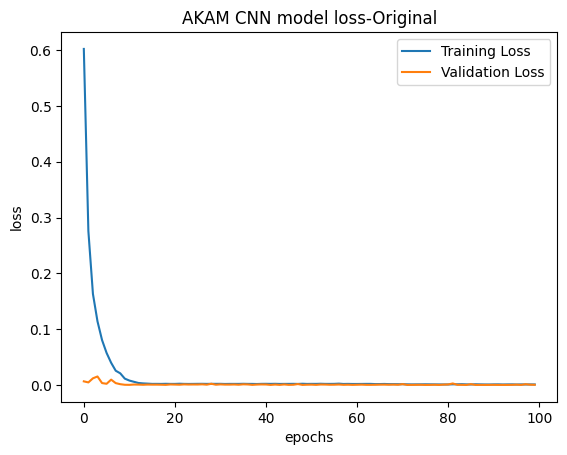

In [53]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

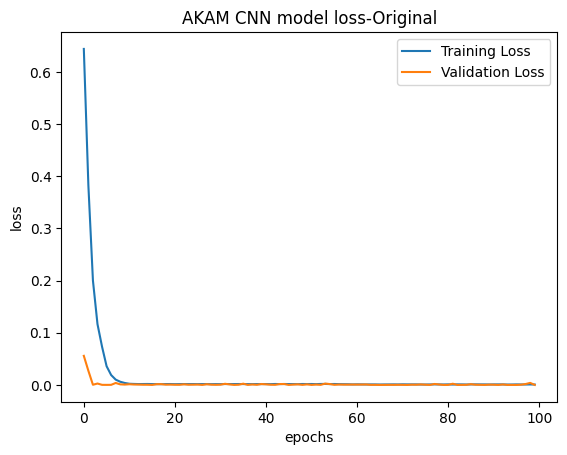

In [64]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [65]:
# Save the entire model as a `.keras` zip archive.
# best_model.save('TSLA_model_hyperparameter.keras')
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_Original/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_Original/assets


In [54]:
best_model.summary()

Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_536 (Conv1D)         (None, 10, 64)            256       
                                                                 
 batch_normalization_536 (B  (None, 10, 64)            256       
 atchNormalization)                                              
                                                                 
 dropout_638 (Dropout)       (None, 10, 64)            0         
                                                                 
 conv1d_537 (Conv1D)         (None, 10, 64)            12352     
                                                                 
 dropout_639 (Dropout)       (None, 10, 64)            0         
                                                                 
 batch_normalization_537 (B  (None, 10, 64)            256       
 atchNormalization)                                 

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

window size=10

In [55]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
# plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with CNN({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with CNN({a})',ticker,y_raw, predicted_stock_price_raw)

****************************TEST************************************


window size=60

In [63]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
# plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with CNN({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with CNN({a})',ticker,y_raw, predicted_stock_price_raw)

****************************TEST************************************


In [ ]:
plot_comparison(y_test,predicted_stock_price_raw)

#### AKAM - Filtered(SMA)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
Filter Name- SMA


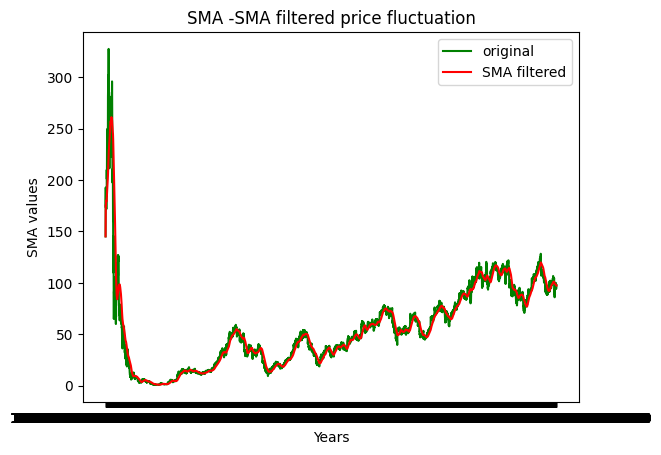

In [79]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="SMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="SMA"
sma_win = 50 #Re run
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AKAM_data.csv' does exist.
Filter Name- SMA


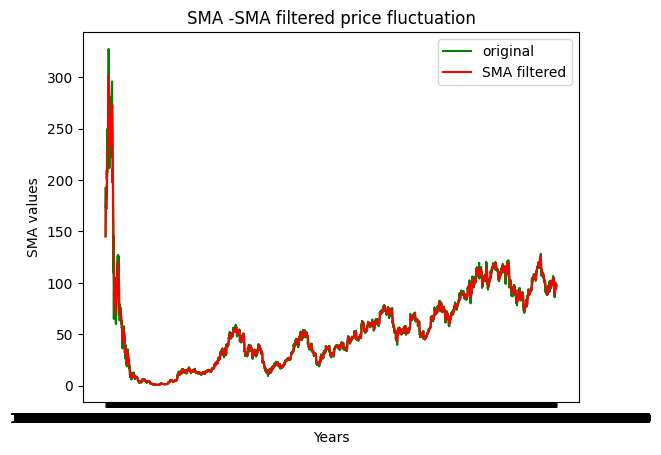

In [73]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="SMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="SMA"
sma_win = 10 #Re run
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### Best parameter values

In [72]:
study_cnn.best_trial.params

{'win_size': 10,
 'epoch_no': 100,
 'split_size': 0.4,
 'units': 30,
 'drop_out': 0.4,
 'optimizer_name': 'nadam',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'filter_size': 64,
 'kernel_size': 3,
 'activation_name': 'gelu'}

##### After hyperparameter tuning - Train model with best values

win_size=50

In [68]:
win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.5844 - val_loss: 0.0071
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2993 - val_loss: 0.0214
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1620 - val_loss: 0.0043
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1043 - val_loss: 0.0096
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0794 - val_loss: 0.0028
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0592 - val_loss: 0.0011
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0430 - val_loss: 0.0030
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0298 - val_loss: 2.3665e-04
Epoch 9/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0208 - val_loss: 8.8731e-05
Epoch 1

win_size=10

In [74]:
win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.5674 - val_loss: 0.0220
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2538 - val_loss: 0.0078
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1560 - val_loss: 0.0018
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1111 - val_loss: 0.0026
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0766 - val_loss: 0.0028
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0542 - val_loss: 1.1893e-04
Epoch 7/100
119/119 [==============================] - 1s 10ms/step - loss: 0.0388 - val_loss: 0.0092
Epoch 8/100
119/119 [==============================] - 1s 10ms/step - loss: 0.0255 - val_loss: 6.8043e-04
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0165 - val_loss: 3.7510e-04
E

##### Evalute tuned model

In [69]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.10%
Mean Absolute Error (MAE): 10.09
Root Mean Squared Error (RMSE): 10.17
R2 Score: 0.06


In [75]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.06%
Mean Absolute Error (MAE): 6.26
Root Mean Squared Error (RMSE): 6.42
R2 Score: 0.67


##### Validation and training loss plot

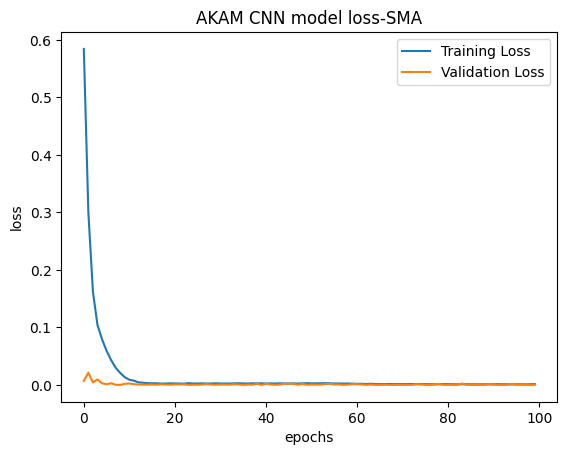

In [70]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

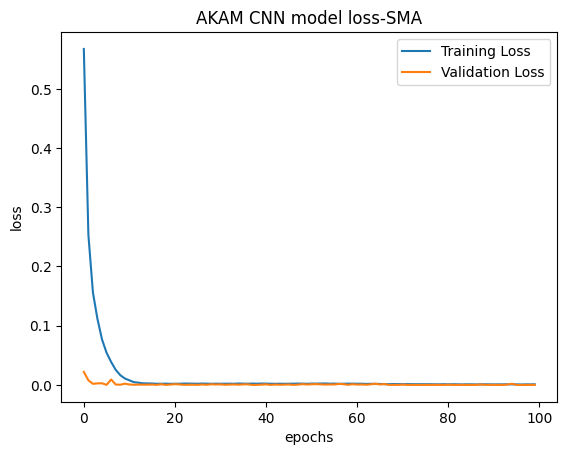

In [77]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [78]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{sma_win}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_SMA_10/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_SMA_10/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [71]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [76]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(kalman)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
Filter Name- kalman


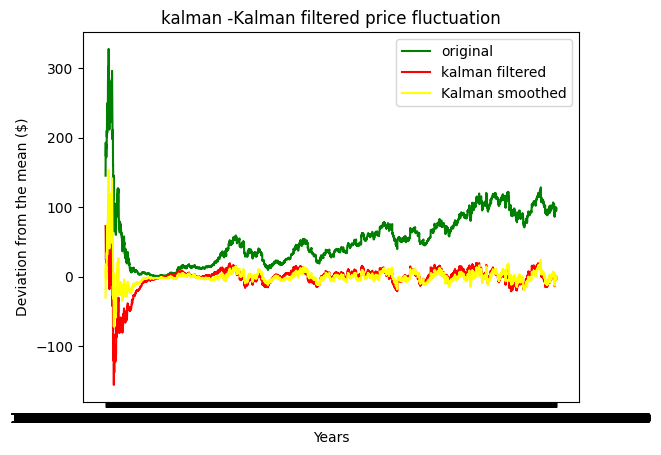

In [81]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="kalman" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="kalman"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### Best parameter values

In [80]:
study_cnn.best_trial.params

{'win_size': 10,
 'epoch_no': 100,
 'split_size': 0.4,
 'units': 30,
 'drop_out': 0.4,
 'optimizer_name': 'nadam',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'filter_size': 64,
 'kernel_size': 3,
 'activation_name': 'gelu'}

##### After hyperparameter tuning - Evaluate model with best values

In [82]:
win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 9ms/step - loss: 0.5002 - val_loss: 0.1296
Epoch 2/100
119/119 [==============================] - 1s 8ms/step - loss: 0.1638 - val_loss: 0.0892
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0849 - val_loss: 0.0604
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0521 - val_loss: 0.0411
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0305 - val_loss: 0.0170
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0195 - val_loss: 0.0096
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0125 - val_loss: 0.0058
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0089 - val_loss: 0.0040
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 10/100
119

##### Evaluate trained model

In [83]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************kalman filter***************************
Mean Absolute Percentage Error (MAPE): 3.31%
Mean Absolute Error (MAE): 4.93
Root Mean Squared Error (RMSE): 5.62
R2 Score: 0.63


##### Val and training loss plot

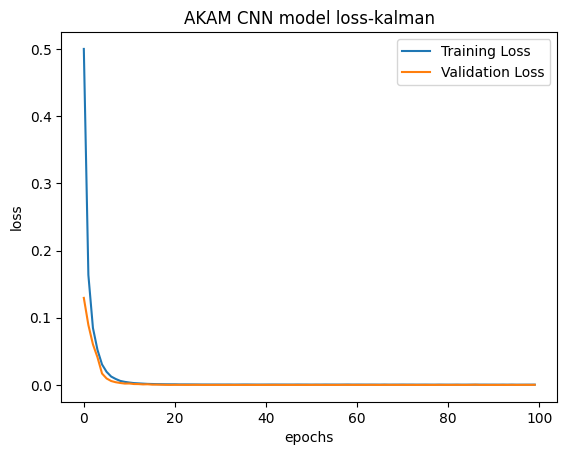

In [84]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [89]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_kalman/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_kalman/assets


In [87]:
best_model.summary()

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_551 (Conv1D)         (None, 10, 64)            256       
                                                                 
 batch_normalization_551 (B  (None, 10, 64)            256       
 atchNormalization)                                              
                                                                 
 dropout_658 (Dropout)       (None, 10, 64)            0         
                                                                 
 conv1d_552 (Conv1D)         (None, 10, 64)            12352     
                                                                 
 dropout_659 (Dropout)       (None, 10, 64)            0         
                                                                 
 batch_normalization_552 (B  (None, 10, 64)            256       
 atchNormalization)                                 

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [60]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

KeyError: "None of [Index(['Close'], dtype='object')] are in the [columns]"

#### AKAM - Filtered(EMA)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
Filter Name- EMA


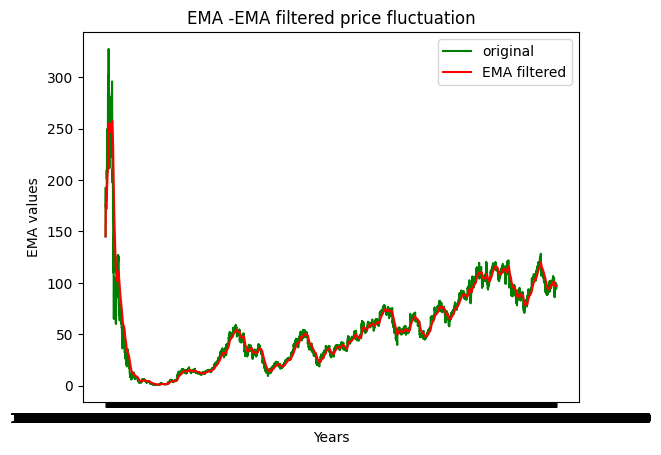

In [94]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
ema_win=50
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="EMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="EMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### Best parameter values

In [91]:
study_cnn.best_trial.params

{'win_size': 10,
 'epoch_no': 100,
 'split_size': 0.4,
 'units': 30,
 'drop_out': 0.4,
 'optimizer_name': 'nadam',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'filter_size': 64,
 'kernel_size': 3,
 'activation_name': 'gelu'}

##### After hyperparameter tuning - Evaluate model with best values

ema_win=20

In [92]:
win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.5599 - val_loss: 0.0253
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2746 - val_loss: 0.0158
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1792 - val_loss: 0.0046
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1071 - val_loss: 0.0077
Epoch 5/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0876 - val_loss: 0.0120
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0622 - val_loss: 0.0019
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0390 - val_loss: 0.0038
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0246 - val_loss: 7.0706e-05
Epoch 9/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0180 - val_loss: 1.1171e-04
Epoch 1

ema_win=50

In [95]:
win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.5060 - val_loss: 0.0233
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2230 - val_loss: 0.0063
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1453 - val_loss: 0.0116
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0887 - val_loss: 0.0046
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0625 - val_loss: 0.0050
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0434 - val_loss: 0.0040
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0284 - val_loss: 0.0072
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0183 - val_loss: 0.0013
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0118 - val_loss: 0.0012
Epoch 10/100
11

In [99]:
win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 4.1090 - val_loss: 0.0556
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 2.2356 - val_loss: 0.0476
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 1.1026 - val_loss: 0.0106
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.9110 - val_loss: 0.0216
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.6485 - val_loss: 0.0358
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.4597 - val_loss: 0.0025
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.4621 - val_loss: 0.0021
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.3219 - val_loss: 0.0027
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2335 - val_loss: 0.0102
Epoch 10/100
11

##### Evaluate trained model

In [93]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.19%
Mean Absolute Error (MAE): 19.16
Root Mean Squared Error (RMSE): 19.48
R2 Score: -2.25


log_cosh and ema_win=50

In [96]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.04%
Mean Absolute Error (MAE): 4.50
Root Mean Squared Error (RMSE): 4.56
R2 Score: 0.80


mean_squared_error

In [100]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.01%
Mean Absolute Error (MAE): 1.05
Root Mean Squared Error (RMSE): 1.32
R2 Score: 0.98


##### Val and training loss plot

mean_squared_error

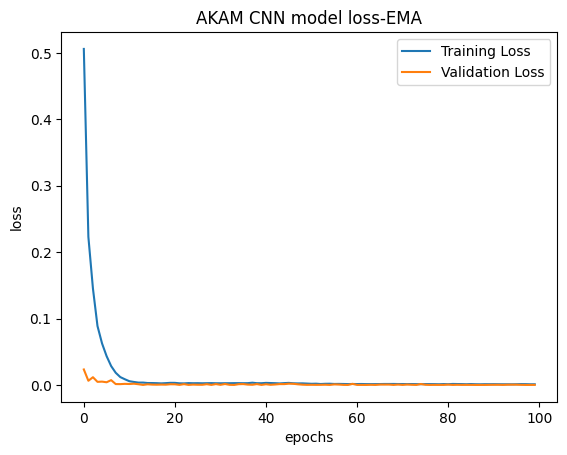

In [97]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [102]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{ema_win}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_EMA_50/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_EMA_50/assets


In [194]:
best_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 50, 70)            20160     
                                                                 
 dropout_34 (Dropout)        (None, 50, 70)            0         
                                                                 
 lstm_35 (LSTM)              (None, 70)                39480     
                                                                 
 dropout_35 (Dropout)        (None, 70)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 71        
                                                                 
Total params: 59711 (233.25 KB)
Trainable params: 59711 (233.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [98]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


mean_squared_error

In [101]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### TSLA - Filtered(MACD)

##### Start Tuning

[I 2024-11-26 19:16:09,397] A new study created in memory with name: MACD


Filter Name- MACD
Epoch 1/10
91/91 [==============================] - 3s 14ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 3/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 4/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 5/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 8/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 9/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 10/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0033


[I 2024-11-26 19:16:20,064] Trial 0 finished with value: 0.0032991310581564903 and parameters: {'win_size': 20, 'epoch_no': 10, 'split_size': 0.2, 'units': 70, 'drop_out': 0.2}. Best is trial 0 with value: 0.0032991310581564903.


loss value [0.010338778607547283, 0.009312453679740429, 0.008104554377496243, 0.008184535428881645, 0.0070703160017728806, 0.006199487950652838, 0.005478709004819393, 0.0040875328704714775, 0.004820379428565502, 0.0032991310581564903]
Epoch 1/25
68/68 [==============================] - 4s 20ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 2/25
68/68 [==============================] - 1s 11ms/step - loss: 9.5575e-04 - val_loss: 0.0086
Epoch 3/25
68/68 [==============================] - 1s 12ms/step - loss: 8.2655e-04 - val_loss: 0.0088
Epoch 4/25
68/68 [==============================] - 1s 12ms/step - loss: 7.4906e-04 - val_loss: 0.0085
Epoch 5/25
68/68 [==============================] - 1s 12ms/step - loss: 6.9822e-04 - val_loss: 0.0087
Epoch 6/25
68/68 [==============================] - 1s 12ms/step - loss: 6.5303e-04 - val_loss: 0.0093
Epoch 7/25
68/68 [==============================] - 1s 11ms/step - loss: 6.2656e-04 - val_loss: 0.0092
Epoch 8/25
68/68 [==============================

[I 2024-11-26 19:16:35,230] Trial 1 finished with value: 0.008545308373868465 and parameters: {'win_size': 40, 'epoch_no': 25, 'split_size': 0.4, 'units': 70, 'drop_out': 0.2}. Best is trial 0 with value: 0.0032991310581564903.


loss value [0.008725729770958424, 0.008564658463001251, 0.008764608763158321, 0.008545308373868465, 0.008692014962434769, 0.009346519596874714, 0.009218539111316204, 0.01007468905299902, 0.009372632950544357, 0.009564652107656002, 0.009989520534873009, 0.010228118859231472, 0.010320046916604042, 0.010919501073658466]
Best parameters: for MACD filter {'win_size': 20, 'epoch_no': 10, 'split_size': 0.2, 'units': 70, 'drop_out': 0.2}
Best value: for MACD filter 0.0032991310581564903
    win_size: 20
    epoch_no: 10
    split_size: 0.2
    units: 70
    drop_out: 0.2


({'win_size': 20,
  'epoch_no': 10,
  'split_size': 0.2,
  'units': 70,
  'drop_out': 0.2},
 0.0032991310581564903)

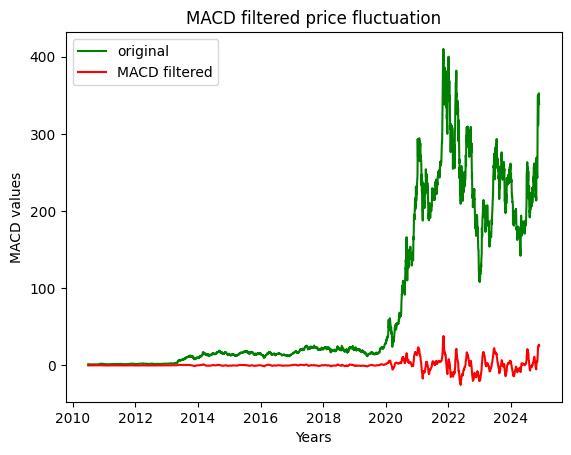

In [196]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="MACD" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="MACD"
abc(ticker,n_trial,filter,f"{study_naam}",batch_size_no,attn)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_cnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_cnn)

##### Best parameter values

In [ ]:
study_cnn.best_trial.params

{'win_size': 20,
 'epoch_no': 10,
 'split_size': 0.2,
 'units': 70,
 'drop_out': 0.2}

##### After hyperparameter tuning - Evaluate model with best values

In [ ]:
win_size=study_cnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_cnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_cnn.best_trial.params['split_size'],2)
attn=False
units=study_cnn.best_trial.params['units']
drop_out=round(study_cnn.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_cnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/10
91/91 [==============================] - 3s 14ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 3/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 4/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 5/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 8/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 9/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 10/10
91/91 [==============================] - 1s 8ms/step - loss: 9.8636e-04 - val_loss: 0.0025


##### Evaluate trained model

In [ ]:
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

23/23 [==============================] - 1s 3ms/step
**********************MACD filter***************************
Mean Absolute Percentage Error (MAPE): 1.92%
Mean Absolute Error (MAE): 2.41
Root Mean Squared Error (RMSE): 3.14
R2 Score: 0.91


##### Val and training loss plot

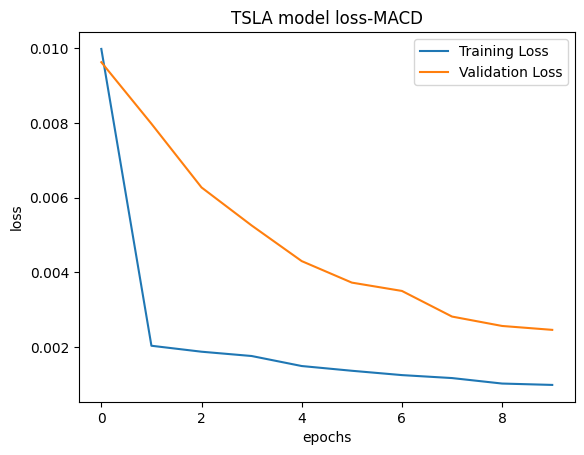

In [202]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [204]:
best_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 20, 70)            20160     
                                                                 
 dropout_40 (Dropout)        (None, 20, 70)            0         
                                                                 
 lstm_41 (LSTM)              (None, 70)                39480     
                                                                 
 dropout_41 (Dropout)        (None, 70)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 71        
                                                                 
Total params: 59711 (233.25 KB)
Trainable params: 59711 (233.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

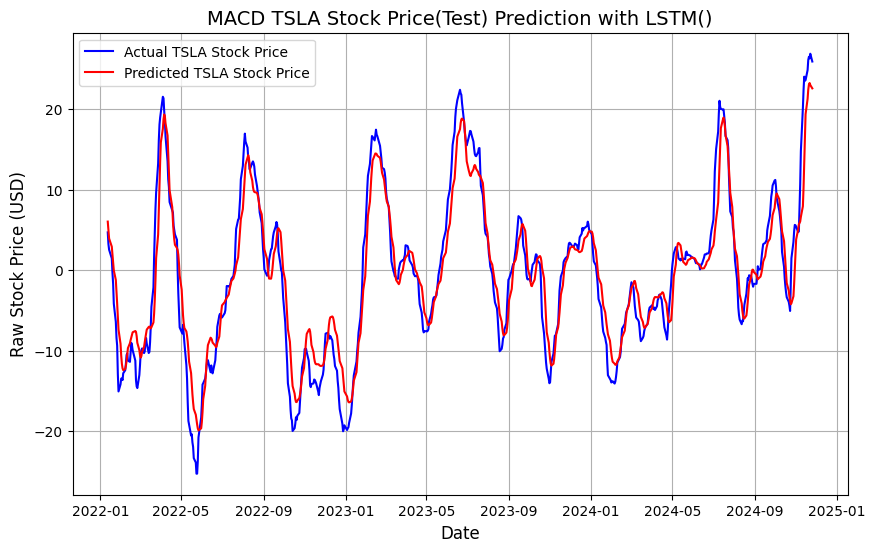

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="cnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### AKAM - Filtered(Fourier)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
freq- [ 0.          0.00015798  0.00031596 ... -0.00047393 -0.00031596
 -0.00015798]
amp- [344715.01760691 122909.57037917  65989.7722986  ...  52740.26812119
  65989.7722986  122909.57037917]


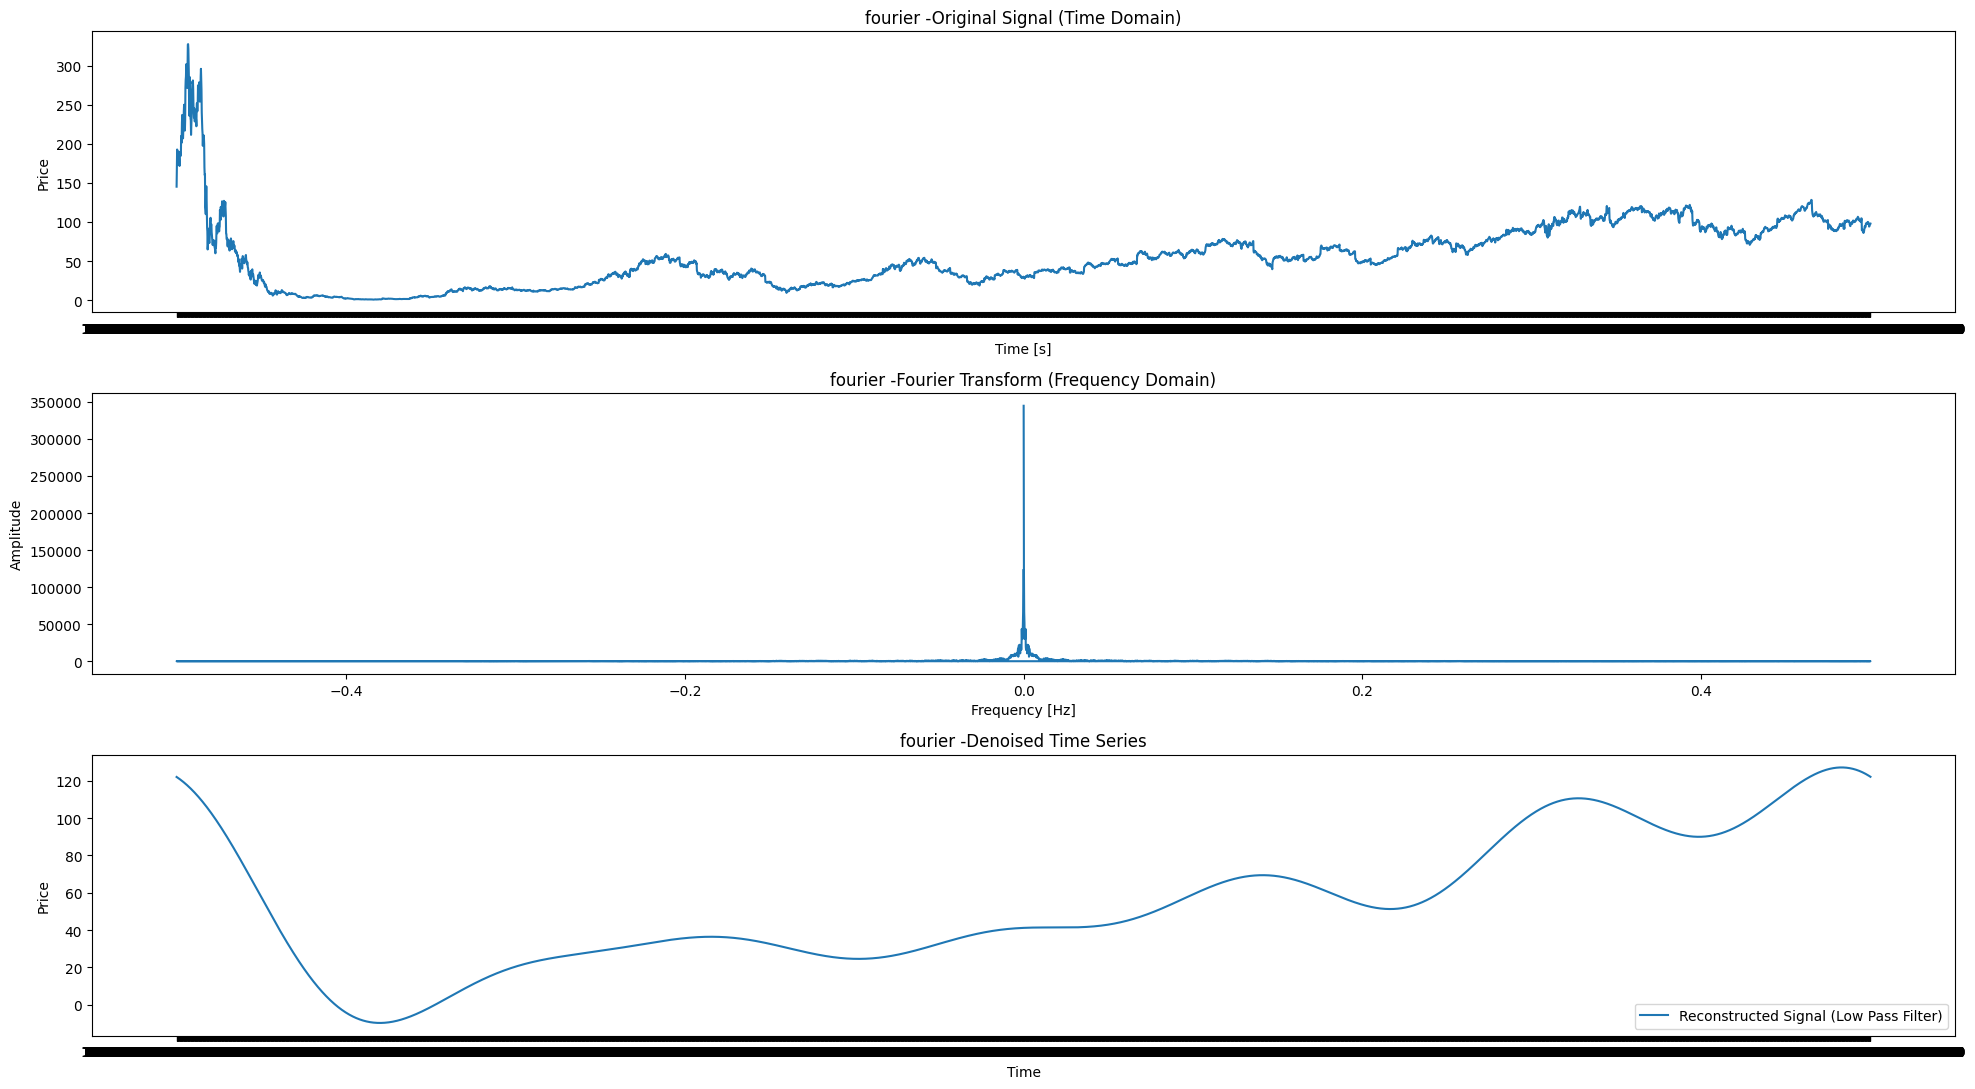

Filter Name- fourier


In [104]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
threshold = 0.001 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AKAM_data.csv' does exist.
freq- [ 0.          0.00015798  0.00031596 ... -0.00047393 -0.00031596
 -0.00015798]
amp- [344715.01760691 122909.57037917  65989.7722986  ...  52740.26812119
  65989.7722986  122909.57037917]


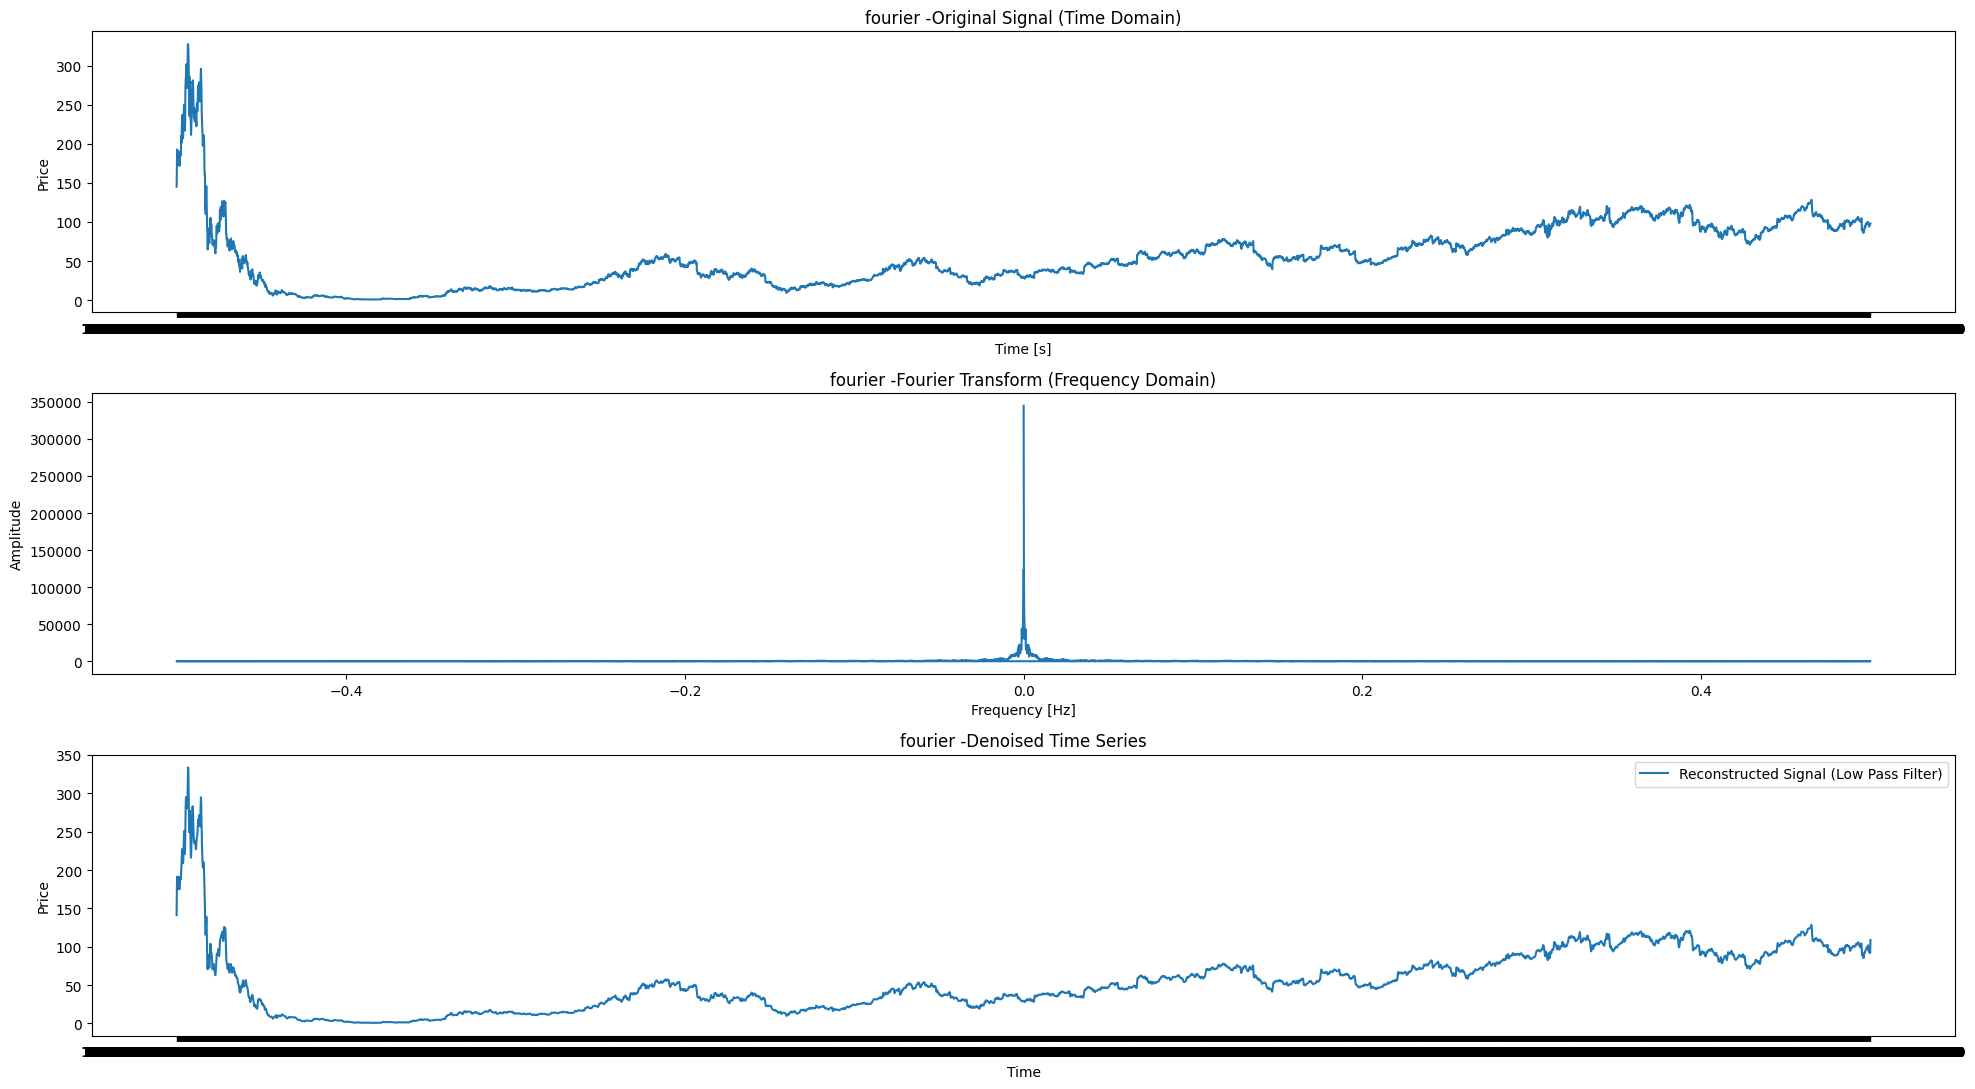

Filter Name- fourier


In [110]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
threshold = 0.2 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AKAM_data.csv' does exist.
freq- [ 0.          0.00015798  0.00031596 ... -0.00047393 -0.00031596
 -0.00015798]
amp- [344715.01760691 122909.57037917  65989.7722986  ...  52740.26812119
  65989.7722986  122909.57037917]


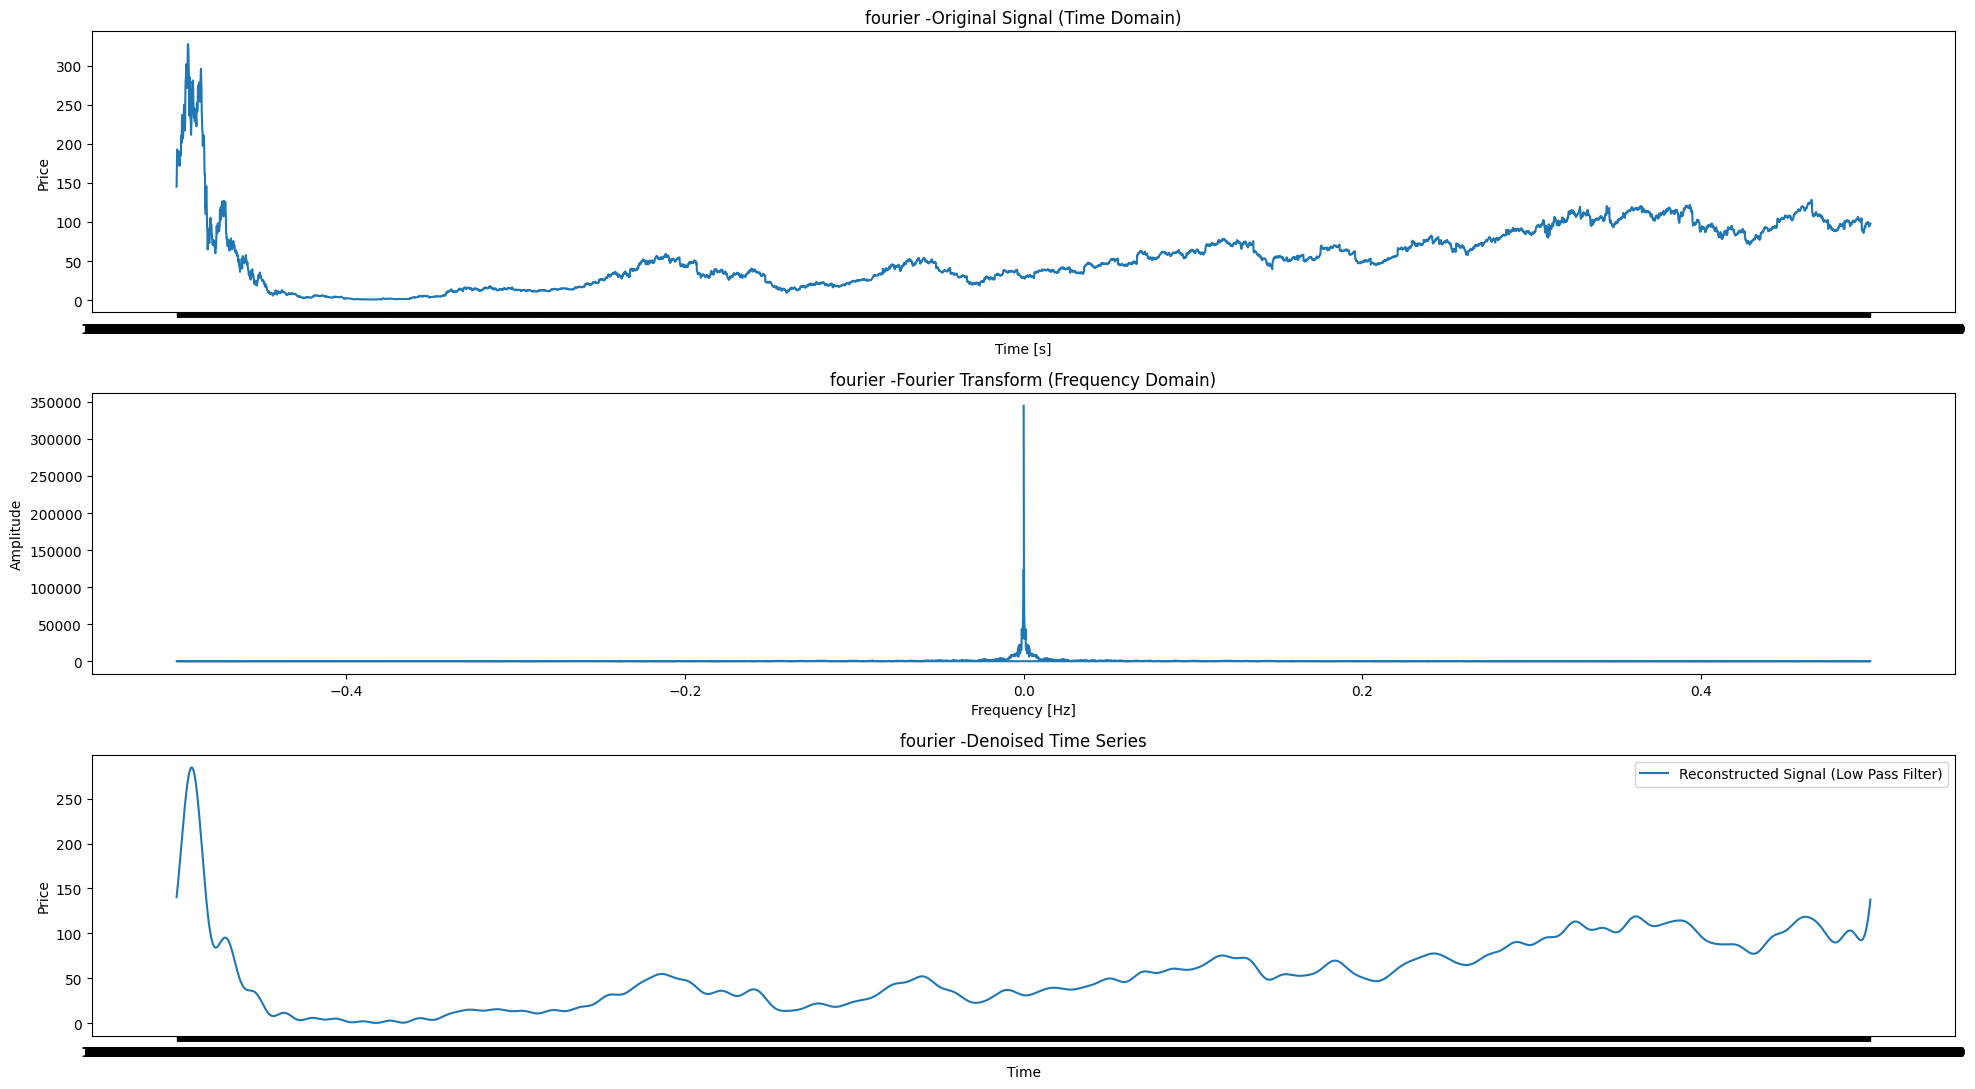

Filter Name- fourier


In [116]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
threshold = 0.01 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### Best parameter values

In [103]:
study_cnn.best_trial.params

{'win_size': 10,
 'epoch_no': 100,
 'split_size': 0.4,
 'units': 30,
 'drop_out': 0.4,
 'optimizer_name': 'nadam',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'filter_size': 64,
 'kernel_size': 3,
 'activation_name': 'gelu'}

##### After hyperparameter tuning - Train model with best values

0.001

In [105]:
win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.5909 - val_loss: 0.1481
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2285 - val_loss: 0.1012
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1458 - val_loss: 0.0714
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0925 - val_loss: 0.0243
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0649 - val_loss: 0.0043
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0430 - val_loss: 0.0199
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0278 - val_loss: 1.8312e-04
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0196 - val_loss: 0.0012
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0117 - val_loss: 1.2627e-04
Epoch 1

0.2

In [111]:
win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.5263 - val_loss: 0.0133
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2417 - val_loss: 0.0085
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1372 - val_loss: 0.0043
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0891 - val_loss: 0.0040
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0652 - val_loss: 0.0043
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0457 - val_loss: 6.2187e-05
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0291 - val_loss: 5.9951e-04
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0192 - val_loss: 8.5179e-04
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0132 - val_loss: 8.1226e-05

0.01

In [117]:
win_size= study_cnn.best_trial.params['win_size']
epoch_no= study_cnn.best_trial.params['epoch_no']
drop_out= round(study_cnn.best_trial.params['drop_out'],2)
units= study_cnn.best_trial.params['units']
split_size= round(study_cnn.best_trial.params['split_size'],2)
optimizer_options =study_cnn.best_trial.params['optimizer_name']
num_of_layers= study_cnn.best_trial.params['no_layers']  
loss_option= study_cnn.best_trial.params['loss_fn_name']
actv_option= study_cnn.best_trial.params['activation_name']
filter_size= study_cnn.best_trial.params['filter_size']
kernel_size= study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.5230 - val_loss: 0.0220
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2313 - val_loss: 0.0166
Epoch 3/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1422 - val_loss: 0.0075
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0864 - val_loss: 0.0043
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0633 - val_loss: 0.0088
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0412 - val_loss: 8.5343e-05
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0305 - val_loss: 0.0020
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0178 - val_loss: 0.0018
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0130 - val_loss: 3.5575e-04
Epoch 1

##### Evaluate trained model

In [106]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.02%
Mean Absolute Error (MAE): 1.67
Root Mean Squared Error (RMSE): 1.84
R2 Score: 0.98


In [112]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.13%
Mean Absolute Error (MAE): 12.99
Root Mean Squared Error (RMSE): 13.38
R2 Score: -0.39


In [118]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.11%
Mean Absolute Error (MAE): 11.29
Root Mean Squared Error (RMSE): 11.49
R2 Score: -0.10


##### Val and training loss plot

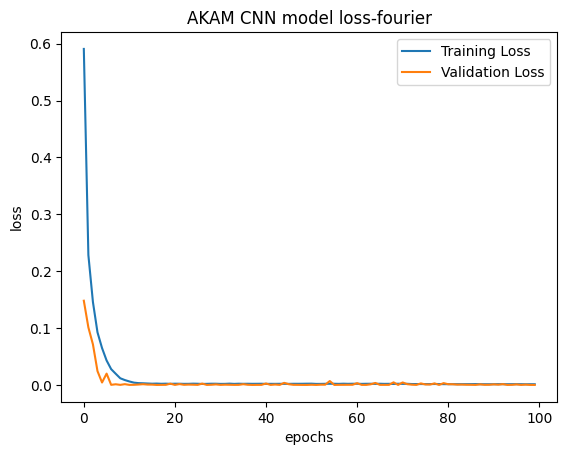

In [107]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

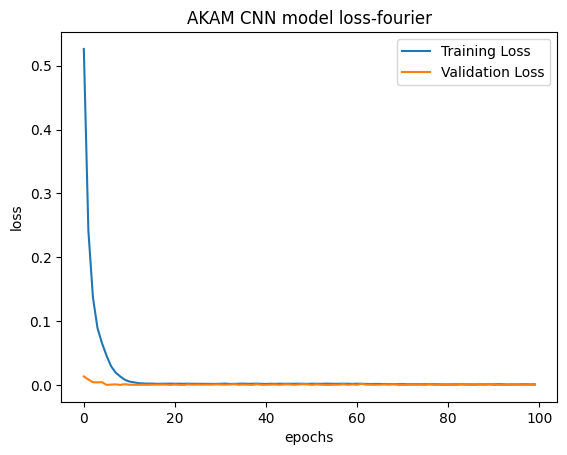

In [114]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

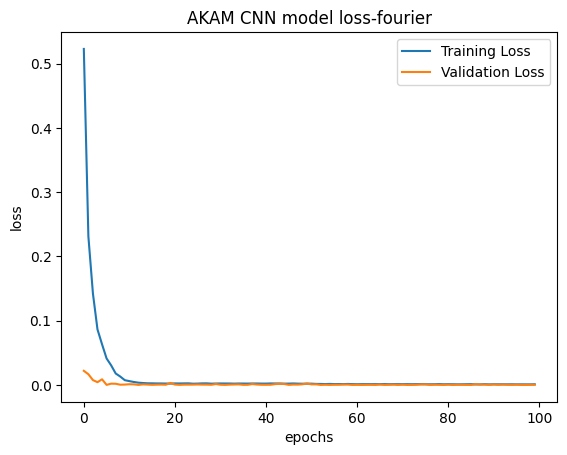

In [119]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [121]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{threshold}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_fourier_0.01/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_fourier_0.01/assets


In [108]:
best_model.summary()

Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_563 (Conv1D)         (None, 10, 64)            256       
                                                                 
 batch_normalization_563 (B  (None, 10, 64)            256       
 atchNormalization)                                              
                                                                 
 dropout_674 (Dropout)       (None, 10, 64)            0         
                                                                 
 conv1d_564 (Conv1D)         (None, 10, 64)            12352     
                                                                 
 dropout_675 (Dropout)       (None, 10, 64)            0         
                                                                 
 batch_normalization_564 (B  (None, 10, 64)            256       
 atchNormalization)                                 

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [109]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [113]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [120]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(Wavelet)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
length of details- 6
Threshold enabled- False


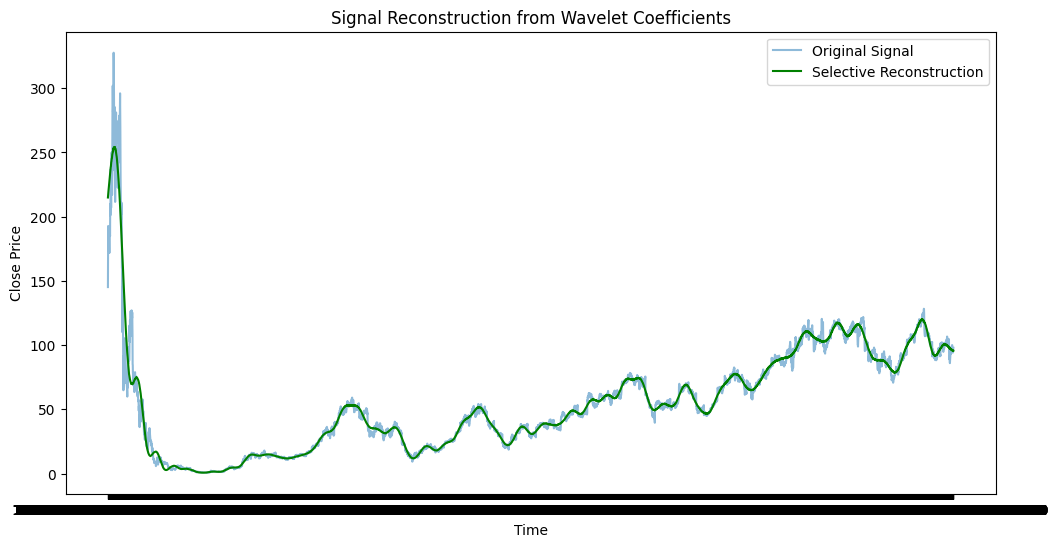

Filter Name- wavelet


In [33]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=8
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

detail_index=4 and dmey

The file 'AKAM_data.csv' does exist.
length of details- 6
Threshold enabled- False


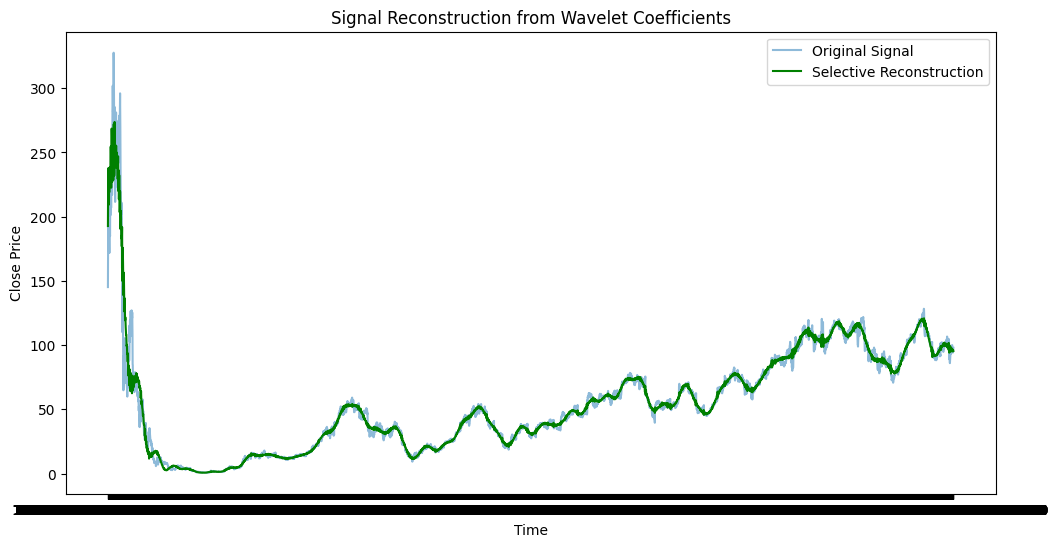

Filter Name- wavelet


In [38]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=4
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

sym18

The file 'AKAM_data.csv' does exist.
length of details- 7
Threshold enabled- False


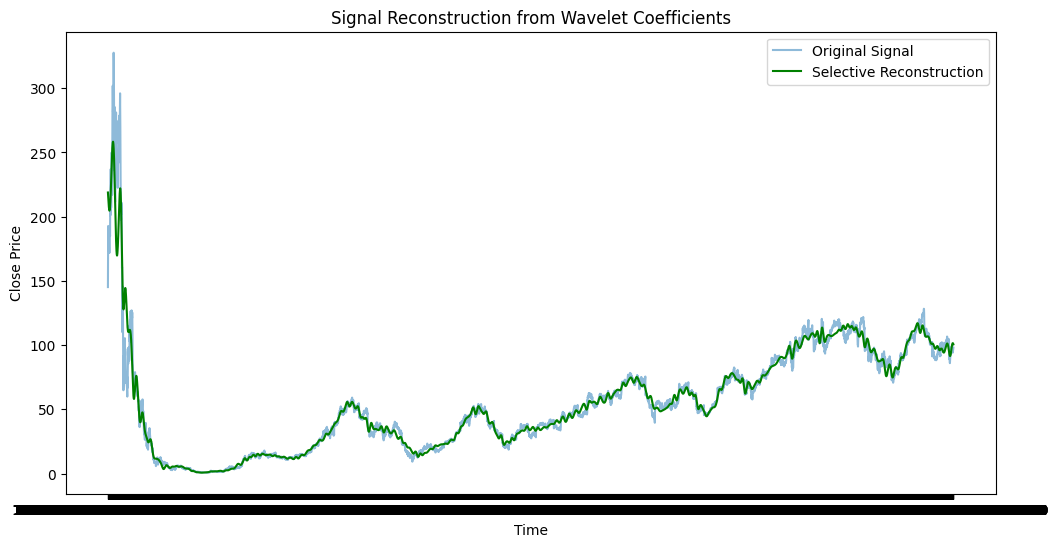

Filter Name- wavelet


In [44]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=2
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="sym18"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AKAM_data.csv' does exist.
length of details- 7
Threshold enabled- False


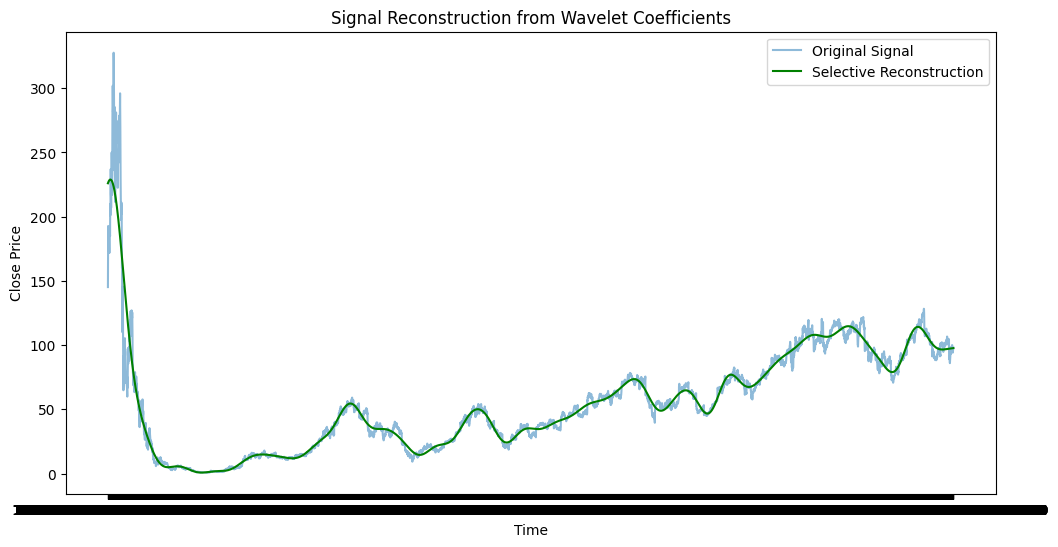

Filter Name- wavelet


In [49]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=7
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="sym18"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

##### After hyperparameter tuning - Train model with best values

In [34]:
win_size= 10 #study_cnn.best_trial.params['win_size']
epoch_no= 100 #study_cnn.best_trial.params['epoch_no']
drop_out= 0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units= 30 #study_cnn.best_trial.params['units']
split_size= 0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu' #study_cnn.best_trial.params['activation_name']
filter_size= 64 #study_cnn.best_trial.params['filter_size']
kernel_size= 3 #study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


2024-12-30 12:04:23.348697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13816 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6


Epoch 1/100


2024-12-30 12:04:27.087008: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-30 12:04:28.209821: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 12:04:28.213767: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-12-30 12:04:28.213819: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-30 12:04:28.213974: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-12-30 12:04

119/119 [==============================] - 11s 14ms/step - loss: 0.3784 - val_loss: 0.0252
Epoch 2/100
119/119 [==============================] - 1s 8ms/step - loss: 0.1783 - val_loss: 0.0132
Epoch 3/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0984 - val_loss: 0.0035
Epoch 4/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0591 - val_loss: 0.0139
Epoch 5/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0375 - val_loss: 0.0013
Epoch 6/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0226 - val_loss: 0.0020
Epoch 7/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0171 - val_loss: 0.0026
Epoch 8/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0098 - val_loss: 5.0377e-05
Epoch 9/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0056 - val_loss: 6.9183e-05
Epoch 10/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0045 - val_loss

In [39]:
win_size= 10 #study_cnn.best_trial.params['win_size']
epoch_no= 100 #study_cnn.best_trial.params['epoch_no']
drop_out= 0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units= 30 #study_cnn.best_trial.params['units']
split_size= 0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu' #study_cnn.best_trial.params['activation_name']
filter_size= 64 #study_cnn.best_trial.params['filter_size']
kernel_size= 3 #study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 9ms/step - loss: 0.4745 - val_loss: 0.0170
Epoch 2/100
119/119 [==============================] - 1s 8ms/step - loss: 0.2181 - val_loss: 0.0078
Epoch 3/100
119/119 [==============================] - 1s 8ms/step - loss: 0.1357 - val_loss: 0.0164
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0771 - val_loss: 4.8989e-04
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0534 - val_loss: 0.0072
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0388 - val_loss: 0.0031
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0242 - val_loss: 5.5512e-05
Epoch 8/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0150 - val_loss: 9.0105e-04
Epoch 9/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0108 - val_loss: 8.3603e-04


sym18 and index =2

In [45]:
win_size= 10 #study_cnn.best_trial.params['win_size']
epoch_no= 100 #study_cnn.best_trial.params['epoch_no']
drop_out= 0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units= 30 #study_cnn.best_trial.params['units']
split_size= 0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu' #study_cnn.best_trial.params['activation_name']
filter_size= 64 #study_cnn.best_trial.params['filter_size']
kernel_size= 3 #study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 9ms/step - loss: 0.4429 - val_loss: 0.0135
Epoch 2/100
119/119 [==============================] - 1s 8ms/step - loss: 0.1729 - val_loss: 0.0089
Epoch 3/100
119/119 [==============================] - 1s 8ms/step - loss: 0.1048 - val_loss: 0.0132
Epoch 4/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0674 - val_loss: 0.0112
Epoch 5/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0426 - val_loss: 0.0086
Epoch 6/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0299 - val_loss: 0.0011
Epoch 7/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0169 - val_loss: 7.4137e-04
Epoch 8/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0093 - val_loss: 7.8717e-04
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0071 - val_loss: 5.5952e-04
Epoc

sym18 and index =7

In [50]:
win_size= 10 #study_cnn.best_trial.params['win_size']
epoch_no= 100 #study_cnn.best_trial.params['epoch_no']
drop_out= 0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units= 30 #study_cnn.best_trial.params['units']
split_size= 0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu' #study_cnn.best_trial.params['activation_name']
filter_size= 64 #study_cnn.best_trial.params['filter_size']
kernel_size= 3 #study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
Epoch 1/100
119/119 [==============================] - 4s 10ms/step - loss: 0.4800 - val_loss: 0.0309
Epoch 2/100
119/119 [==============================] - 1s 8ms/step - loss: 0.2319 - val_loss: 0.0266
Epoch 3/100
119/119 [==============================] - 1s 8ms/step - loss: 0.1361 - val_loss: 0.0132
Epoch 4/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0843 - val_loss: 0.0095
Epoch 5/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0555 - val_loss: 0.0026
Epoch 6/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0370 - val_loss: 4.8417e-04
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0274 - val_loss: 0.0043
Epoch 8/100
119/119 [==============================] - 1s 8ms/step - loss: 0.0189 - val_loss: 3.5494e-04
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0124 - val_loss: 8.3887e-04
Epo

##### Evaluate trained model

dmey detail=8

In [35]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 1ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 3.43
Root Mean Squared Error (RMSE): 3.68
R2 Score: 0.88


dmey detail=4

In [40]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 3.52
Root Mean Squared Error (RMSE): 3.84
R2 Score: 0.87


sym18 index =2

In [46]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 3.42
Root Mean Squared Error (RMSE): 3.58
R2 Score: 0.87


In [51]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 2ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.09%
Mean Absolute Error (MAE): 8.99
Root Mean Squared Error (RMSE): 9.11
R2 Score: 0.13


##### Val and training loss plot

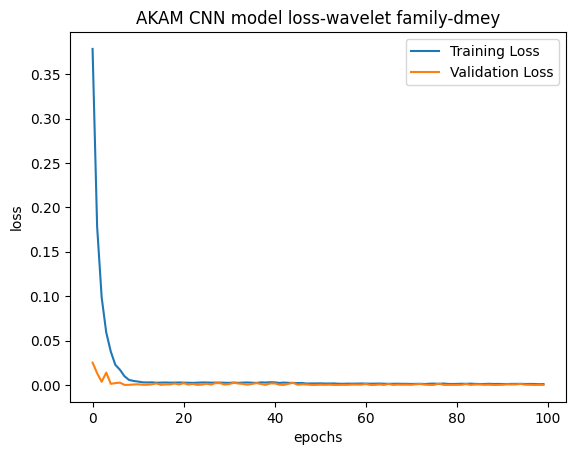

In [36]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

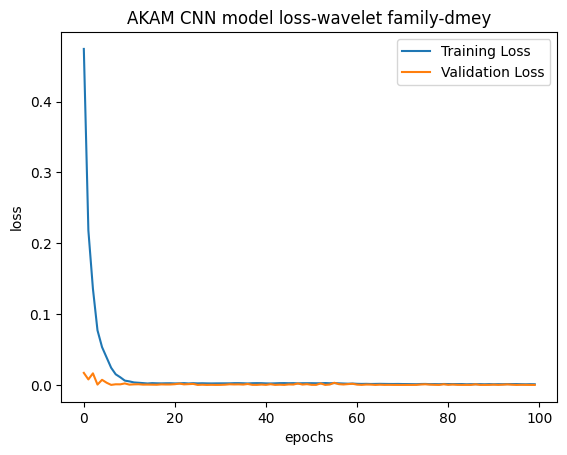

In [41]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

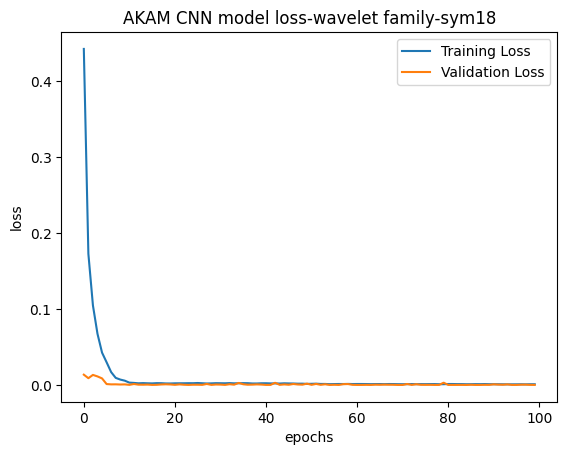

In [47]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

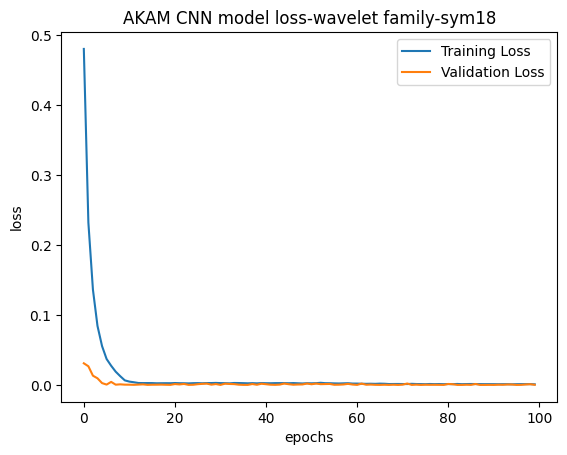

In [52]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [42]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{wavelet_name}({detail_index})')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_wavelet_dmey(4)/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_wavelet_dmey(4)/assets


In [57]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 70)            20160     
                                                                 
 dropout_4 (Dropout)         (None, 30, 70)            0         
                                                                 
 lstm_5 (LSTM)               (None, 70)                39480     
                                                                 
 dropout_5 (Dropout)         (None, 70)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 59711 (233.25 KB)
Trainable params: 59711 (233.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [37]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [43]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [48]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [53]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### TSLA - Filtered(STL)

##### Start Tuning

In [31]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="STL" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="STL"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
stl_period=30
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period,stl_period)

[I 2024-12-02 13:30:26,004] A new study created in memory with name: mstl


Epoch 1/5


2024-12-02 13:30:27.637341: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



79/79 [==============================] - 4s 18ms/step - loss: 0.3486 - val_loss: 0.2584
Epoch 2/5
79/79 [==============================] - 1s 9ms/step - loss: 0.0698 - val_loss: 0.3455
Epoch 3/5
79/79 [==============================] - 1s 9ms/step - loss: 0.0672 - val_loss: 0.0812
Epoch 4/5
79/79 [==============================] - 1s 9ms/step - loss: 0.0558 - val_loss: 0.1328
Epoch 5/5
79/79 [==============================] - 1s 9ms/step - loss: 0.0517 - val_loss: 21.5080


[I 2024-12-02 13:30:32,714] Trial 0 finished with value: 0.08116770535707474 and parameters: {'win_size': 20, 'epoch_no': 5, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.5, 'filter_size': 64, 'kernel_size': 3}. Best is trial 0 with value: 0.08116770535707474.


loss value [0.258429616689682, 0.34553292393684387, 0.08116770535707474, 0.1328061819076538, 21.50798225402832]
Epoch 1/20


2024-12-02 13:30:34.071104: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:30:34.170083: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



91/91 [==============================] - 3s 15ms/step - loss: 0.1238 - val_loss: 0.2915
Epoch 2/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0838 - val_loss: 0.2588
Epoch 3/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0596 - val_loss: 0.2120
Epoch 4/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0736 - val_loss: 0.0428
Epoch 5/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0376 - val_loss: 0.0518
Epoch 6/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0266 - val_loss: 1.4676
Epoch 7/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0294 - val_loss: 0.6708
Epoch 8/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0204 - val_loss: 13.8265
Epoch 9/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0170 - val_loss: 3.5980
Epoch 10/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0140 - val_loss: 54.2591
Epoch 11/20
91/91 [========

[I 2024-12-02 13:30:46,421] Trial 1 finished with value: 0.04281292110681534 and parameters: {'win_size': 20, 'epoch_no': 20, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'filter_size': 64, 'kernel_size': 3}. Best is trial 1 with value: 0.04281292110681534.


loss value [0.2915045917034149, 0.258821576833725, 0.21195577085018158, 0.04281292110681534, 0.051841720938682556, 1.4675626754760742, 0.6707903146743774, 13.8264741897583, 3.5980064868927, 54.259056091308594, 6.657013893127441, 50.10568618774414, 17.486520767211914, 11.158255577087402]
Best parameters: for mstl filter {'win_size': 20, 'epoch_no': 20, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'filter_size': 64, 'kernel_size': 3}
Best value: for mstl filter 0.04281292110681534
    win_size: 20
    epoch_no: 20
    split_size: 0.2
    units: 60
    drop_out: 0.2
    filter_size: 64
    kernel_size: 3


({'win_size': 20,
  'epoch_no': 20,
  'split_size': 0.2,
  'units': 60,
  'drop_out': 0.2,
  'filter_size': 64,
  'kernel_size': 3},
 0.04281292110681534)

##### Optuna plot

In [32]:
optuna.visualization.plot_optimization_history(study_cnn)

In [54]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_cnn)

NameError: name 'study_cnn' is not defined

##### Best parameter values

In [34]:
study_cnn.best_trial.params

{'win_size': 20,
 'epoch_no': 20,
 'split_size': 0.2,
 'units': 60,
 'drop_out': 0.2,
 'filter_size': 64,
 'kernel_size': 3}

##### After hyperparameter tuning - Train model with best values

In [35]:
win_size=study_cnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_cnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_cnn.best_trial.params['split_size'],2)
attn=False
units=study_cnn.best_trial.params['units']
drop_out=round(study_cnn.best_trial.params['drop_out'],2)
n_trial=0
filter = study_cnn.best_trial.params['filter_size']
ker_size = study_cnn.best_trial.params['kernel_size']
best_model = build_model(win_size,drop_out,units,split_size,filter,ker_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_cnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/20
91/91 [==============================] - 3s 10ms/step - loss: 0.2265 - val_loss: 0.3043
Epoch 2/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0739 - val_loss: 0.3223
Epoch 3/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0478 - val_loss: 0.2986
Epoch 4/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0356 - val_loss: 0.0882
Epoch 5/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0247 - val_loss: 0.0985
Epoch 6/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0218 - val_loss: 0.0338
Epoch 7/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0189 - val_loss: 0.0246
Epoch 8/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0145 - val_loss: 0.0132
Epoch 9/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0128 - val_loss: 0.0099
Epoch 10/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0110 - val_loss: 0.0152
Epoch 11/20
91/91 

##### Evaluate trained model

In [36]:
X_test_unfilt.shape

(723, 20)

In [37]:
type(X_test_unfilt)

numpy.ndarray

In [38]:
X_test_unfilt

array([[0.78606591, 0.79087492, 0.76310185, ..., 0.90308238, 0.93867759,
        0.87513055],
       [0.79087492, 0.76310185, 0.79594778, ..., 0.93867759, 0.87513055,
        0.89049385],
       [0.76310185, 0.79594778, 0.85581792, ..., 0.87513055, 0.89049385,
        0.87423682],
       ...,
       [0.65978887, 0.65475856, 0.63509697, ..., 0.86437202, 0.89736266,
        0.86169084],
       [0.65475856, 0.63509697, 0.63287544, ..., 0.89736266, 0.86169084,
        0.86077163],
       [0.63509697, 0.63287544, 0.61719721, ..., 0.86169084, 0.86077163,
        0.84713618]])

In [39]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_cnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

23/23 [==============================] - 0s 2ms/step
**********************64 filter***************************
Mean Absolute Percentage Error (MAPE): 0.08%
Mean Absolute Error (MAE): 17.10
Root Mean Squared Error (RMSE): 22.20
R2 Score: 0.82


##### Val and training loss plot

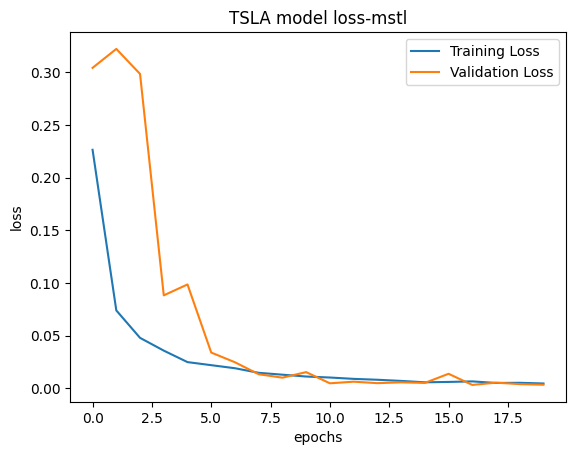

In [40]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [41]:
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 18, 64)            256       
                                                                 
 batch_normalization_10 (Ba  (None, 18, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 9, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_12 (Conv1D)          (None, 7, 64)             12352     
                                                                 
 batch_normalization_11 (Ba  (None, 7, 64)             256       
 tchNormalization)                                               
                                                      

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

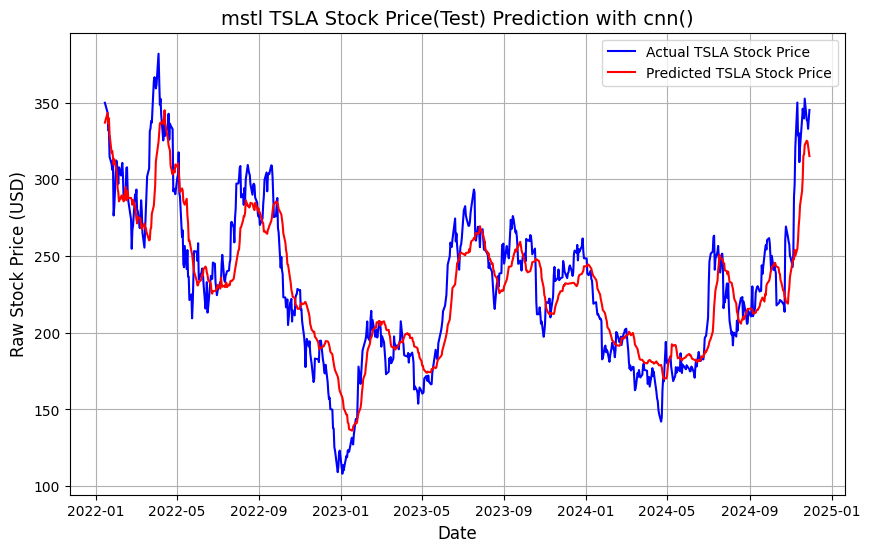

In [42]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="cnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### TSLA - Filtered(MSTL)

##### Start Tuning

In [51]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="MSTL" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="MSTL"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
stl_period=30
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period,stl_period)

[I 2024-12-02 13:39:22,486] A new study created in memory with name: MSTL


                           filtered
Date                               
2010-06-29 00:00:00-04:00  1.384864
2010-06-30 00:00:00-04:00  1.354891
2010-07-01 00:00:00-04:00  1.334636
Epoch 1/25


2024-12-02 13:39:24.214836: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:39:24.369984: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:39:24.688138: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



16/90 [====>.........................] - ETA: 0s - loss: 0.0561 

2024-12-02 13:39:25.303459: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



90/90 [==============================] - 4s 16ms/step - loss: 0.1940 - val_loss: 0.1953
Epoch 2/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0849 - val_loss: 0.2610
Epoch 3/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0648 - val_loss: 0.1216
Epoch 4/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0484 - val_loss: 0.0434
Epoch 5/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0531 - val_loss: 1.5767
Epoch 6/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0276 - val_loss: 7.0524
Epoch 7/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0263 - val_loss: 36.0588
Epoch 8/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0244 - val_loss: 9.8776
Epoch 9/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0203 - val_loss: 16.6280
Epoch 10/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0160 - val_loss: 48.2797
Epoch 11/25
90/90 [=======

[I 2024-12-02 13:39:36,615] Trial 0 finished with value: 0.04341466352343559 and parameters: {'win_size': 40, 'epoch_no': 25, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'filter_size': 16, 'kernel_size': 3}. Best is trial 0 with value: 0.04341466352343559.


loss value [0.1953336000442505, 0.2609606683254242, 0.12164448946714401, 0.04341466352343559, 1.5767498016357422, 7.052412986755371, 36.05884552001953, 9.877638816833496, 16.62801170349121, 48.27968978881836, 21.962846755981445, 7.311124324798584, 79.51514434814453, 12.7335844039917]
Epoch 1/20


2024-12-02 13:39:38.002149: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:39:38.104213: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



68/68 [==============================] - 3s 11ms/step - loss: 0.4491 - val_loss: 0.2135
Epoch 2/20
68/68 [==============================] - 1s 10ms/step - loss: 0.1283 - val_loss: 0.2399
Epoch 3/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0126 - val_loss: 0.2506
Epoch 4/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.2455
Epoch 5/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.1368
Epoch 6/20
68/68 [==============================] - 1s 10ms/step - loss: 9.4690e-04 - val_loss: 0.0794
Epoch 7/20
68/68 [==============================] - 1s 10ms/step - loss: 6.2564e-04 - val_loss: 1.3777
Epoch 8/20
68/68 [==============================] - 1s 10ms/step - loss: 6.2077e-04 - val_loss: 15.8167
Epoch 9/20
68/68 [==============================] - 1s 10ms/step - loss: 5.7808e-04 - val_loss: 112.1434
Epoch 10/20
68/68 [==============================] - 1s 10ms/step - loss: 5.2671e-04 - val_loss: 523.

[I 2024-12-02 13:39:49,740] Trial 1 finished with value: 0.07939842343330383 and parameters: {'win_size': 30, 'epoch_no': 20, 'split_size': 0.4, 'units': 70, 'drop_out': 0.4, 'filter_size': 64, 'kernel_size': 3}. Best is trial 0 with value: 0.04341466352343559.


loss value [0.21353361010551453, 0.2398916333913803, 0.2506152093410492, 0.24546262621879578, 0.13677239418029785, 0.07939842343330383, 1.377701759338379, 15.816740036010742, 112.1434326171875, 523.5148315429688, 1022.0098266601562, 2326.70654296875, 3747.975341796875, 4393.3603515625, 5110.12646484375, 5450.2509765625]
Best parameters: for MSTL filter {'win_size': 40, 'epoch_no': 25, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'filter_size': 16, 'kernel_size': 3}
Best value: for MSTL filter 0.04341466352343559
    win_size: 40
    epoch_no: 25
    split_size: 0.2
    units: 60
    drop_out: 0.2
    filter_size: 16
    kernel_size: 3


({'win_size': 40,
  'epoch_no': 25,
  'split_size': 0.2,
  'units': 60,
  'drop_out': 0.2,
  'filter_size': 16,
  'kernel_size': 3},
 0.04341466352343559)

##### Optuna plot

In [52]:
optuna.visualization.plot_optimization_history(study_cnn)

In [53]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_cnn)

##### Best parameter values

In [54]:
study_cnn.best_trial.params

{'win_size': 40,
 'epoch_no': 25,
 'split_size': 0.2,
 'units': 60,
 'drop_out': 0.2,
 'filter_size': 16,
 'kernel_size': 3}

##### After hyperparameter tuning - Train model with best values

In [55]:
win_size=study_cnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_cnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_cnn.best_trial.params['split_size'],2)
attn=False
units=study_cnn.best_trial.params['units']
drop_out=round(study_cnn.best_trial.params['drop_out'],2)
n_trial=0
filter = study_cnn.best_trial.params['filter_size']
ker_size = study_cnn.best_trial.params['kernel_size']
best_model = build_model(win_size,drop_out,units,split_size,filter,ker_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_cnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/25
90/90 [==============================] - 3s 10ms/step - loss: 0.3969 - val_loss: 0.3830
Epoch 2/25
90/90 [==============================] - 1s 8ms/step - loss: 0.1515 - val_loss: 0.2929
Epoch 3/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0888 - val_loss: 0.2221
Epoch 4/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0678 - val_loss: 0.1485
Epoch 5/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0468 - val_loss: 0.1872
Epoch 6/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0367 - val_loss: 0.0339
Epoch 7/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0321 - val_loss: 0.0115
Epoch 8/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0255 - val_loss: 0.0227
Epoch 9/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0225 - val_loss: 0.0162
Epoch 10/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0201 - val_loss: 0.0396
Epoch 11/25
90/90 

##### Evaluate trained model

In [56]:
X_test_unfilt.shape

(719, 40)

In [57]:
type(X_test_unfilt)

numpy.ndarray

In [58]:
X_test_unfilt

array([[0.94106936, 0.94700189, 0.91799464, ..., 0.87423682, 0.84456565,
        0.84509336],
       [0.94700189, 0.91799464, 0.96486761, ..., 0.84456565, 0.84509336,
        0.80051849],
       [0.91799464, 0.96486761, 0.97148106, ..., 0.84509336, 0.80051849,
        0.78868748],
       ...,
       [0.65595868, 0.6329776 , 0.61163068, ..., 0.86437202, 0.89736266,
        0.86169084],
       [0.6329776 , 0.61163068, 0.63568426, ..., 0.89736266, 0.86169084,
        0.86077163],
       [0.61163068, 0.63568426, 0.61206477, ..., 0.86169084, 0.86077163,
        0.84713618]])

In [59]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_cnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

23/23 [==============================] - 0s 2ms/step
**********************16 filter***************************
Mean Absolute Percentage Error (MAPE): 0.16%
Mean Absolute Error (MAE): 32.36
Root Mean Squared Error (RMSE): 39.34
R2 Score: 0.41


##### Val and training loss plot

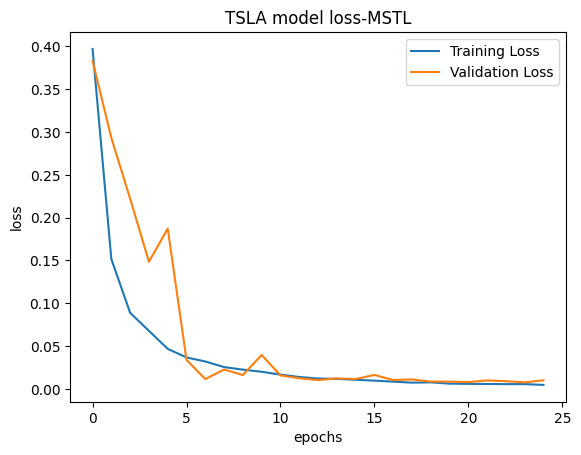

In [60]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [61]:
best_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 38, 16)            64        
                                                                 
 batch_normalization_19 (Ba  (None, 38, 16)            64        
 tchNormalization)                                               
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 19, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 17, 16)            784       
                                                                 
 batch_normalization_20 (Ba  (None, 17, 16)            64        
 tchNormalization)                                               
                                                      

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

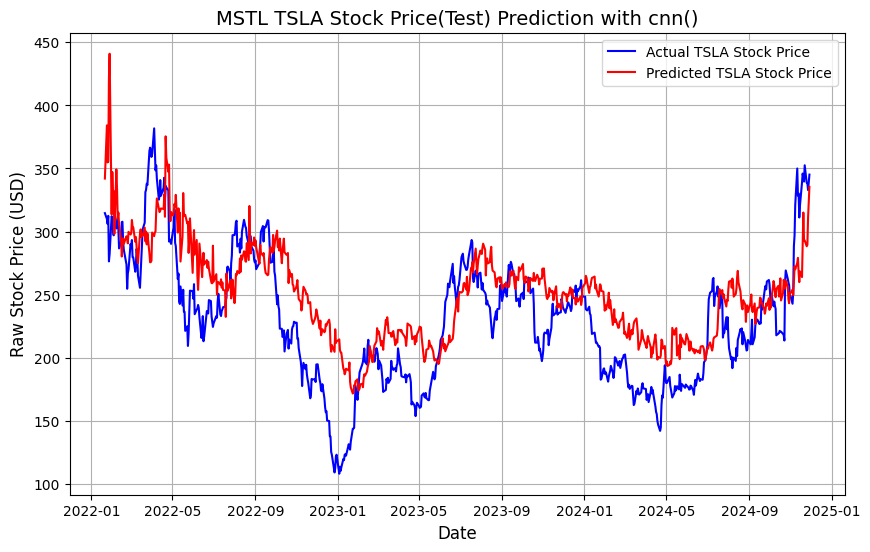

In [62]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="cnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

In [ ]:
rt_fft = tf.signal.fft(tesla_data['Close'])
fft = tf.signal.rfft(tesla_data[['Close']])
np.fft.fft(tesla_data['Close'])
recovered = tf.signal.ifft(rt_fft)
#plot tesla_data['Close] and recovered with x axis as tesla_data.index
plt.figure(figsize=(16,8))
plt.plot(tesla_data.index,tesla_data['Close'], label='Org Price', color='blue')
plt.plot(tesla_data.index,recovered, label='Rec Price', color='green')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [72]:
len(tesla_data['Close'])

5534

In [ ]:
# import scipy.fft as fft
# # Generate a time-domain signal
# t = np.linspace(0, 1, 1000)
# x = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)

# # Calculate the Fourier Transform
# X = fft.fft(tesla_data['Close'].values)
# freqs = fft.fftfreq(tesla_data['Close'].size,d=1)  # Calculate the frequencies

# from scipy import signal
# sos = signal.butter(2, 0.001, 'low', analog=False,output='sos')
# filtered = signal.sosfilt(sos, tesla_data[['Close']])
# # w, h = signal.freqs(b, a)

# # Plot the frequency-domain representation of the signal
# import matplotlib.pyplot as plt
# plt.plot(freqs, np.abs(X))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xlim([0, 50])  # Display frequencies from 0 to 50 Hz for clarity
# plt.show()

# #Plot the filtered data
# plt.figure(figsize=(10,6))
# plt.plot(tesla_data.index,filtered,label="filtered")
# plt.plot(tesla_data.index,tesla_data[['Close']],label="Actual")
# plt.title('Filtered Data')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()


#### AKAM - Proposed Filter(hybrid) - fourier_wavelet

In [57]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="hybrid" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="hybrid"
tuning=False
stock_file_name="AKAM_autoencoder_data.csv"
detail_index=8
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

##### After hyperparameter tuning - Evaluate model with best values

In [38]:
win_size= 10 #study_cnn.best_trial.params['win_size']
epoch_no= 100 #study_cnn.best_trial.params['epoch_no']
drop_out= 0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units= 30 #study_cnn.best_trial.params['units']
split_size= 0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu' #study_cnn.best_trial.params['activation_name']
filter_size= 64 #study_cnn.best_trial.params['filter_size']
kernel_size= 3 #study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3795, 10)
scaled X_train size (3795, 10, 1) (3795,)


2025-01-08 10:37:50.138505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13862 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6


Epoch 1/100


2025-01-08 10:37:53.036421: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-01-08 10:37:53.968810: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 10:37:53.972743: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-08 10:37:53.972791: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-08 10:37:53.972904: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-01-08 10:37

119/119 [==============================] - 11s 14ms/step - loss: 0.5287 - val_loss: 0.0019
Epoch 2/100
119/119 [==============================] - 1s 9ms/step - loss: 0.2642 - val_loss: 9.8660e-05
Epoch 3/100
119/119 [==============================] - 1s 8ms/step - loss: 0.1671 - val_loss: 2.8879e-05
Epoch 4/100
119/119 [==============================] - 1s 9ms/step - loss: 0.1004 - val_loss: 9.3861e-06
Epoch 5/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0782 - val_loss: 1.8496e-04
Epoch 6/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0600 - val_loss: 1.1089e-06
Epoch 7/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0421 - val_loss: 7.4557e-05
Epoch 8/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0292 - val_loss: 6.1862e-05
Epoch 9/100
119/119 [==============================] - 1s 9ms/step - loss: 0.0224 - val_loss: 1.4971e-04
Epoch 10/100
119/119 [==============================] - 1s 8ms/step -

##### Evaluate Trained Model

In [39]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 0s 5ms/step
**********************hybrid filter***************************
Mean Absolute Percentage Error (MAPE): 0.63%
Mean Absolute Error (MAE): 1.10
Root Mean Squared Error (RMSE): 1.18
R2 Score: -0.77


##### Val and training plot loss

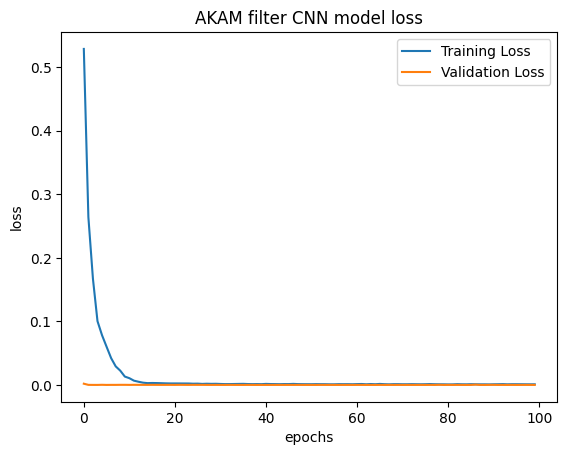

In [61]:
ticker="AKAM"
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} filter CNN model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save Model

In [62]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_hybrid/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_hybrid/assets


##### Plot

In [59]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['org_akam']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************
